In [ ]:
!pip install mlflow dagshub optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.0/251.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1

In [ ]:
import dagshub
dagshub.init(repo_owner='dakshvandanarathi', repo_name='YT-Sentiment-Analyser', mlflow=True)

Initialized MLflow to track repo "dakshvandanarathi/YT-Sentiment-Analyser"

Repository dakshvandanarathi/YT-Sentiment-Analyser initialized!

In [ ]:
import mlflow
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/preprocessed_data.csv').dropna(subset=['comment'])
df.shape

(36662, 5)

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp 2 - BoW vs TfIdf vs Word2vec")

<Experiment: artifact_location='mlflow-artifacts:/9a79f5eeed8641cb9572a547b3fbc09d', creation_time=1729440551320, experiment_id='2', last_update_time=1729440551320, lifecycle_stage='active', name='Exp 2 - BoW vs TfIdf vs Word2vec', tags={'mlflow.sharedViewState.00829c284b45d57939b76fd6febe9d7c1fcc3bbfb87f3c7ecf80063f898df0be': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["metrics.`accuracy`","attributes.`Source`","metrics.`-1_recall`","metrics.`-1_precision`","metrics.`0_recall`","metrics.`0_precision`","metrics.`1_recall`","metrics.`1_precision`"],"runsExpanded":{},"runsPinned":["21250fa2e78e4669b7ee15c4fe8d19d4"],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","viewMaximized":false,"runListHidden":false,"isAccordionReordered":false,"groupBy":"",

In [ ]:
# Function to vectorize data
def vectorize_data(X_train, X_test, vectorizer_type, ngram_range, max_features, vector_size=None):
    if vectorizer_type == 'bow':
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    elif vectorizer_type == 'word2vec':
        # Word2Vec specific process
        model = Word2Vec(sentences=X_train['comment'].apply(lambda x: x.split()), vector_size=vector_size, window=5, min_count=1)
        X_train_word2vec = np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(vector_size)], axis=0) for words in X_train['comment'].apply(lambda x: x.split())])
        X_test_word2vec = np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(vector_size)], axis=0) for words in X_test['comment'].apply(lambda x: x.split())])
        return X_train_word2vec, X_test_word2vec

    X_train_vec = vectorizer.fit_transform(X_train['comment']).toarray()
    X_test_vec = vectorizer.transform(X_test['comment']).toarray()

    return X_train_vec, X_test_vec

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Split data
    X = df[['comment', 'word_count', 'char_count', 'avg_word_length']]
    y = df['category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Suggest hyperparameters
    vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow", "tfidf", "word2vec"])
    vector_size = None
    max_features = None
    ngram_range = None

    if vectorizer_type != 'word2vec':
        ngram_range_str = trial.suggest_categorical("ngram_range", ["(1, 1)", "(1, 2)", "(1, 3)"])
        ngram_range = eval(ngram_range_str)
        max_features = trial.suggest_int("max_features", 1000, 10000)
    else:
        vector_size = trial.suggest_int("vector_size", 100, 300)

    # Vectorize data
    X_train_vec, X_test_vec = vectorize_data(X_train, X_test, vectorizer_type, ngram_range, max_features, vector_size)

    # Combine additional features
    X_train_combined = np.hstack([X_train_vec, X_train[['word_count', 'char_count', 'avg_word_length']].values])
    X_test_combined = np.hstack([X_test_vec, X_test[['word_count', 'char_count', 'avg_word_length']].values])

    # Train a RandomForest model
    model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
    model.fit(X_train_combined, y_train)

    # Make predictions
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    # Log each run with MLflow
    with mlflow.start_run() as run:
        # Set run name
        if vectorizer_type == "word2vec":
            mlflow.set_tag("mlflow.runName", f"word2vec_{vector_size}")
        else:
            mlflow.set_tag("mlflow.runName", f"{ngram_range_str}_{vectorizer_type}_{max_features}")

        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("vector_size", vector_size)

        # Log model metrics
        mlflow.log_metric("accuracy", accuracy)

        # Logging the classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Confusion matrix plot
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        # Save and log the confusion matrix plot
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

    return accuracy

[I 2024-10-21 03:00:41,362] A new study created in memory with name: Bow vs TFIDF vs Word2vec
2024/10/21 03:03:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run word2vec_154 at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/2/runs/95e96763ddf34d4982721399fa98fb65.
2024/10/21 03:03:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/2.
[I 2024-10-21 03:03:02,974] Trial 0 finished with value: 0.6191190508659484 and parameters: {'vectorizer_type': 'word2vec', 'vector_size': 154}. Best is trial 0 with value: 0.6191190508659484.
2024/10/21 03:06:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run word2vec_273 at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/2/runs/16beda1ca0bd428ca7a6cf7123e34ba1.
2024/10/21 03:06:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.c

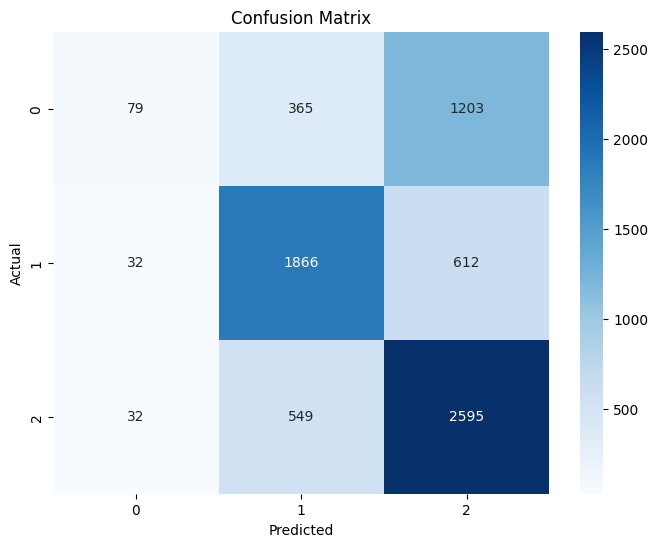

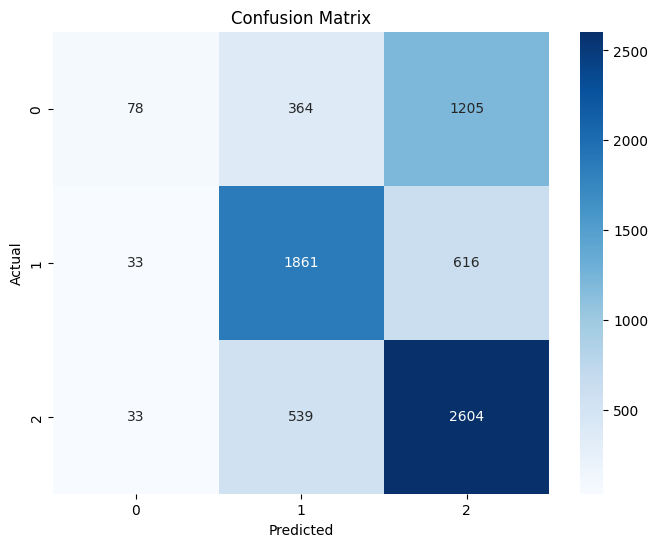

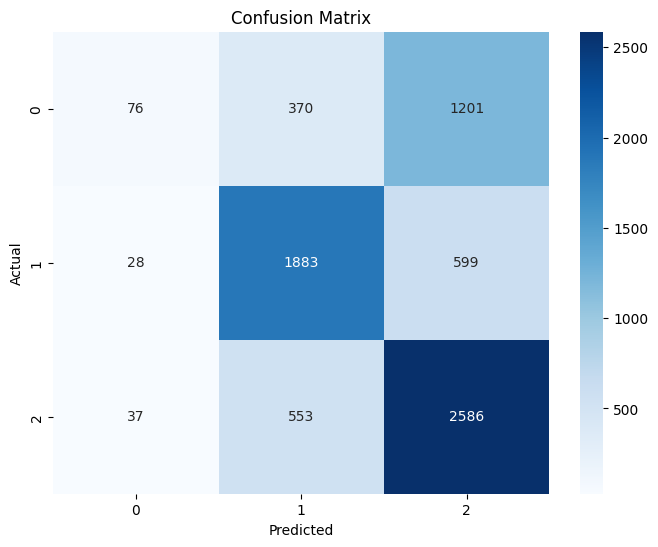

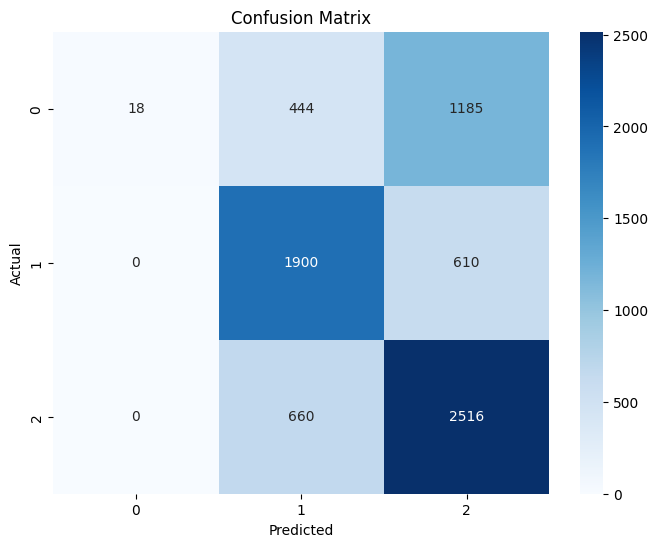

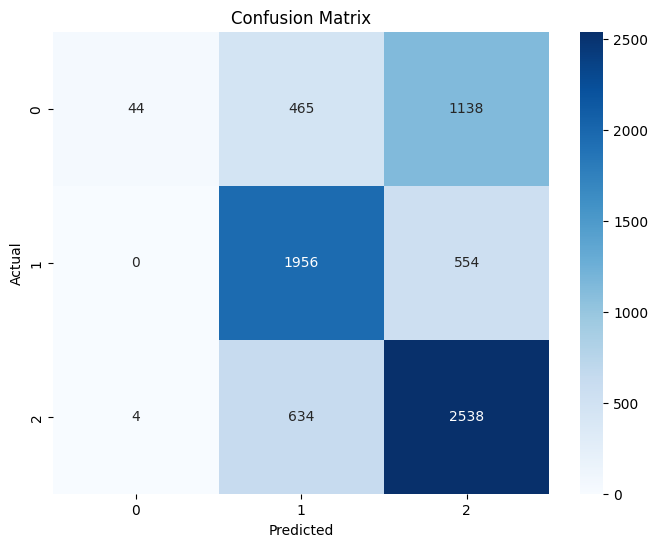

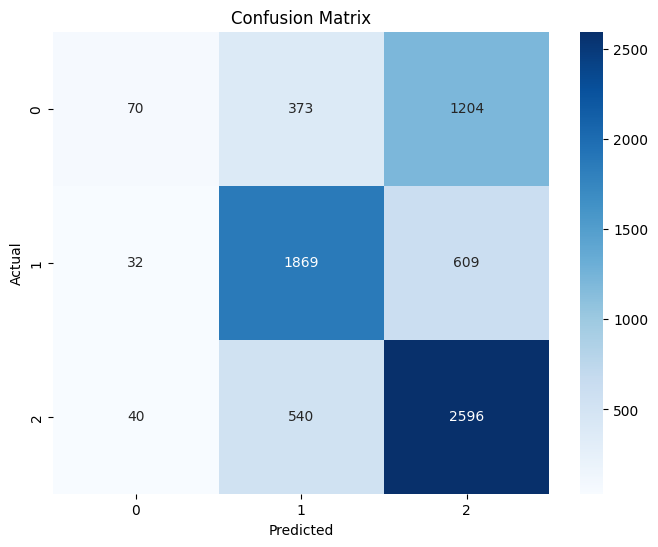

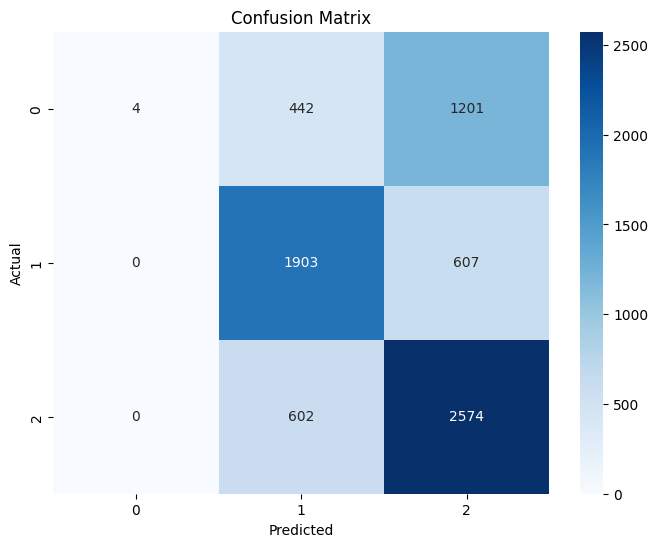

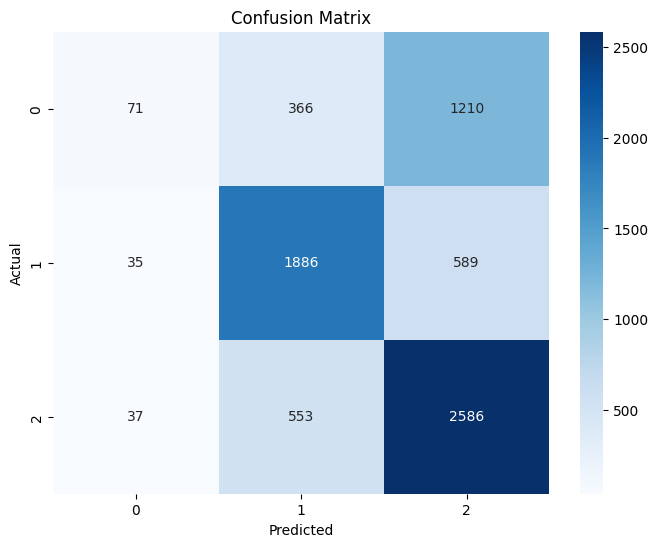

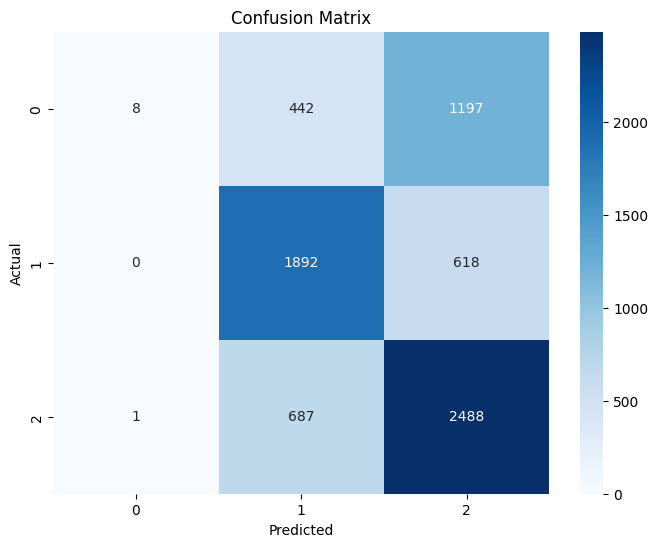

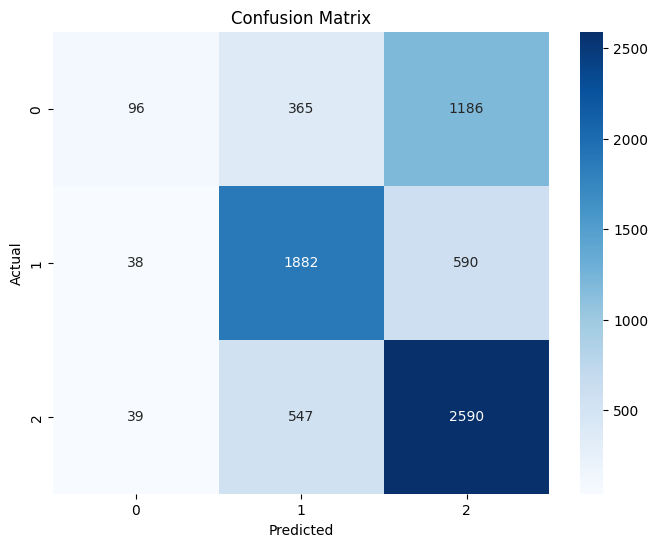

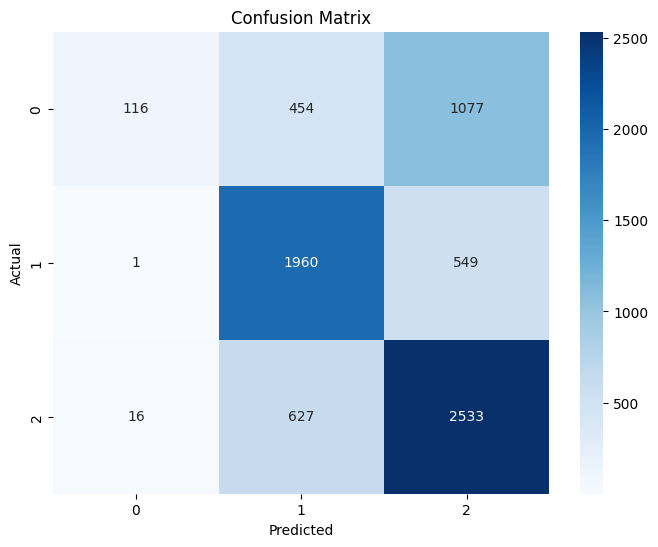

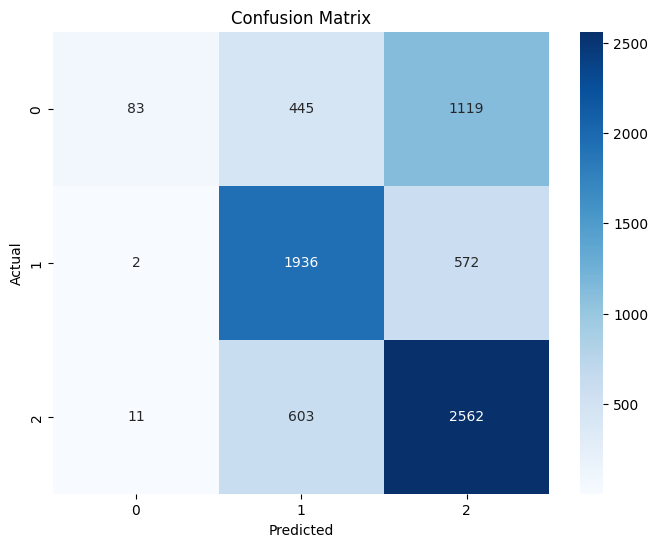

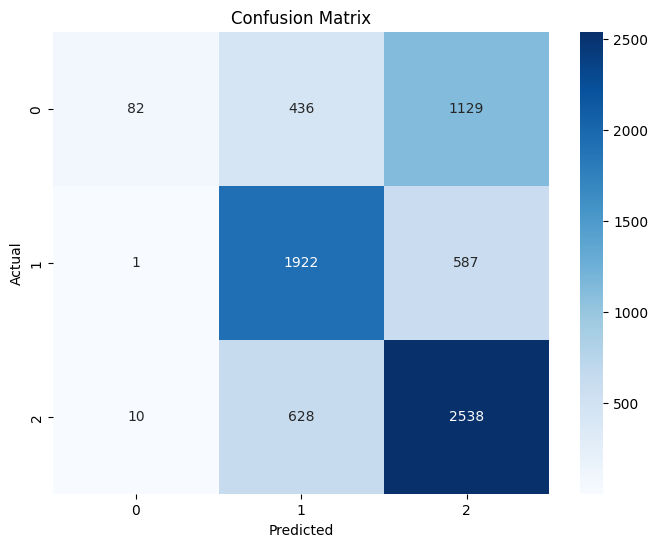

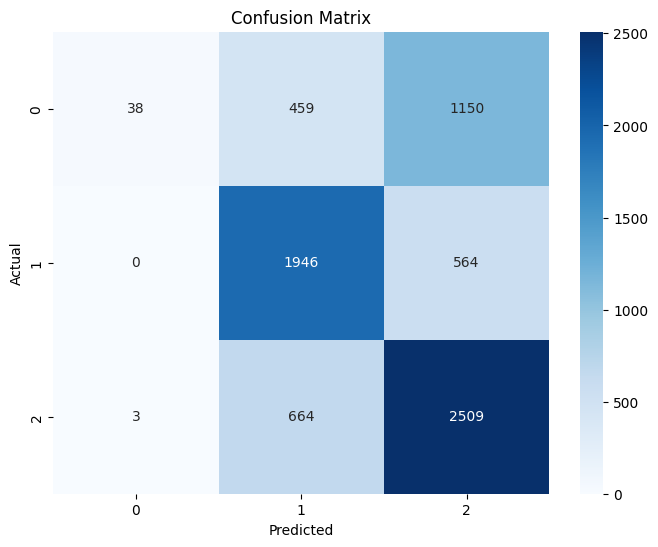

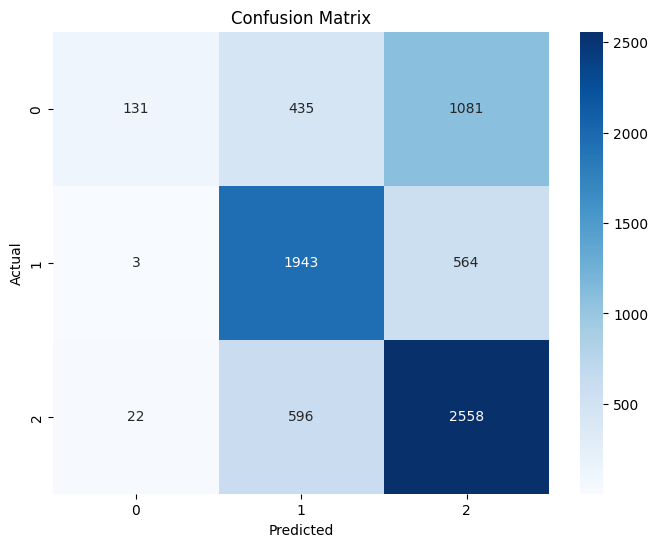

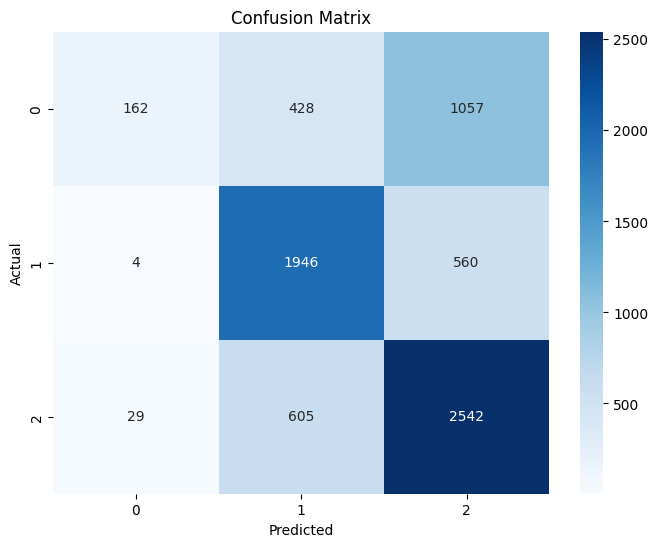

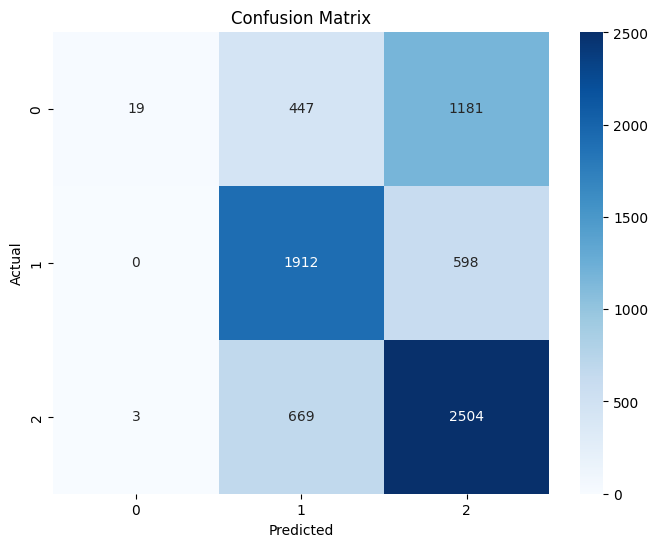

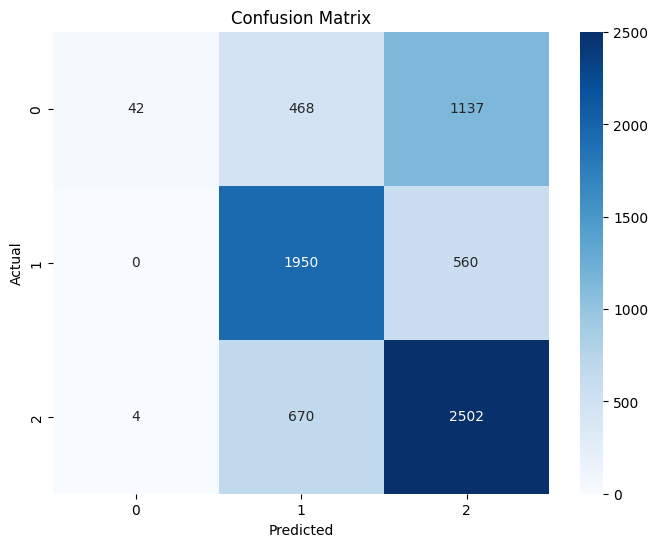

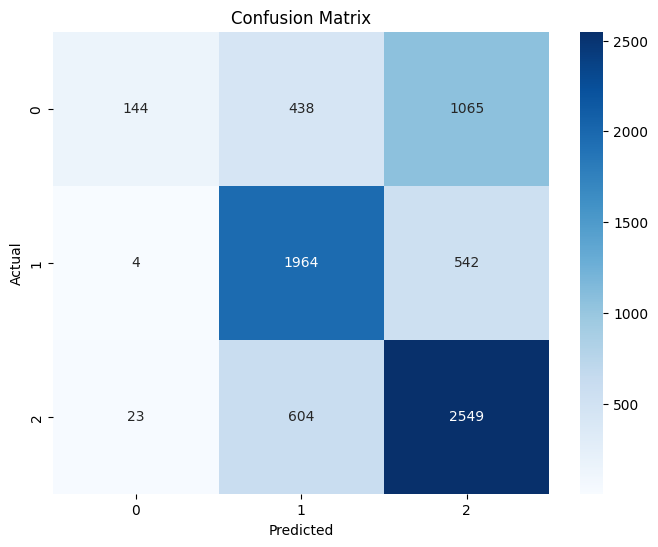

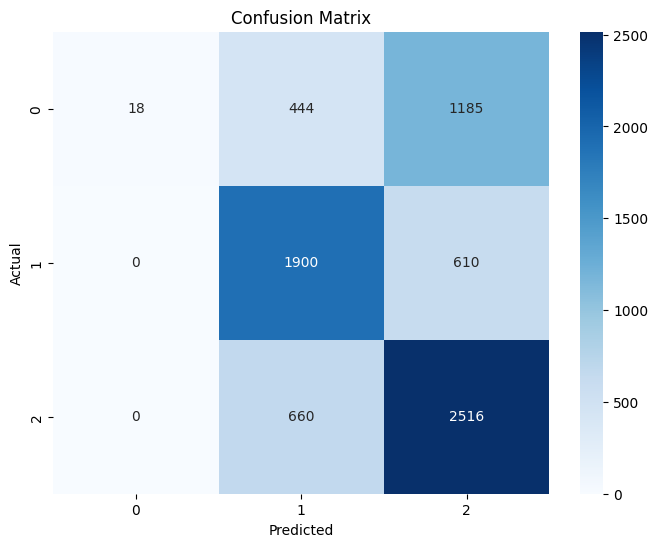

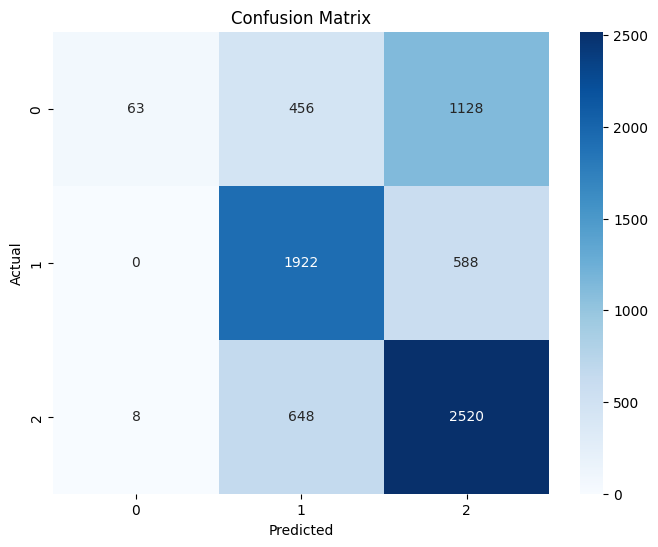

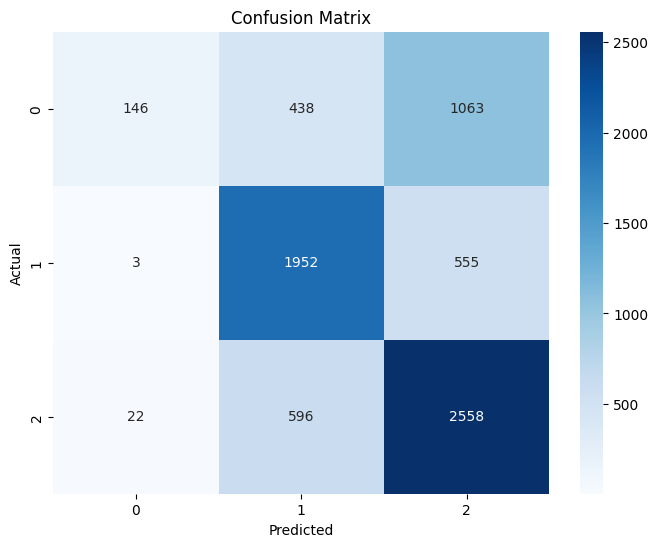

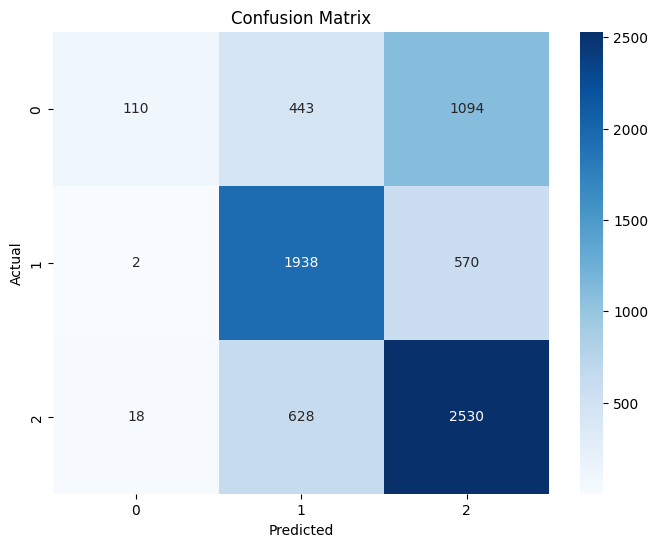

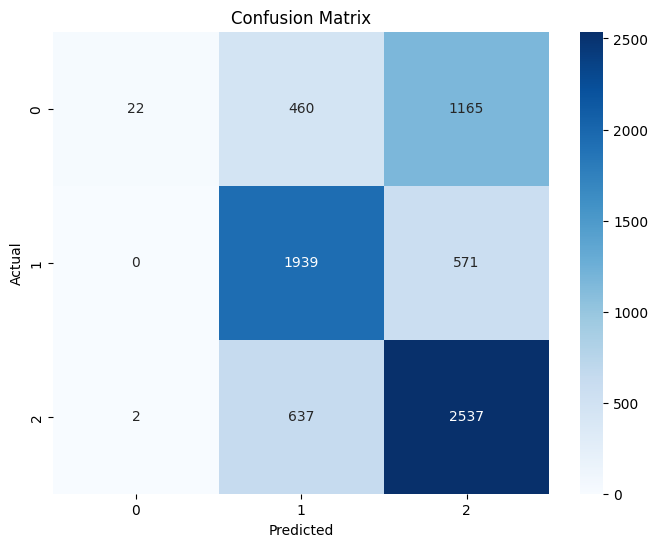

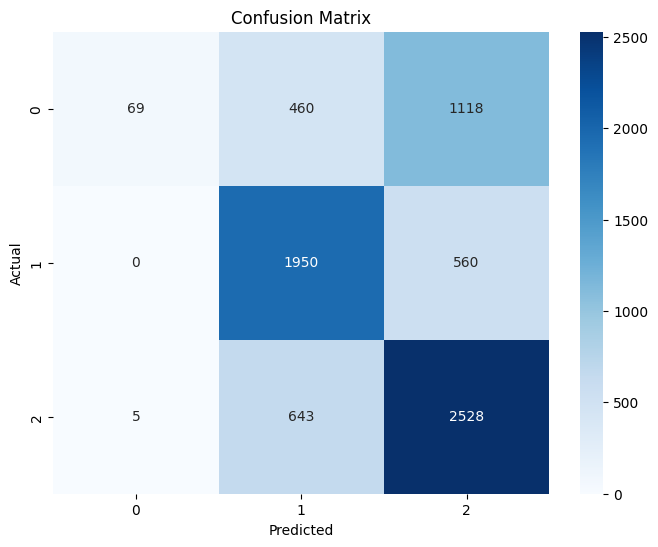

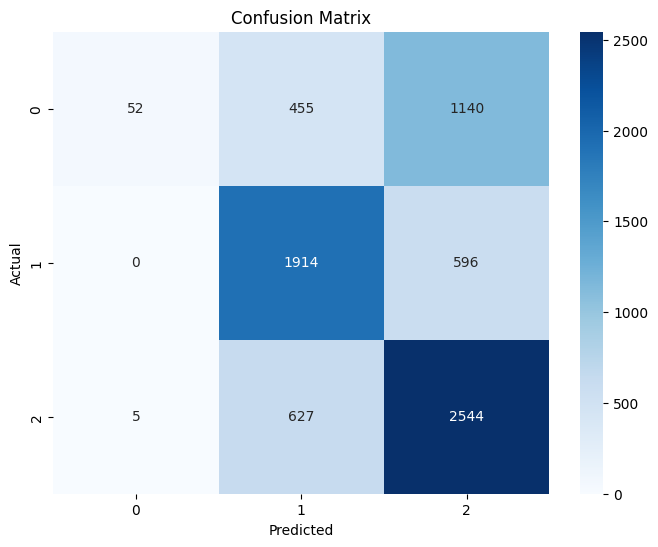

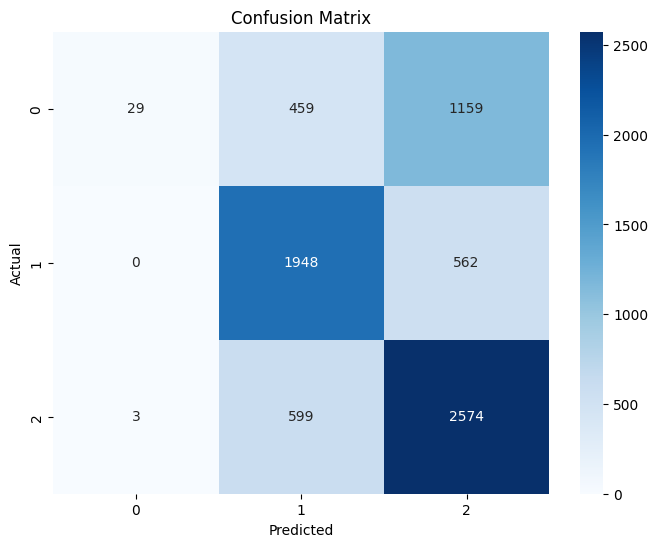

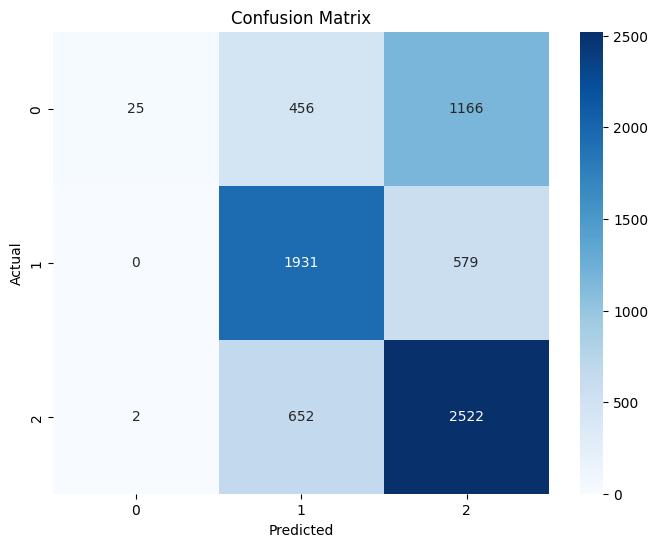

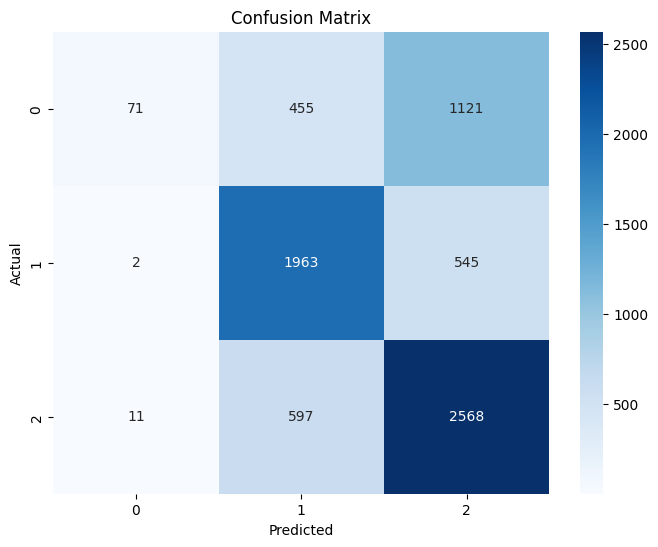

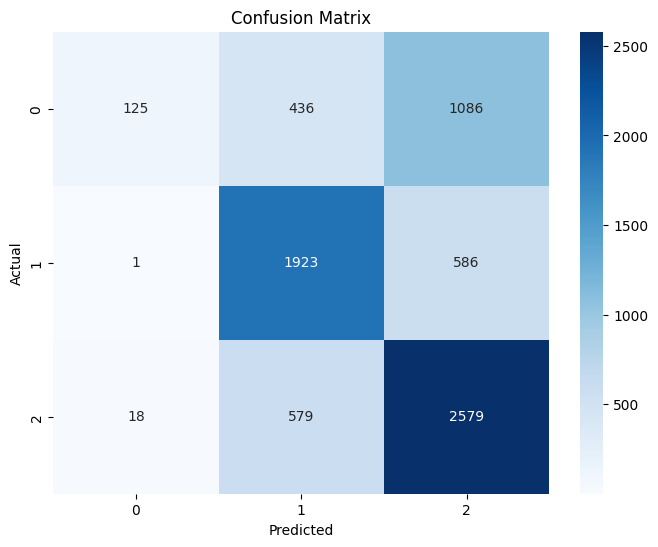

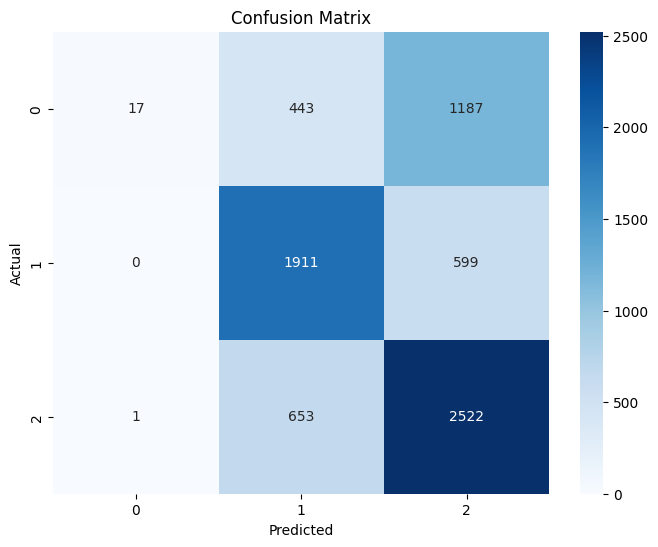

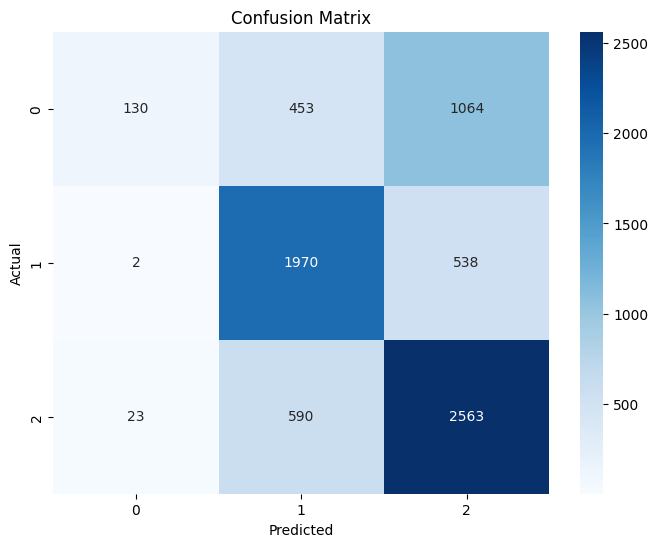

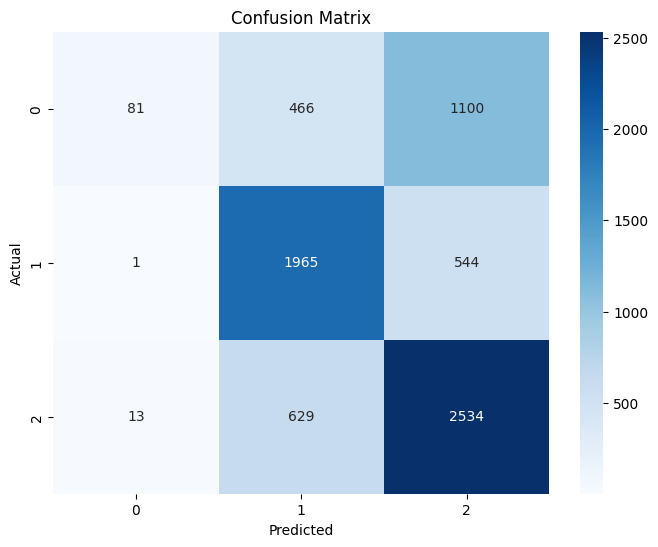

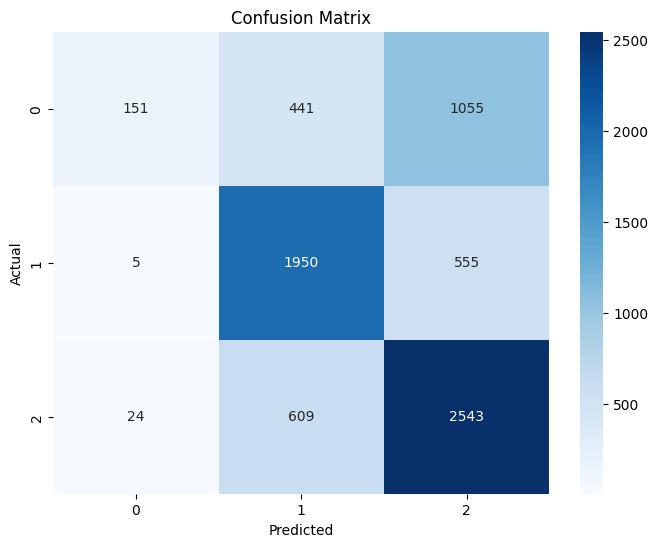

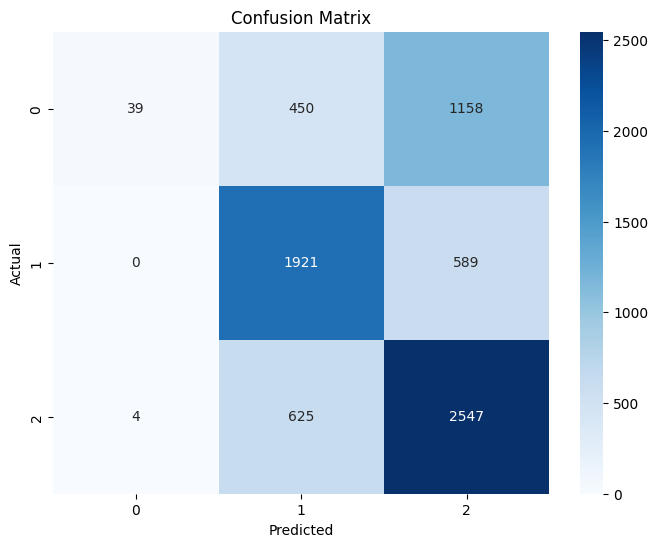

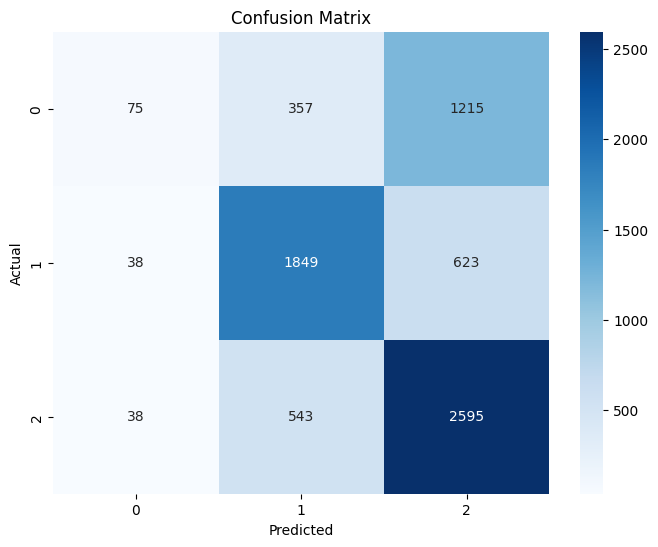

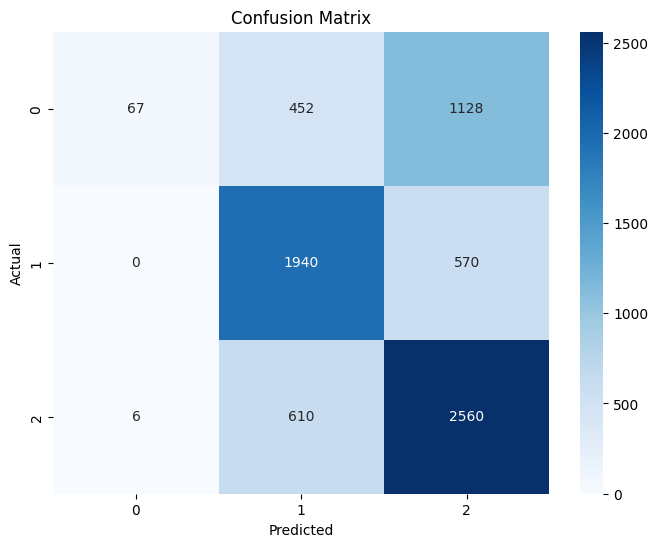

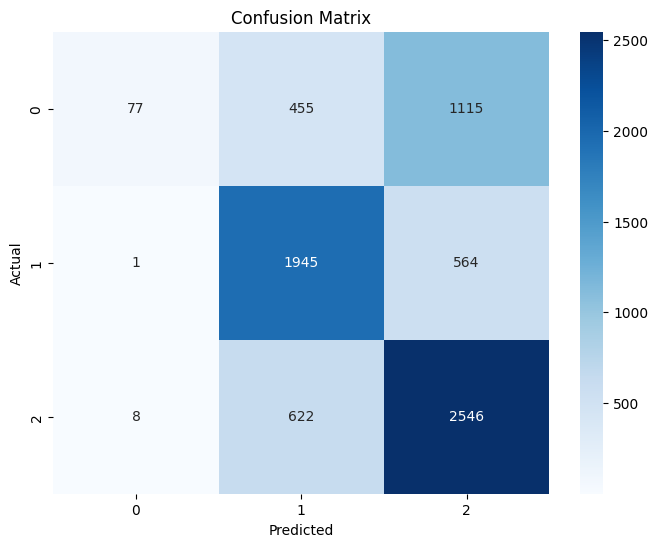

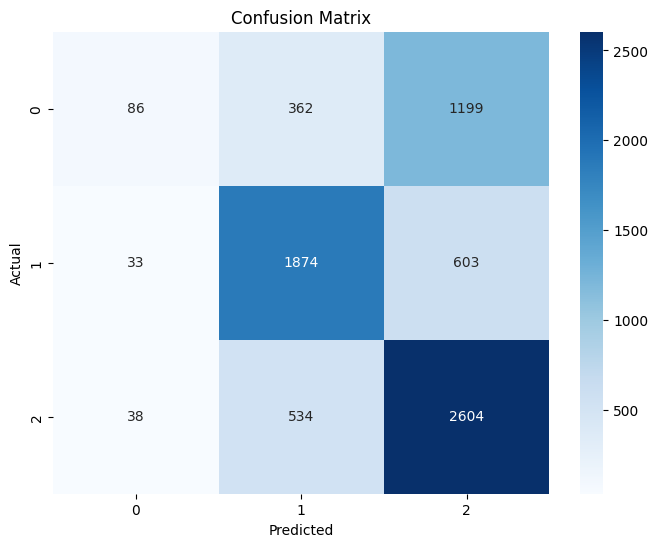

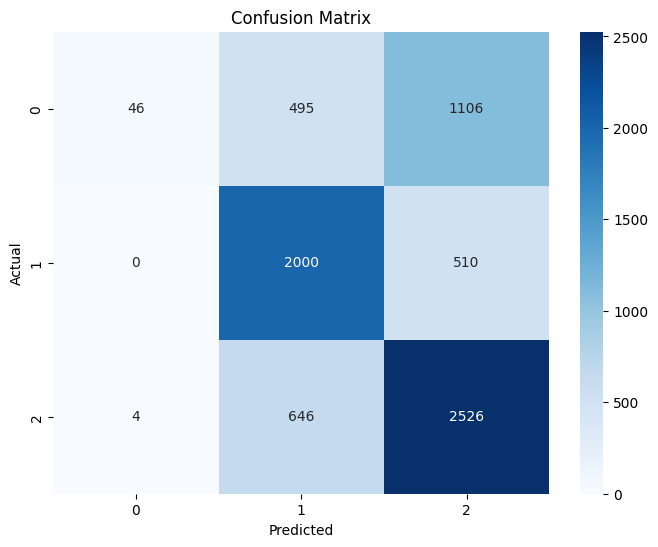

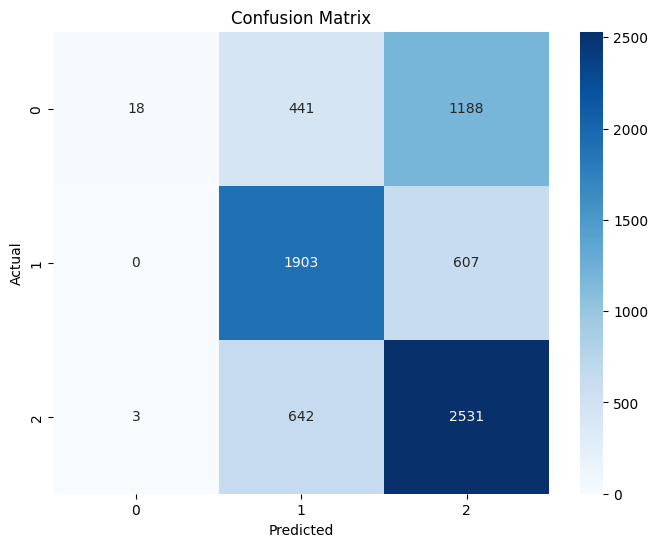

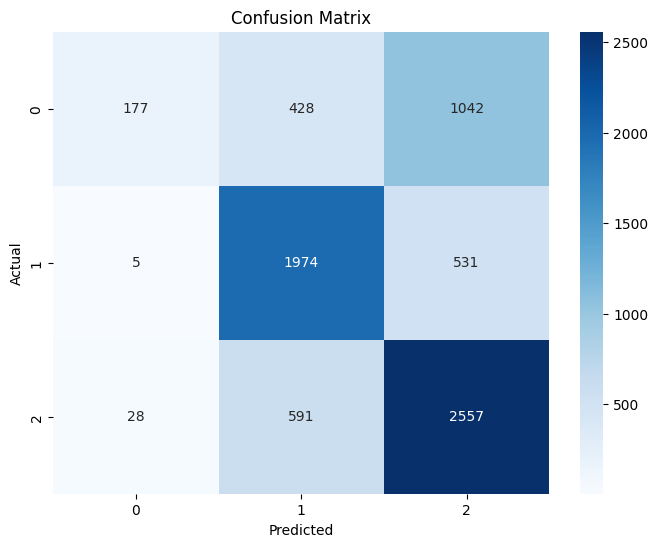

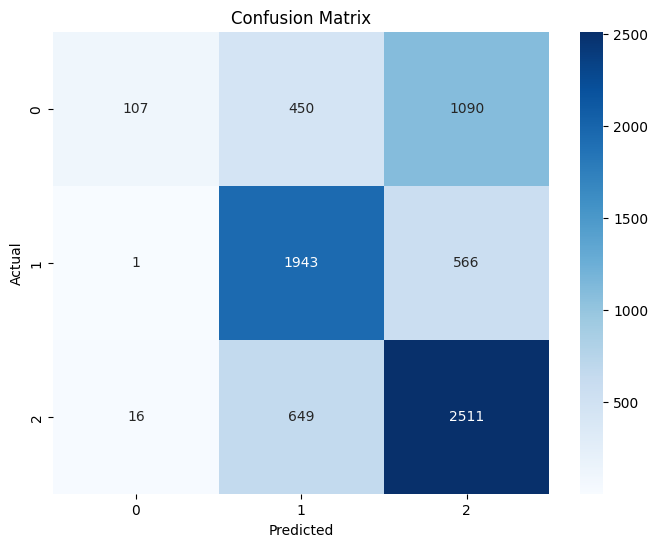

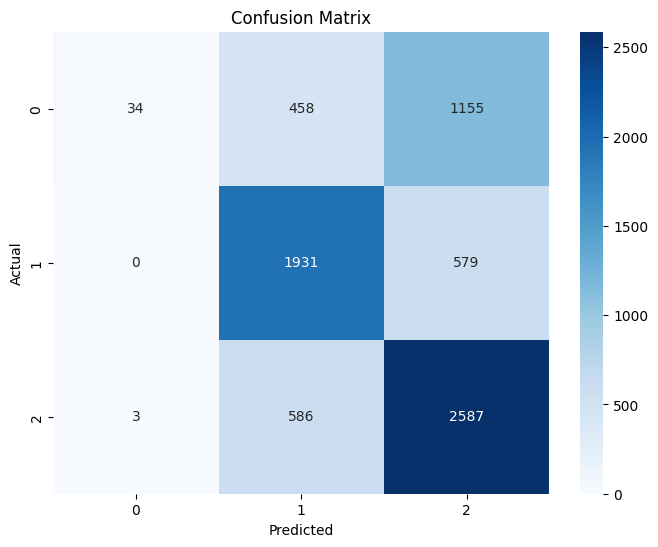

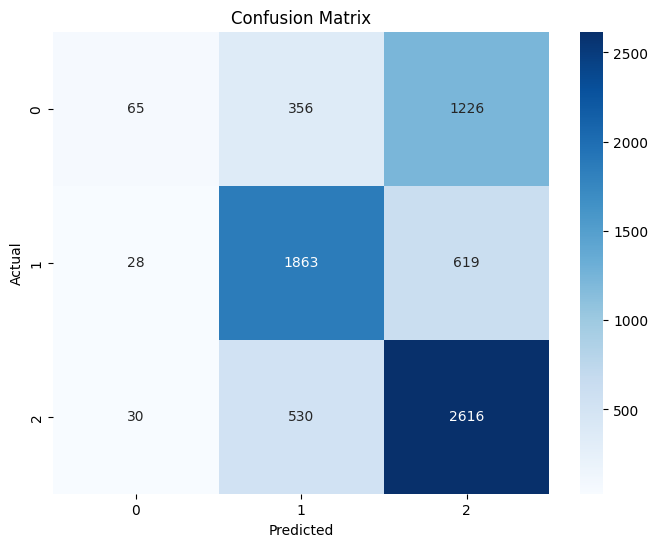

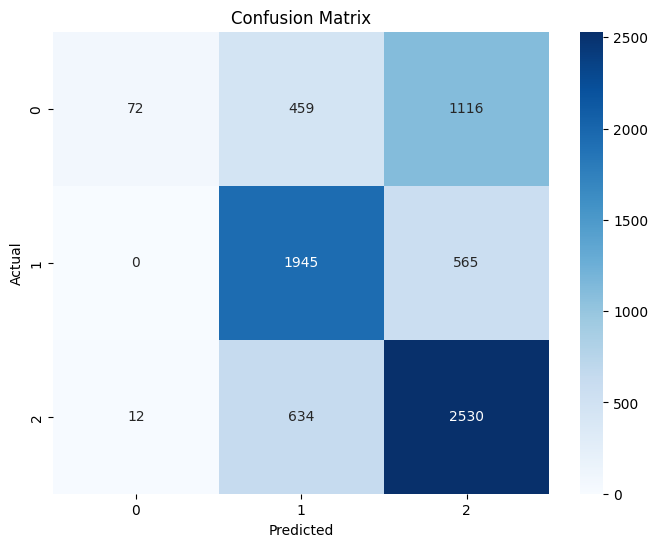

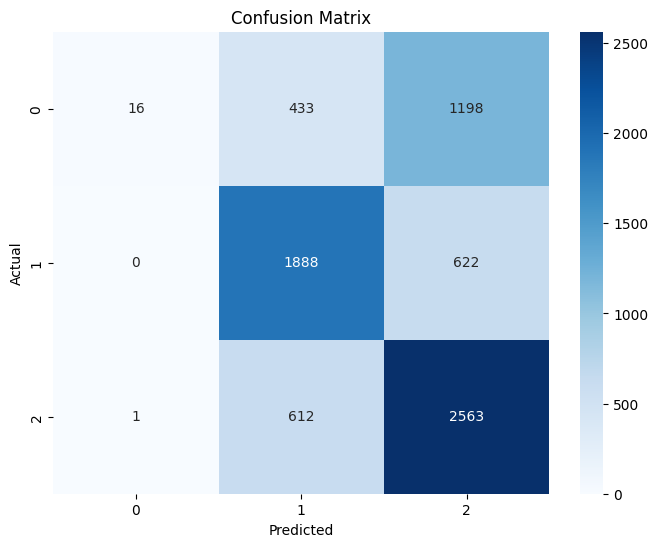

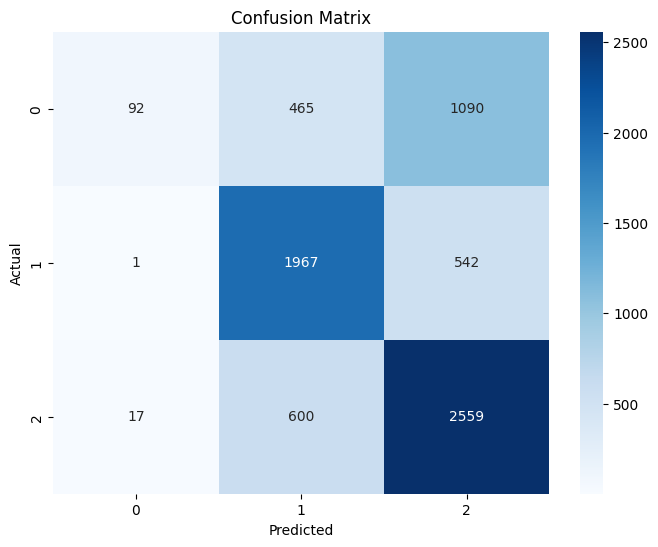

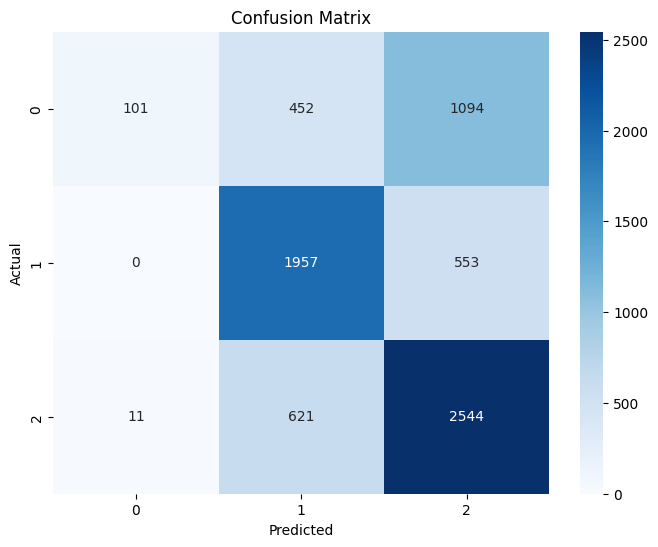

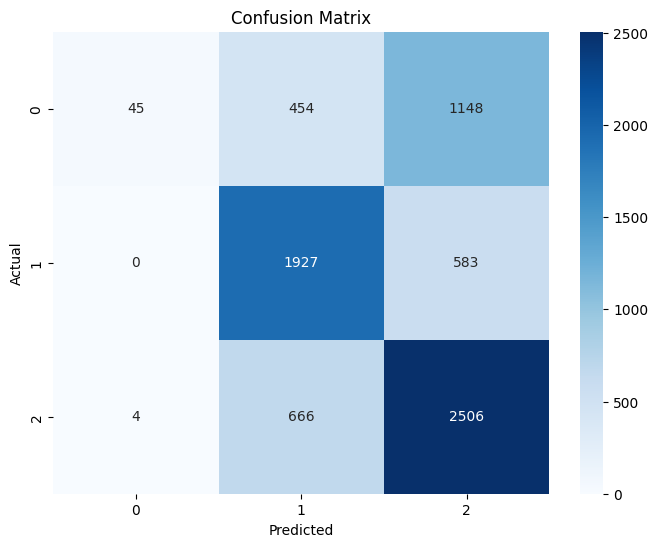

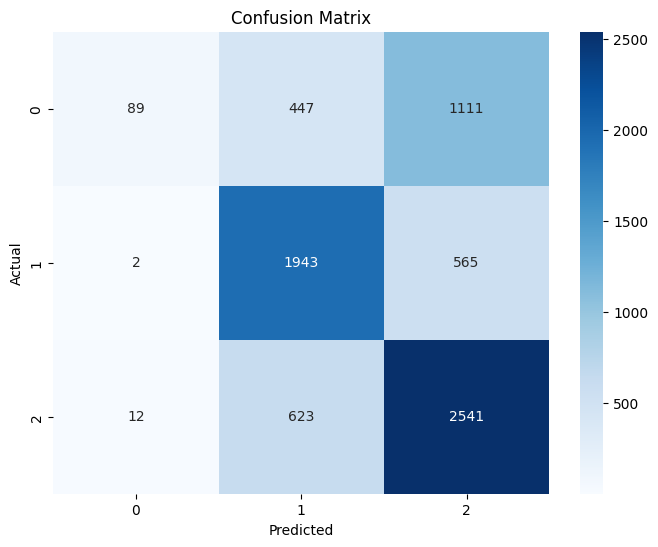

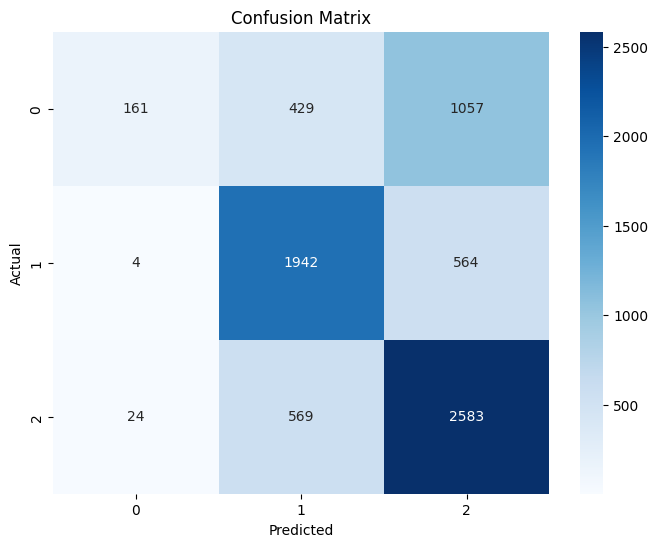

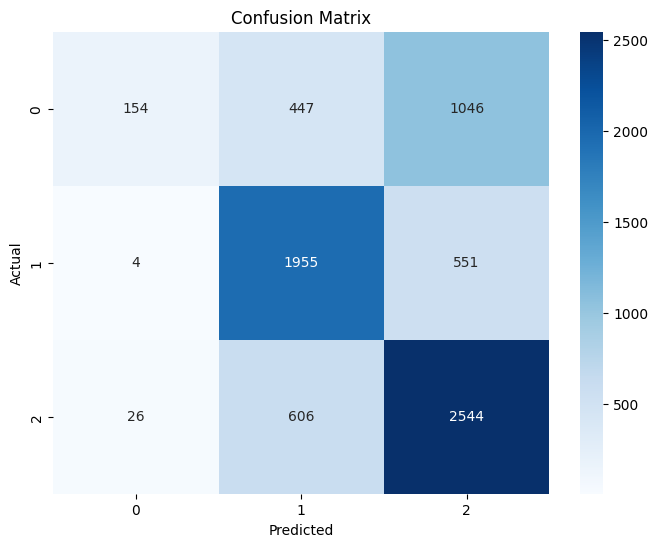

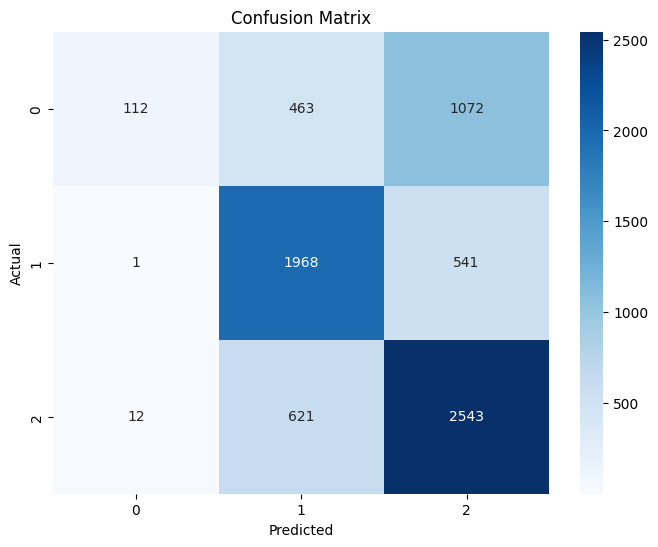

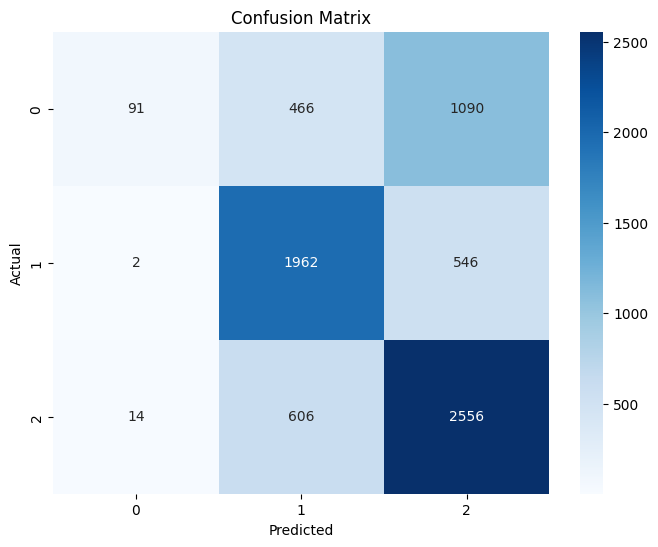

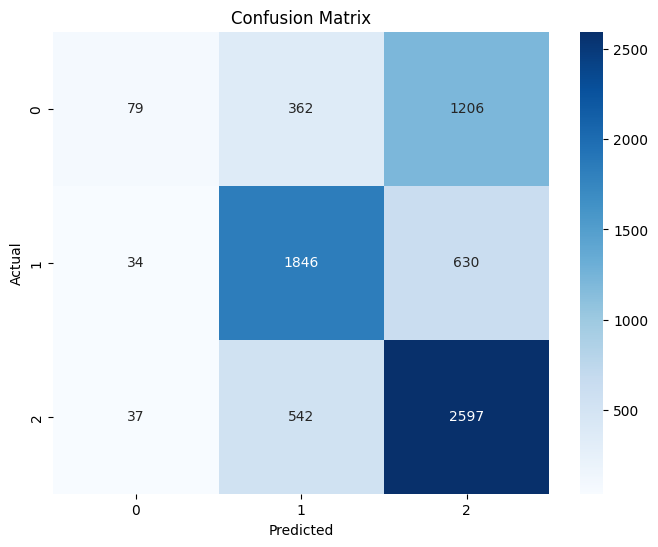

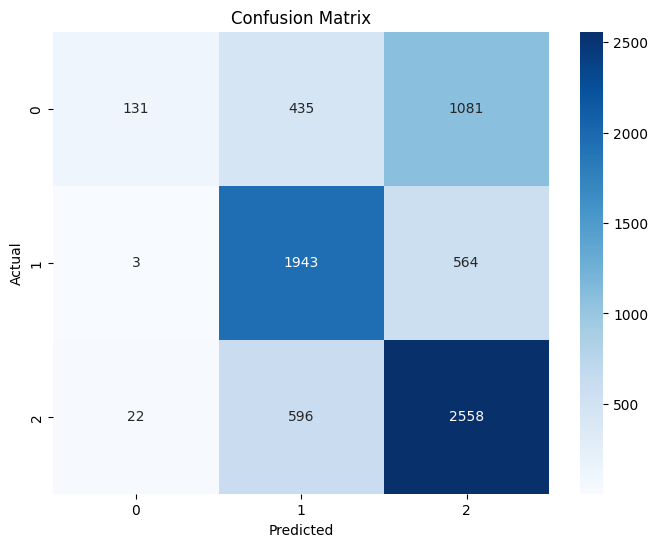

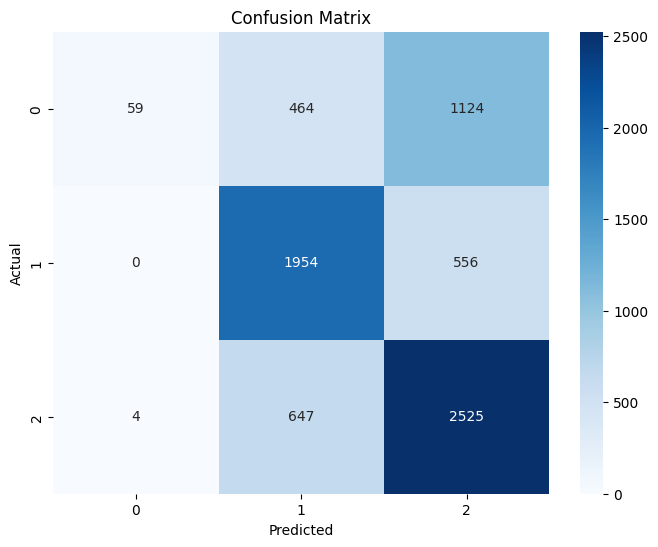

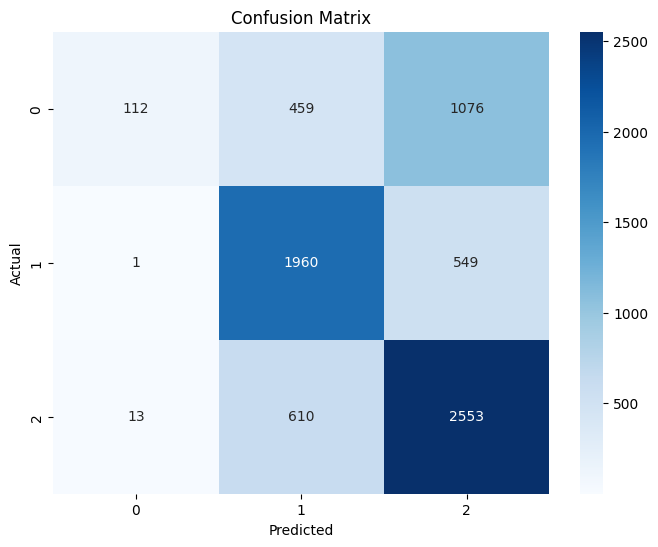

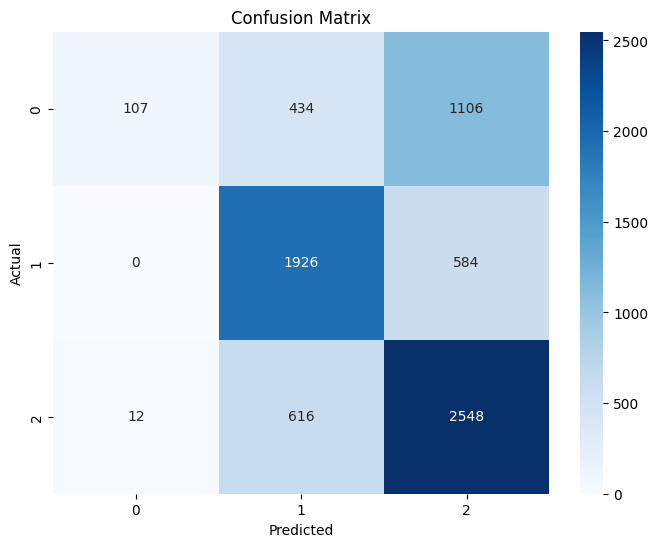

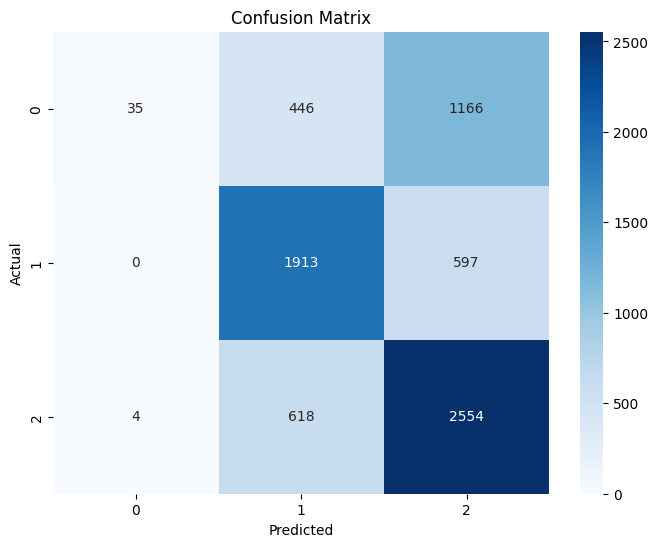

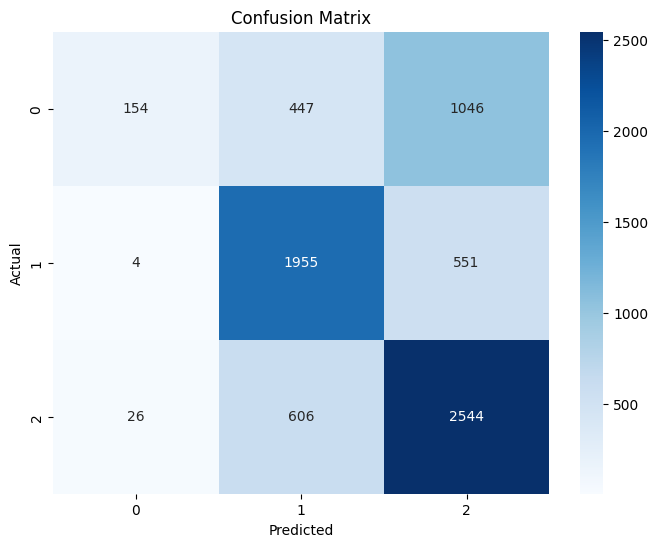

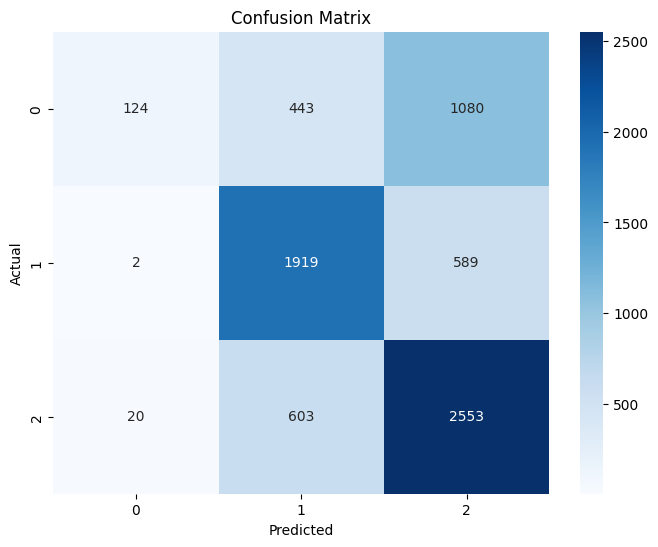

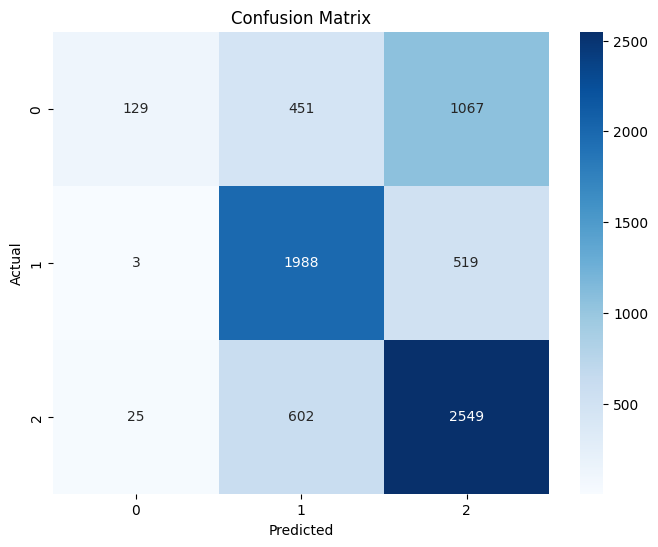

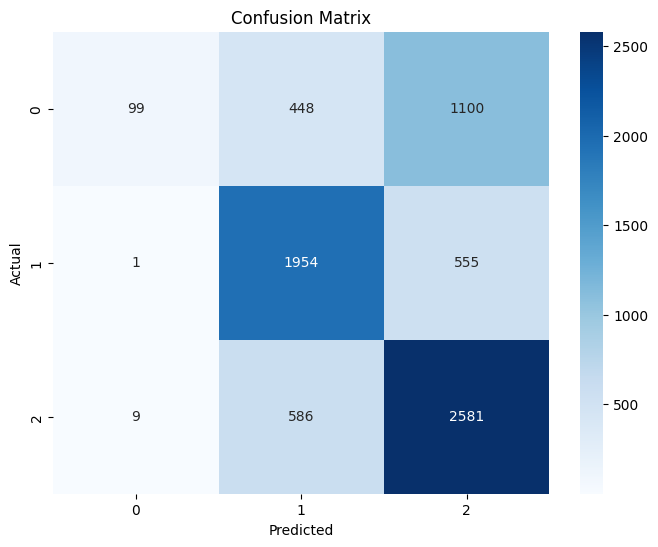

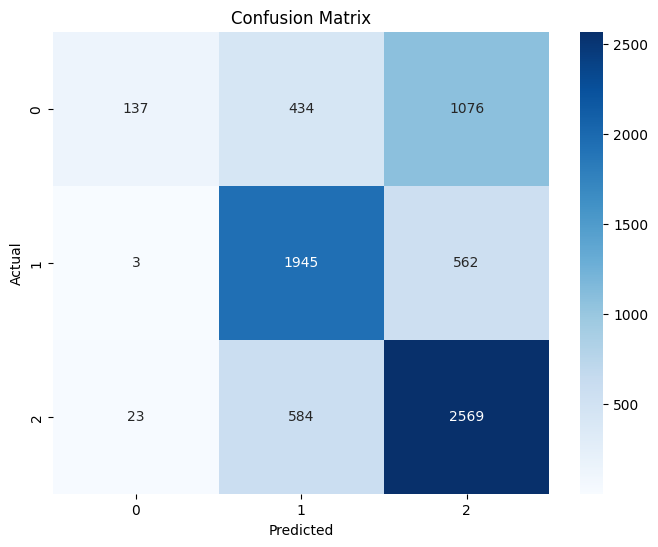

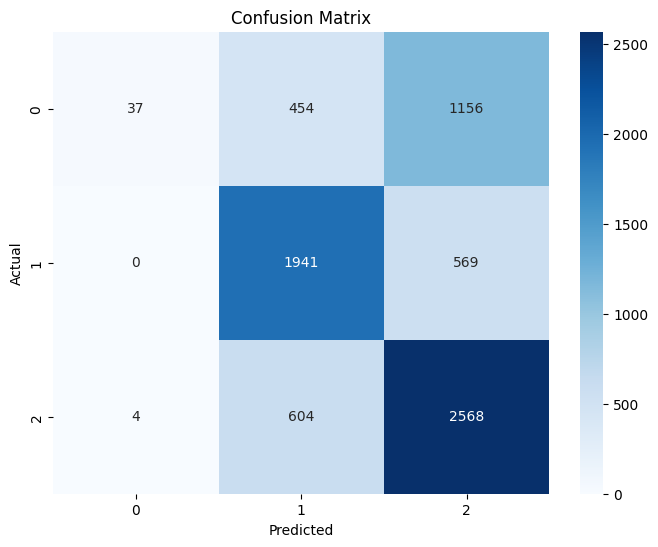

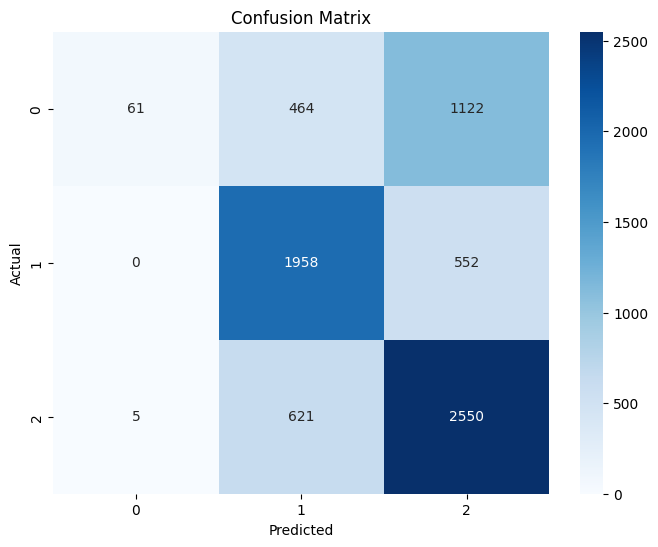

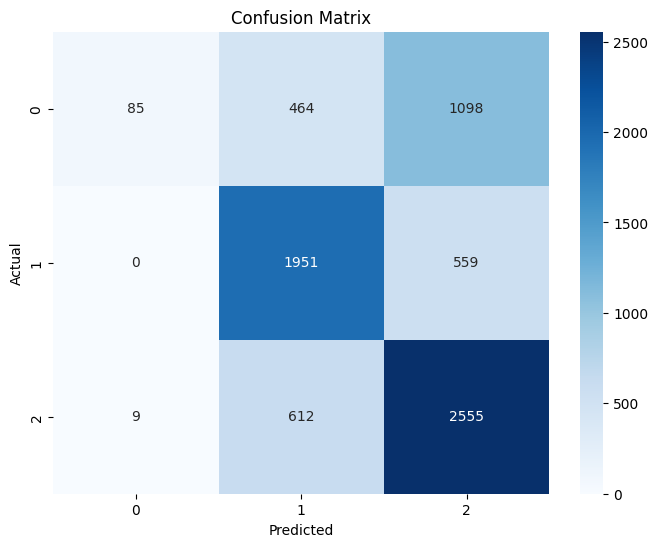

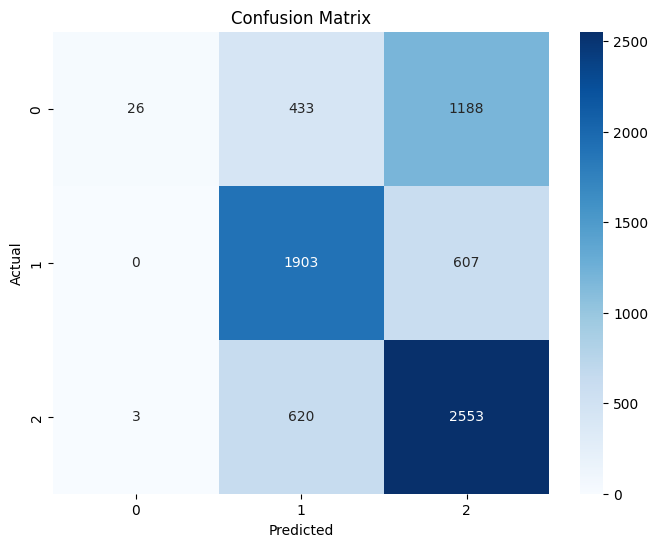

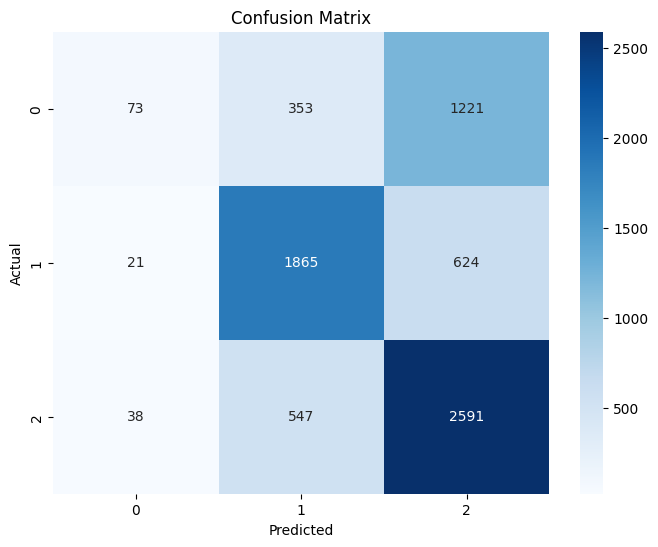

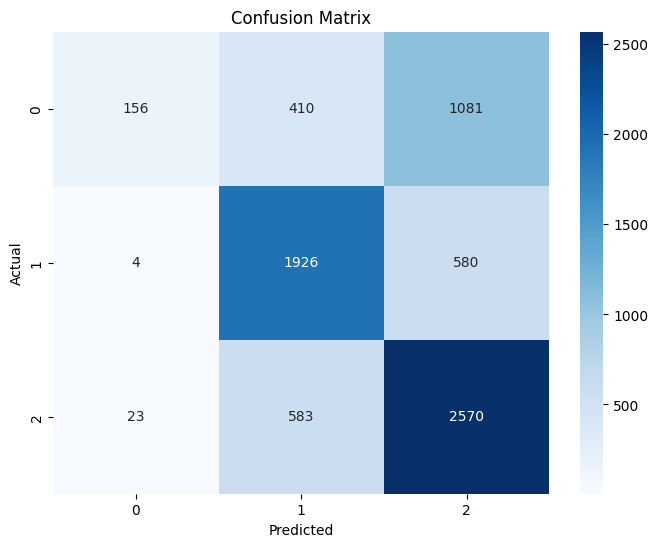

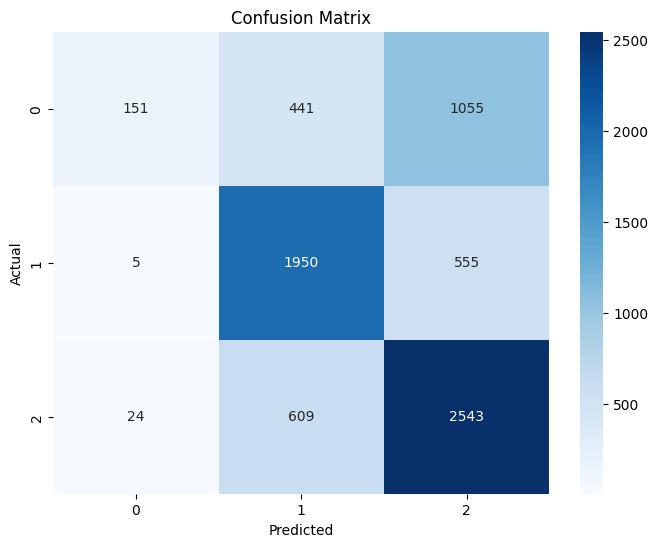

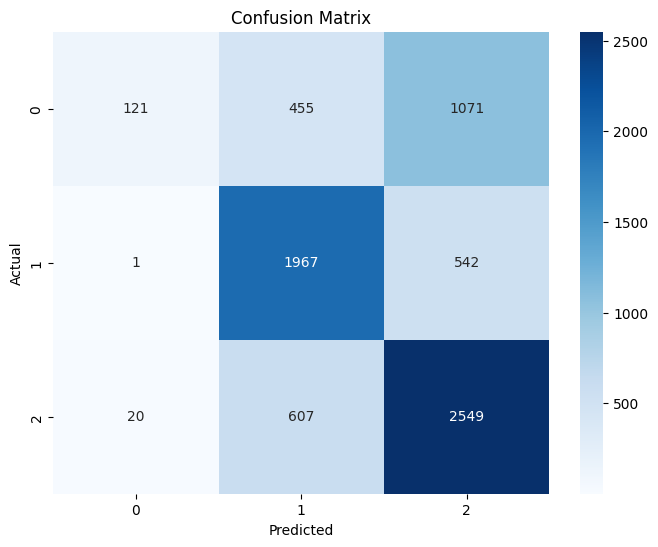

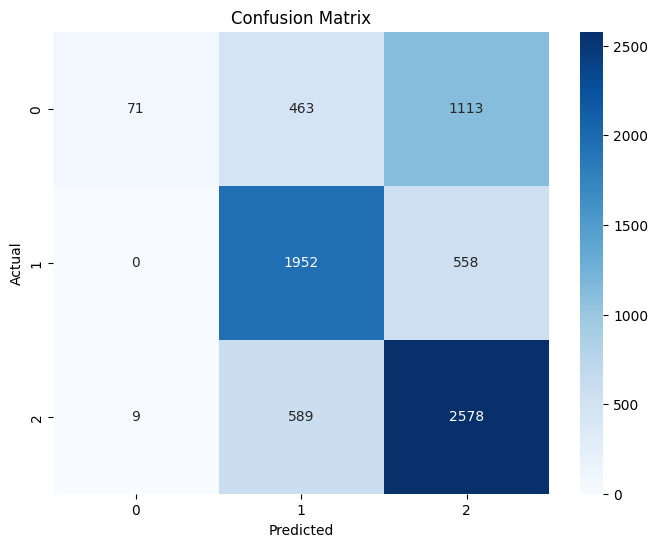

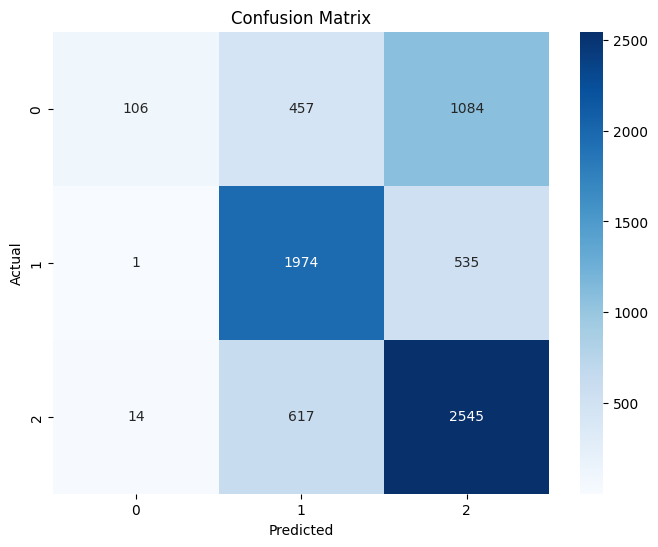

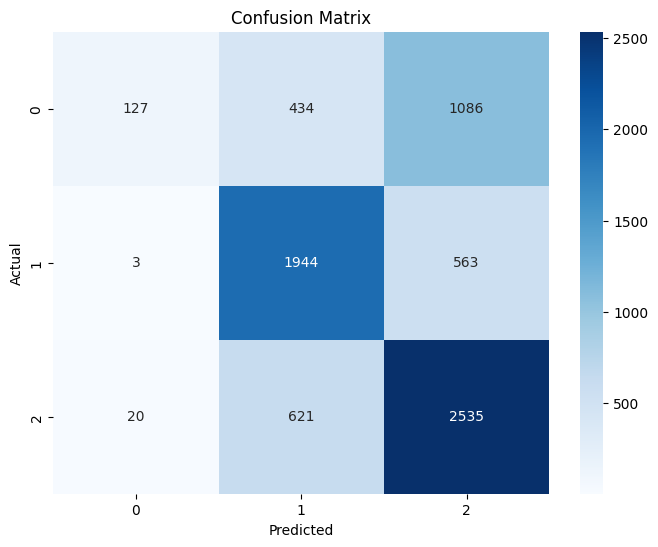

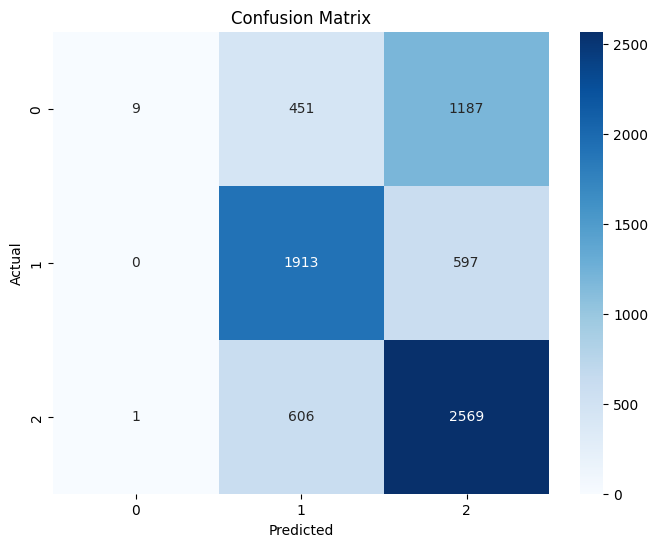

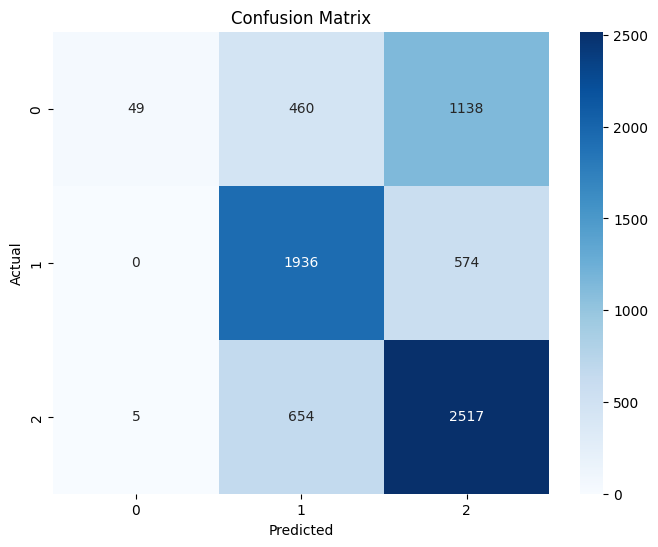

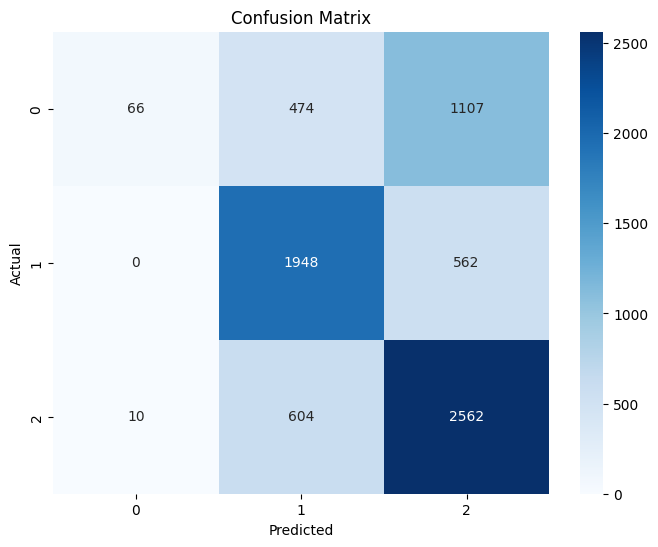

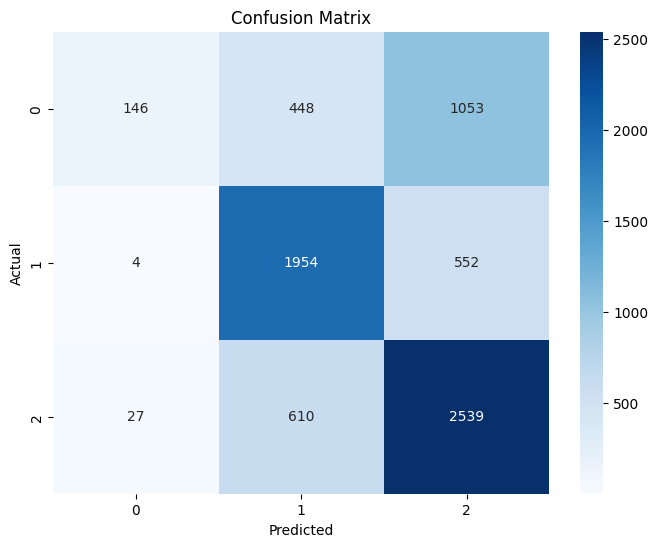

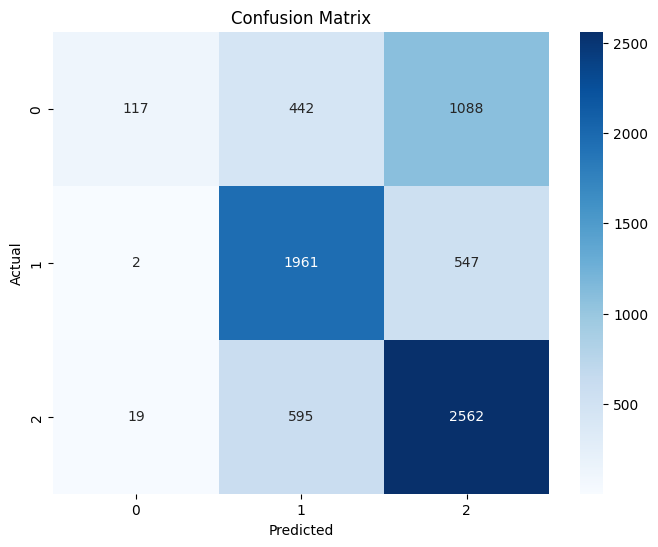

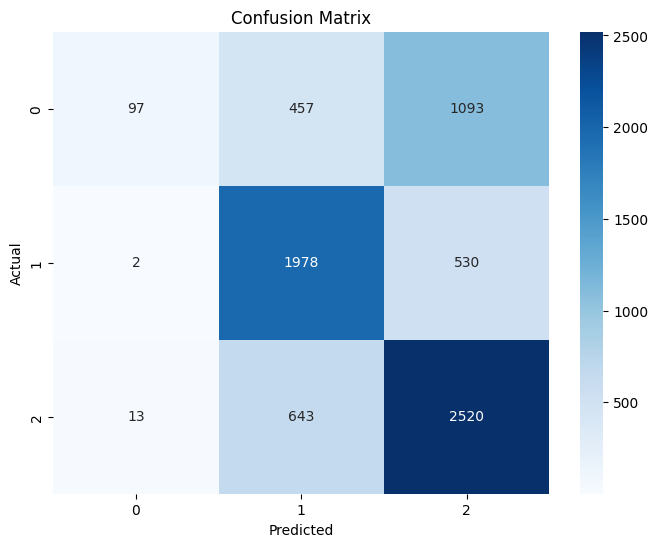

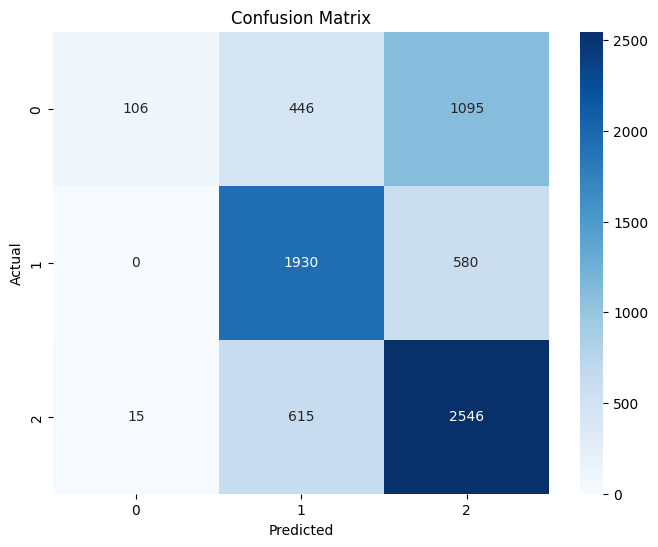

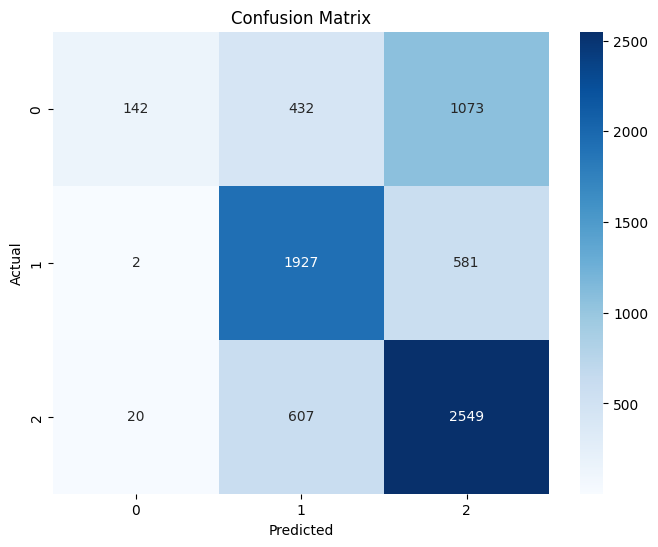

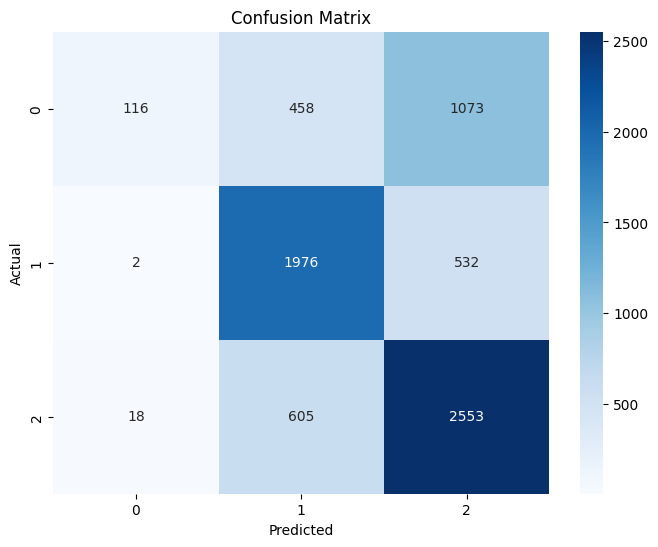

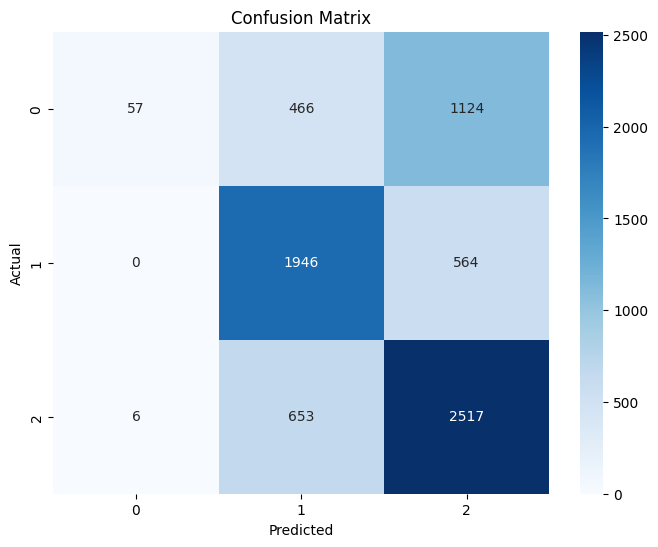

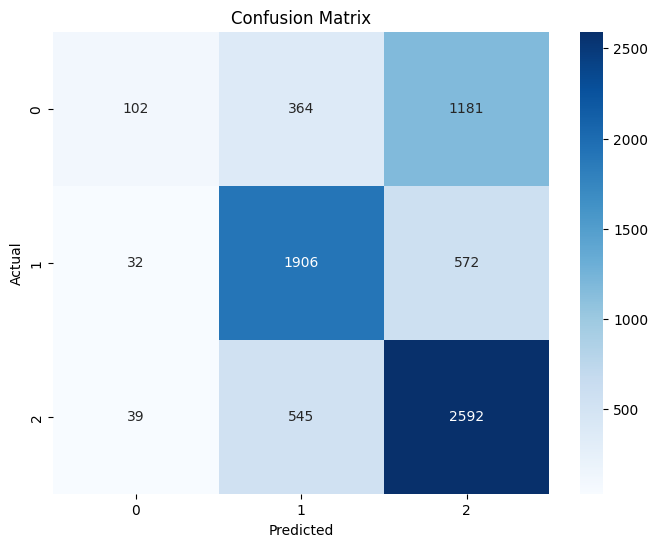

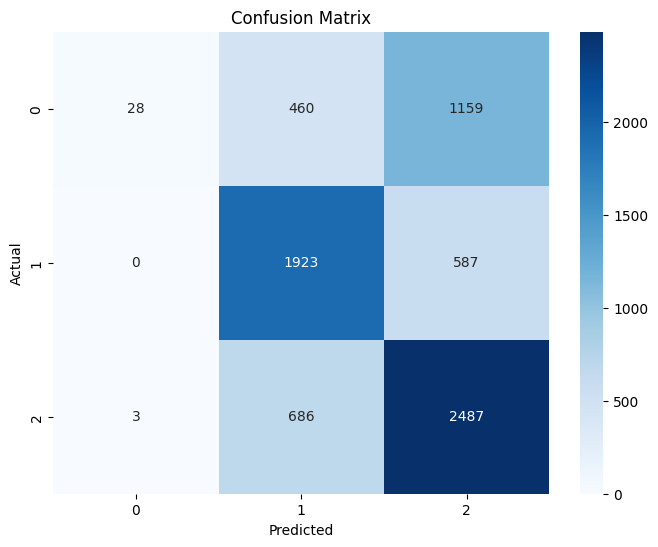

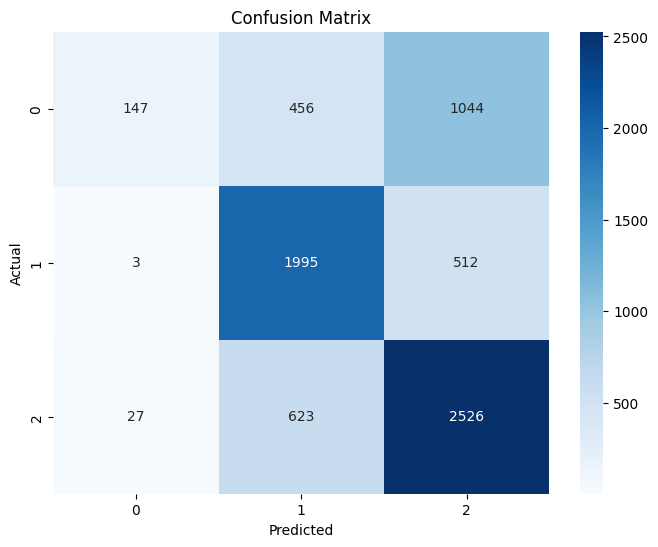

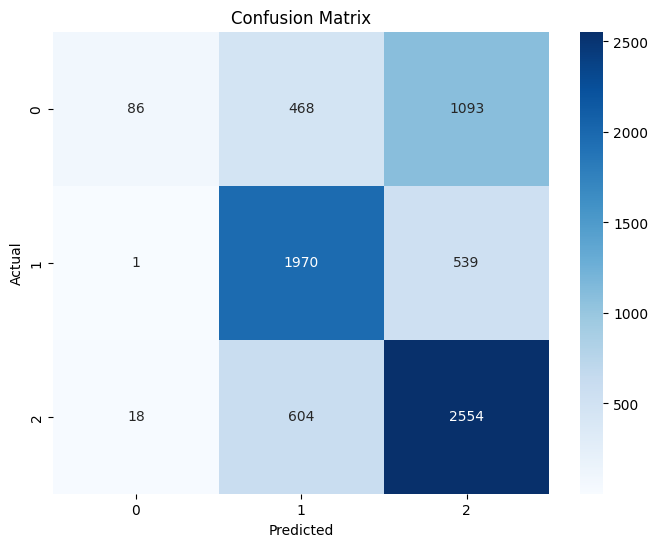

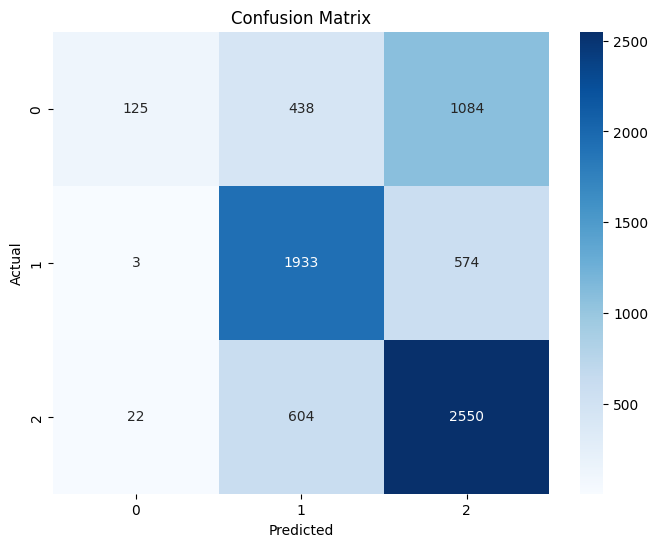

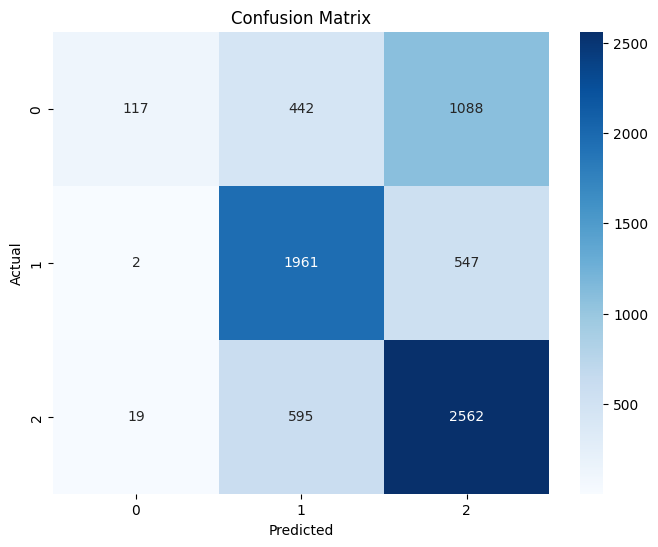

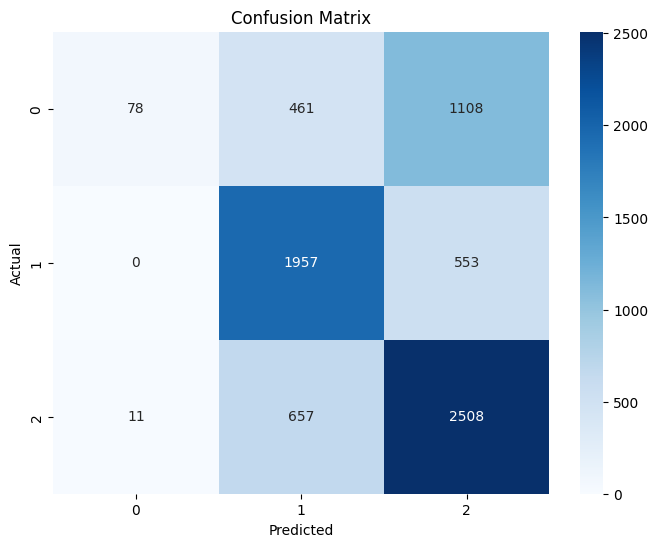

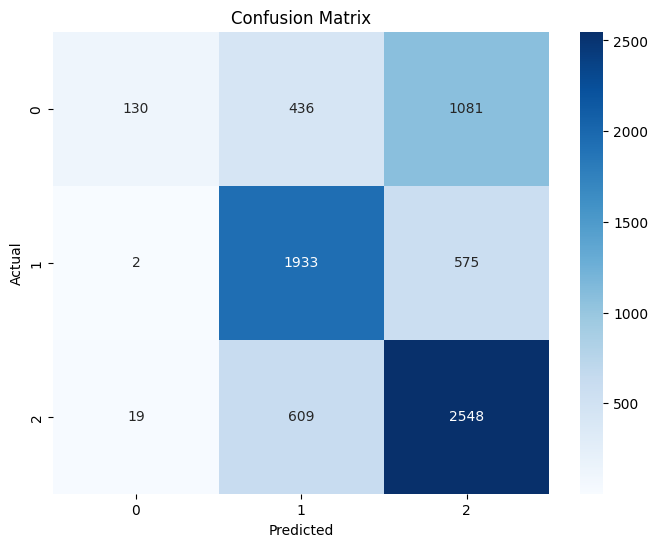

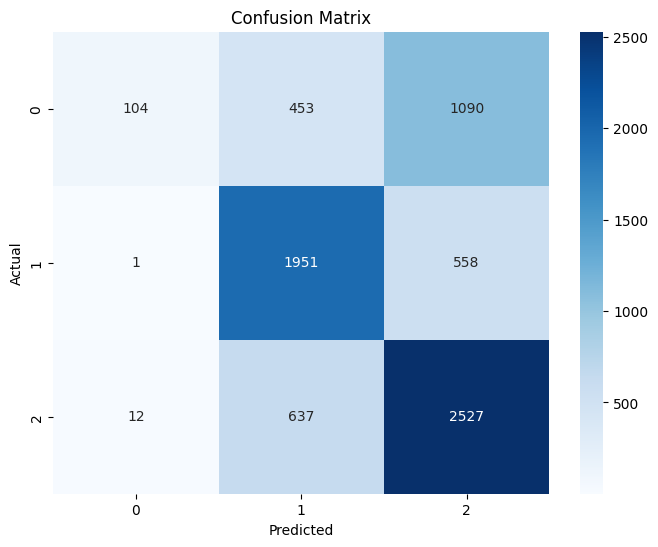

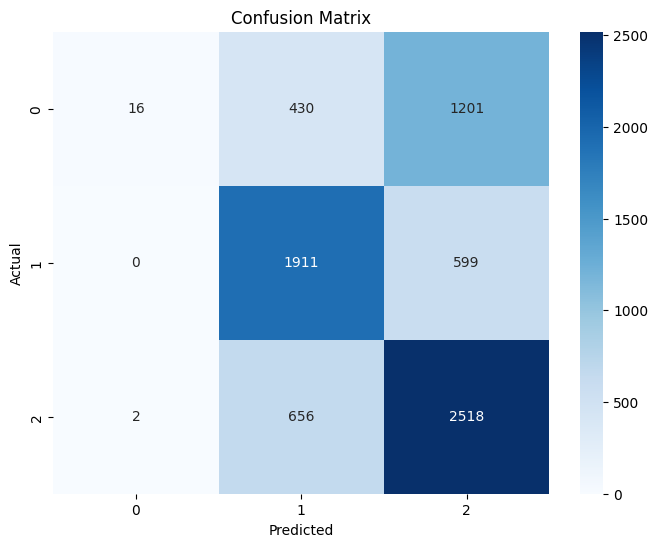

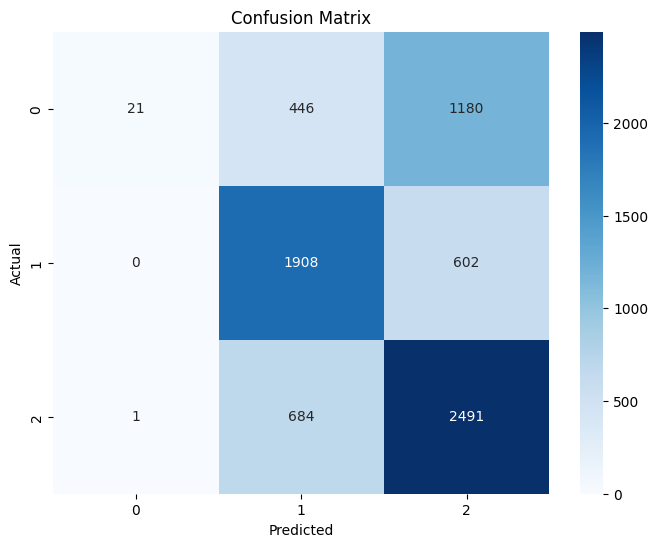

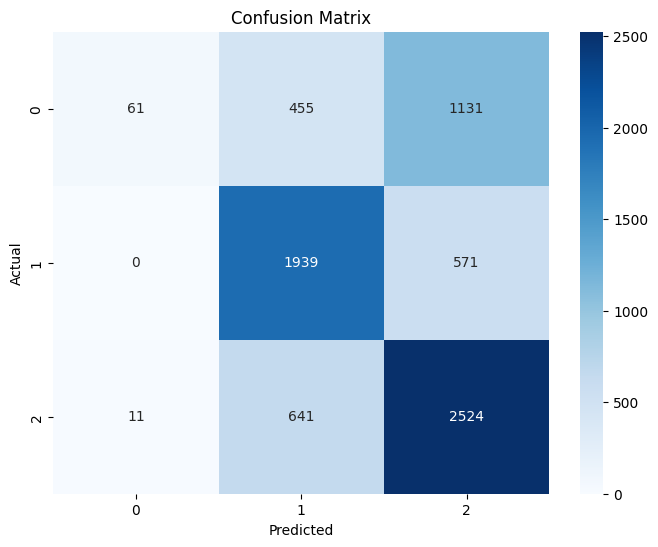

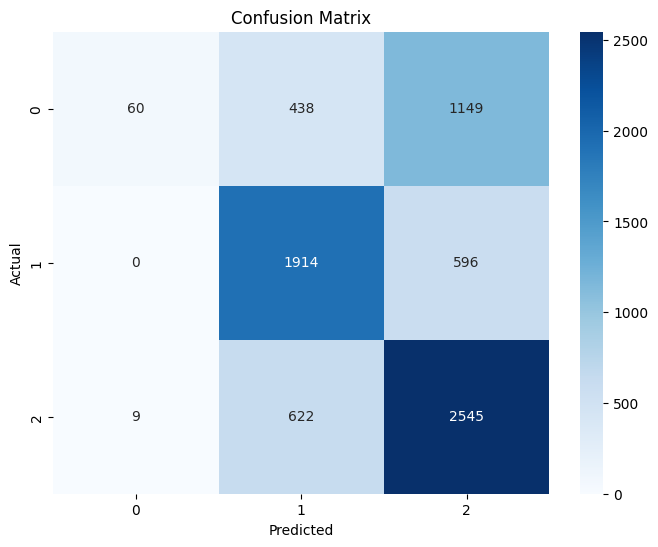

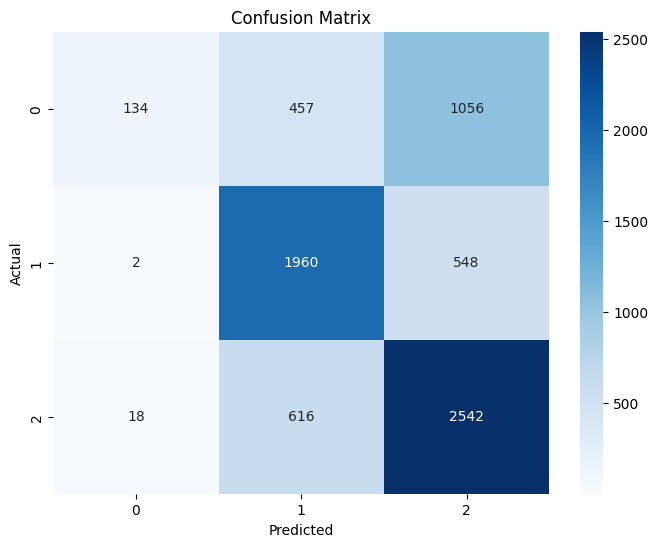

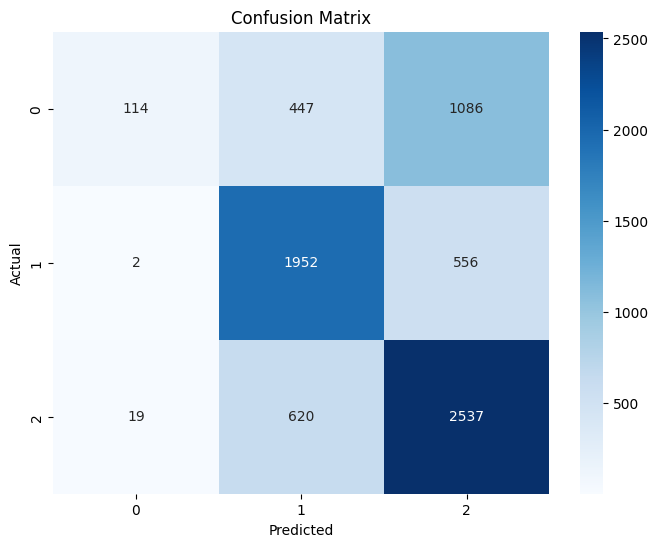

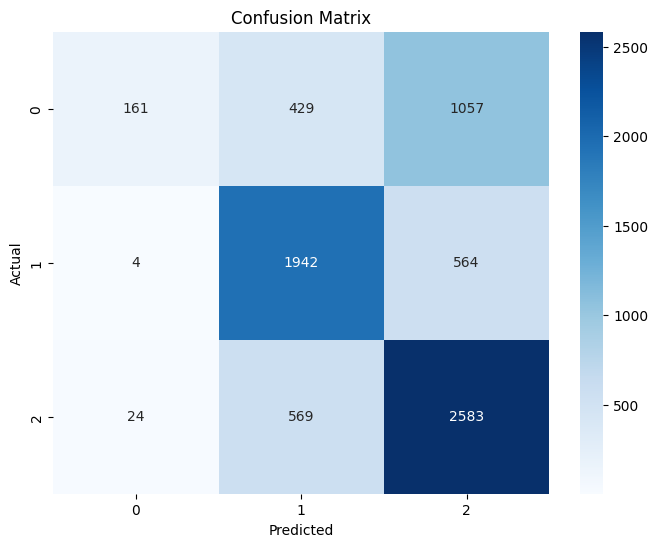

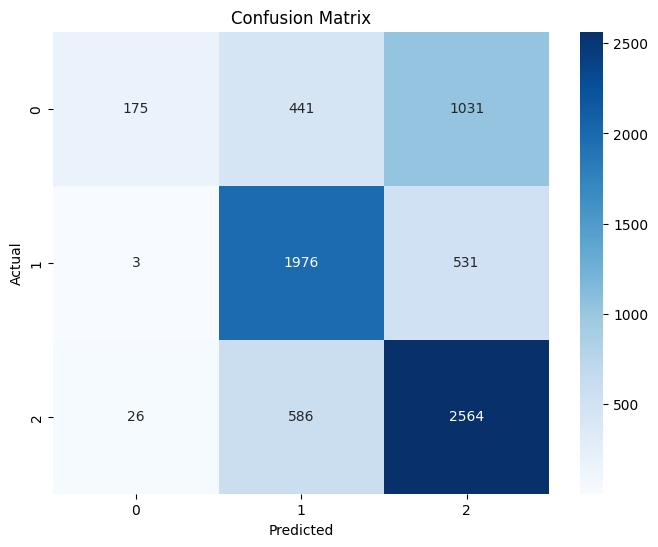

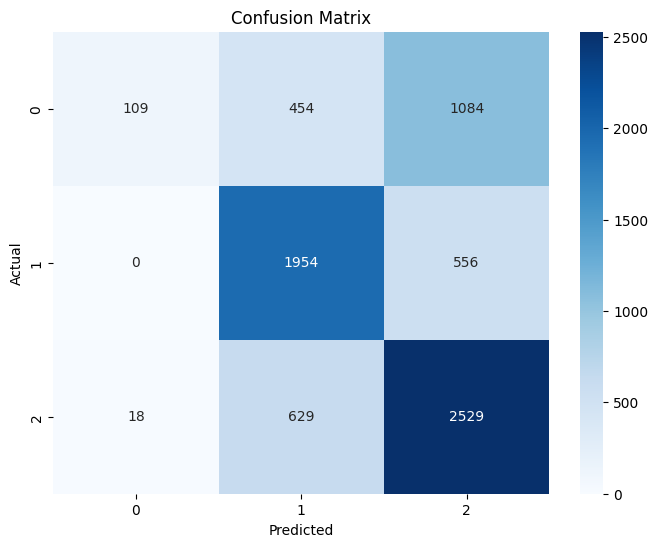

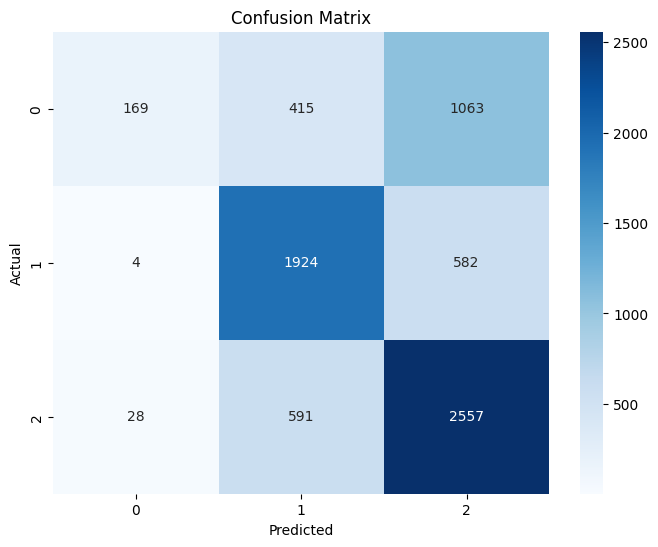

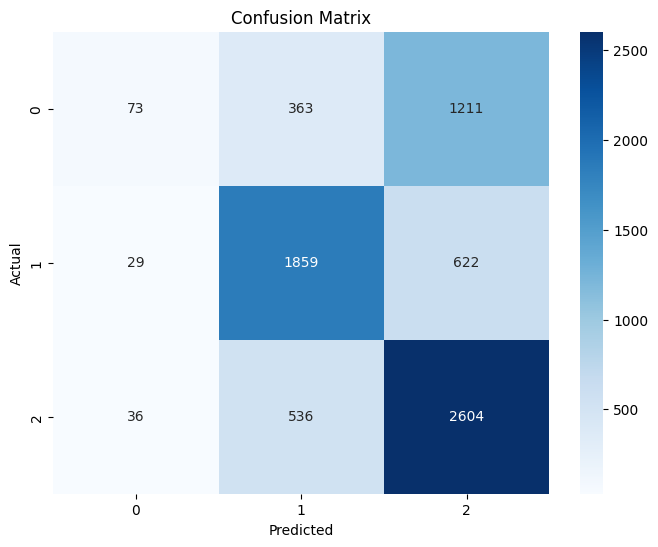

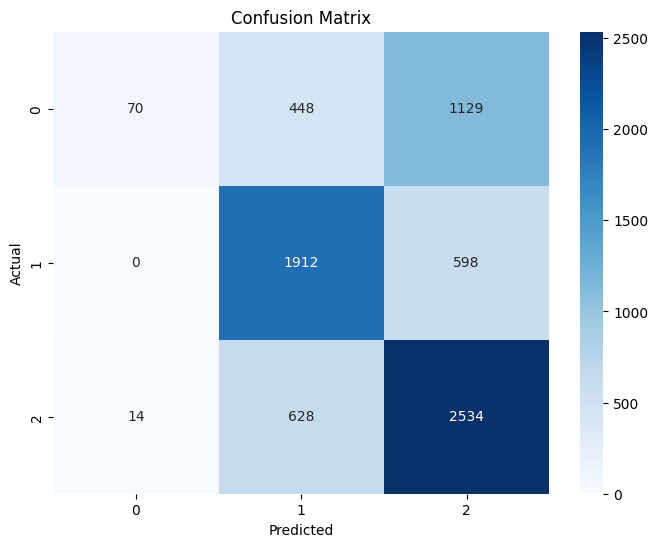

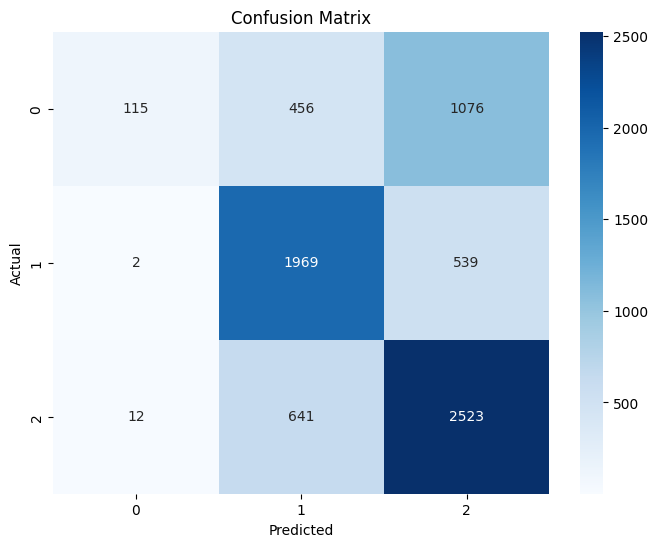

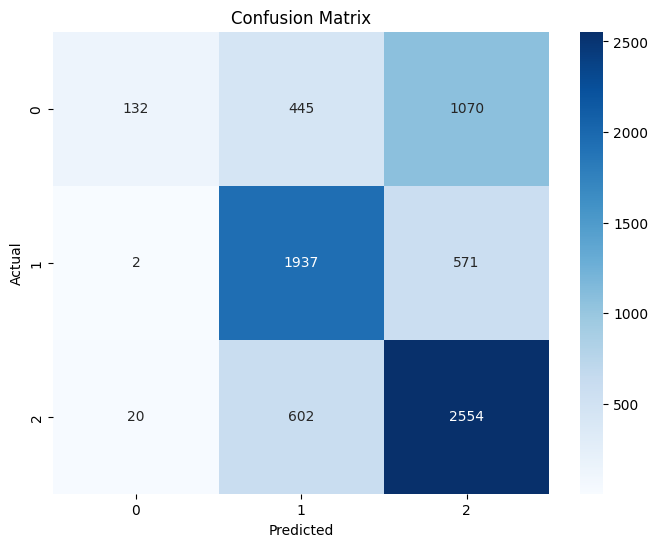

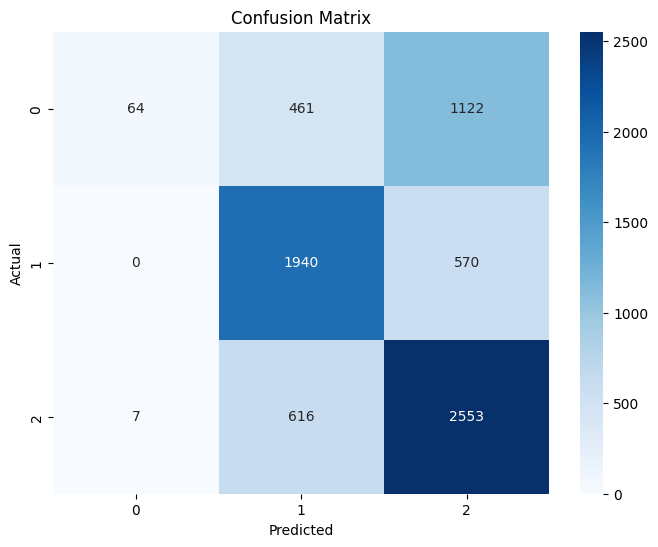

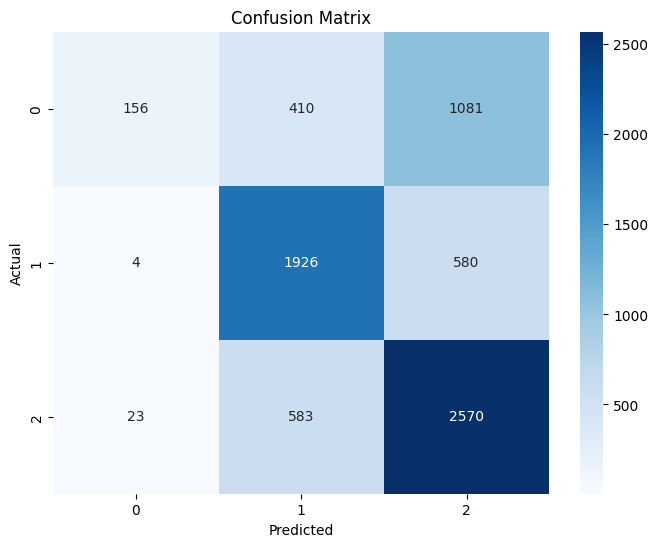

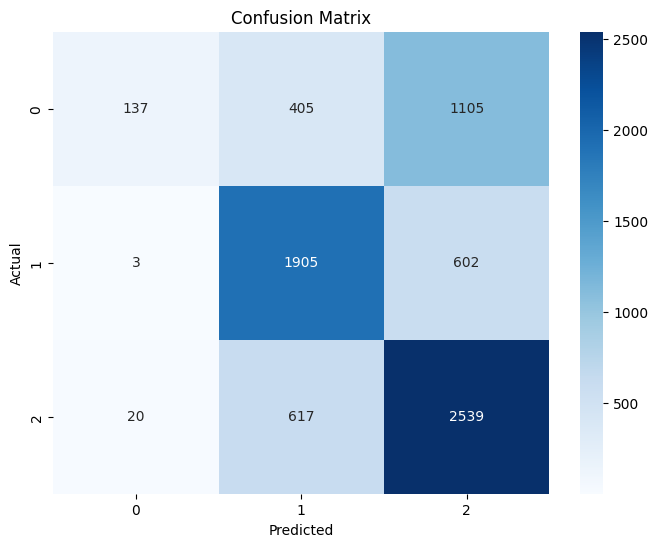

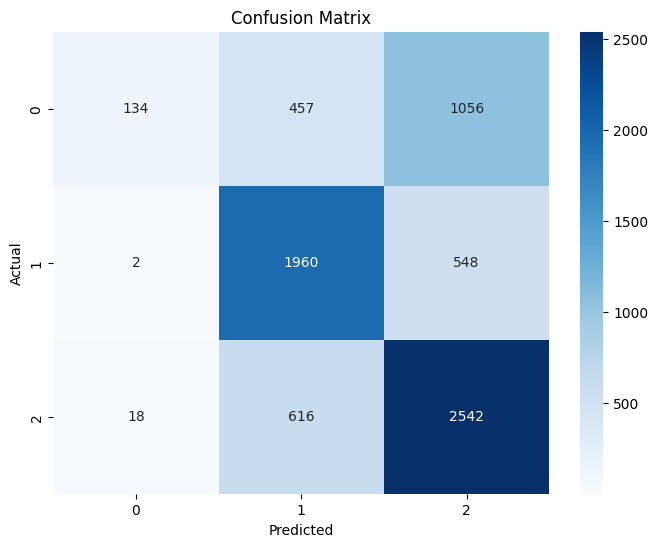

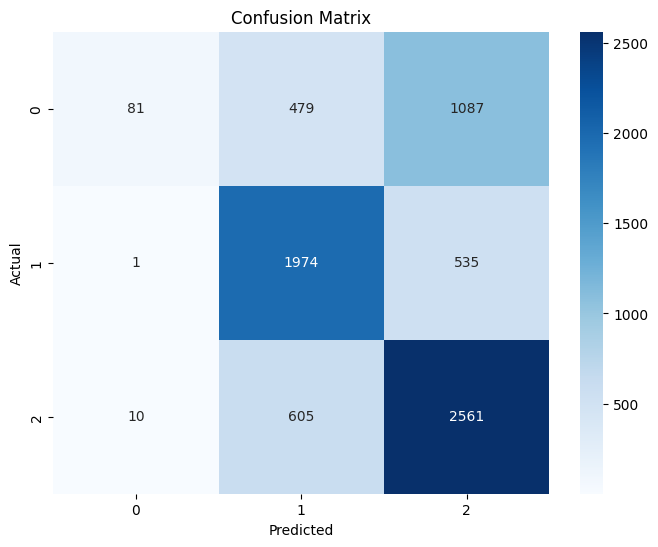

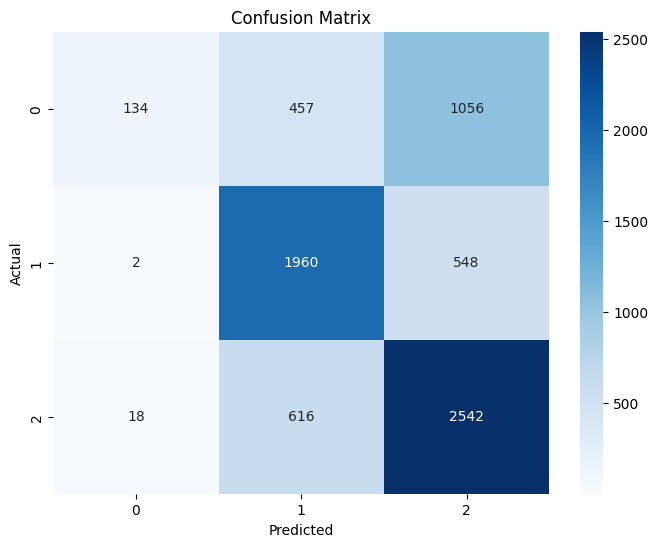

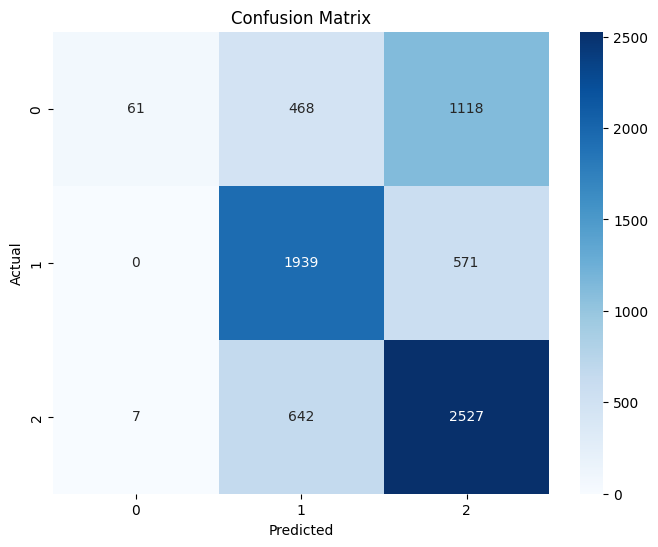

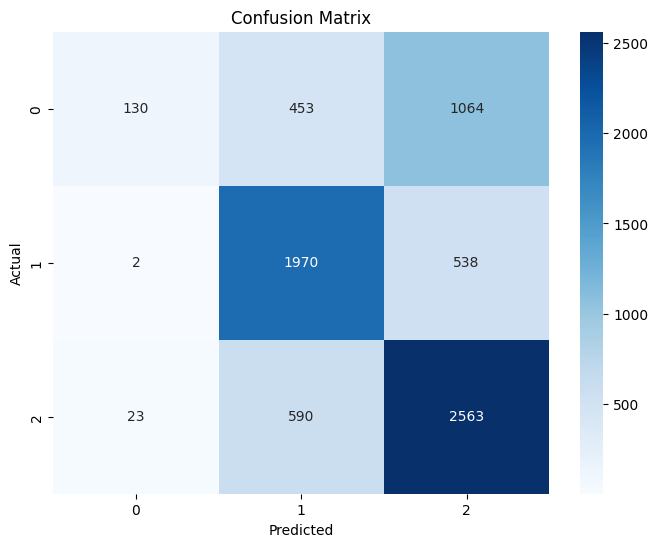

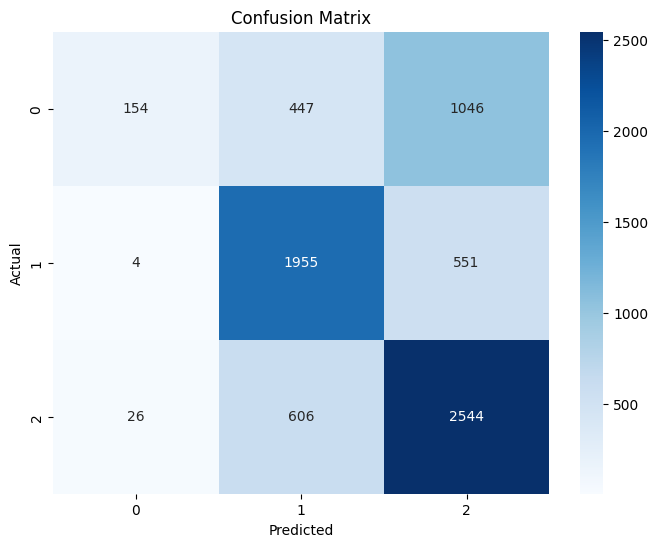

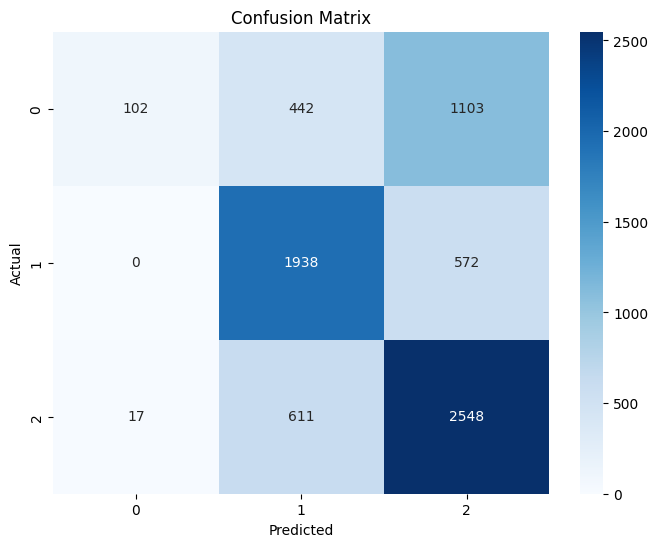

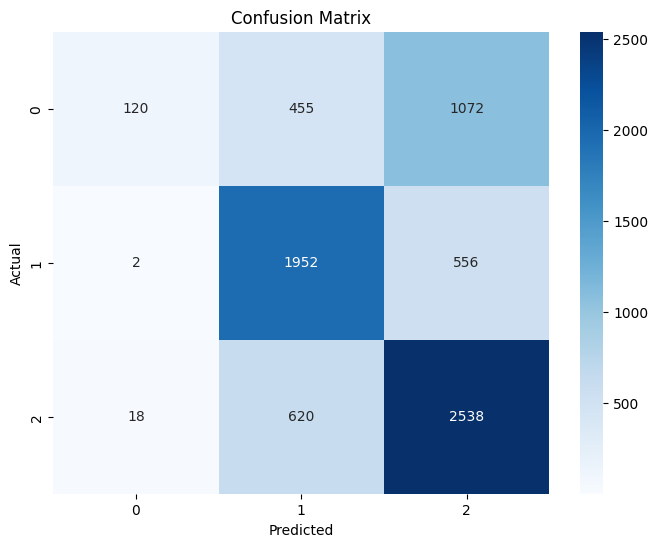

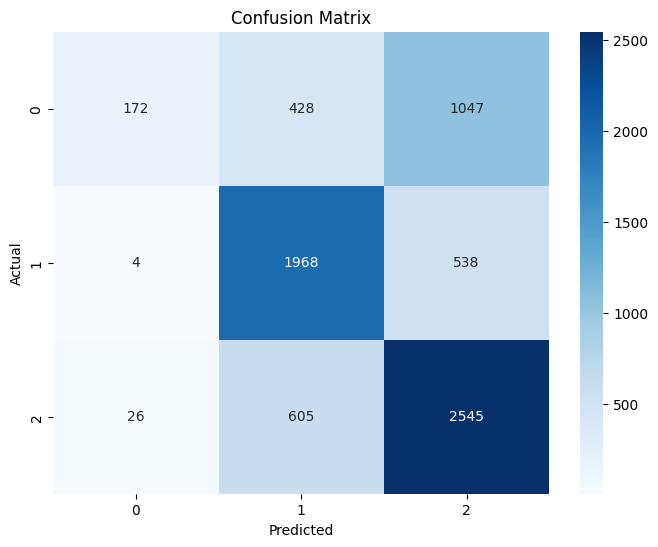

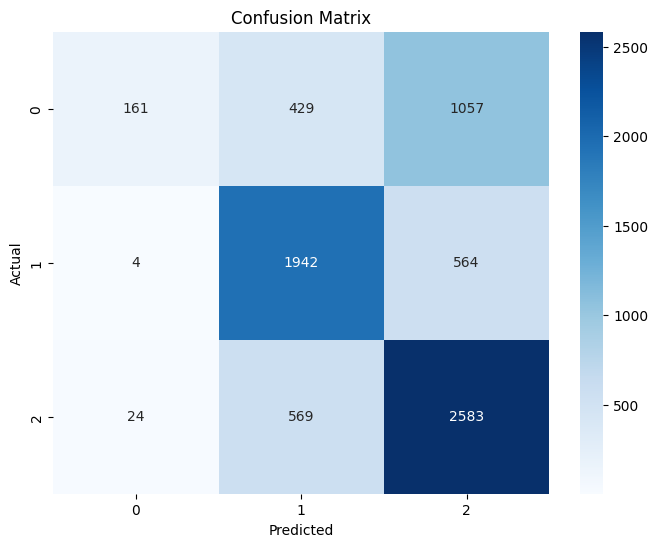

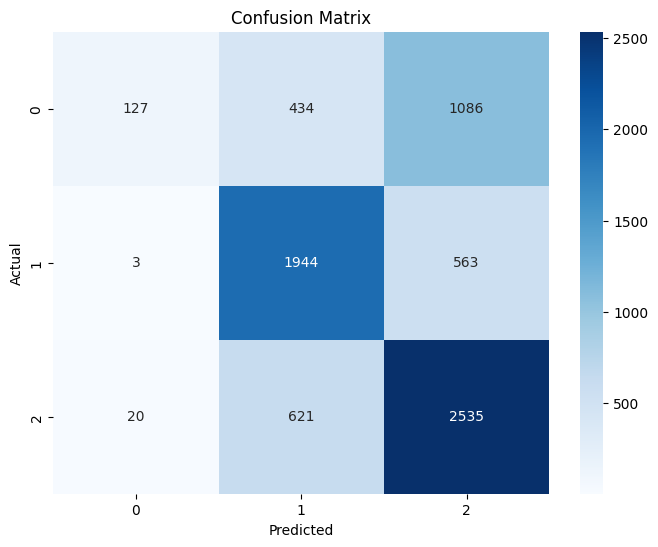

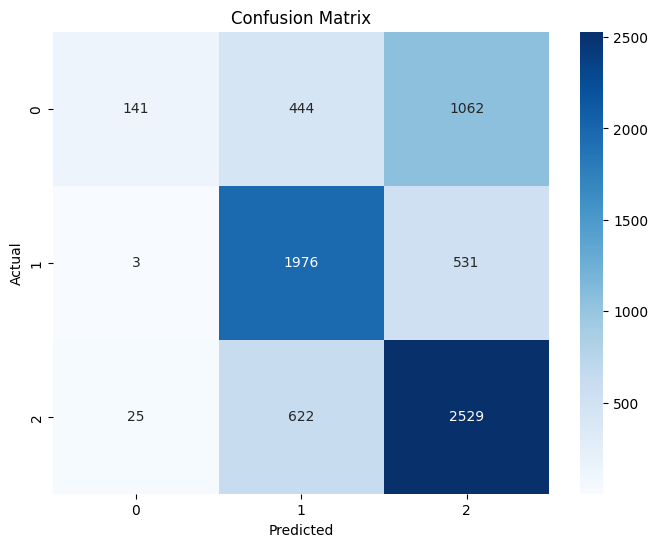

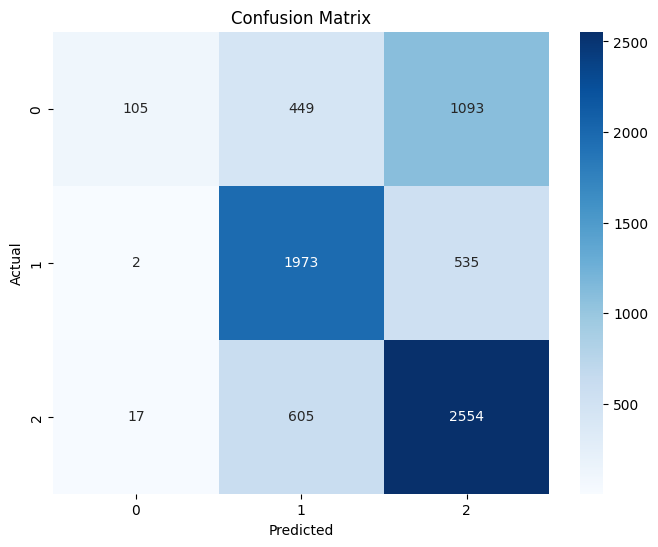

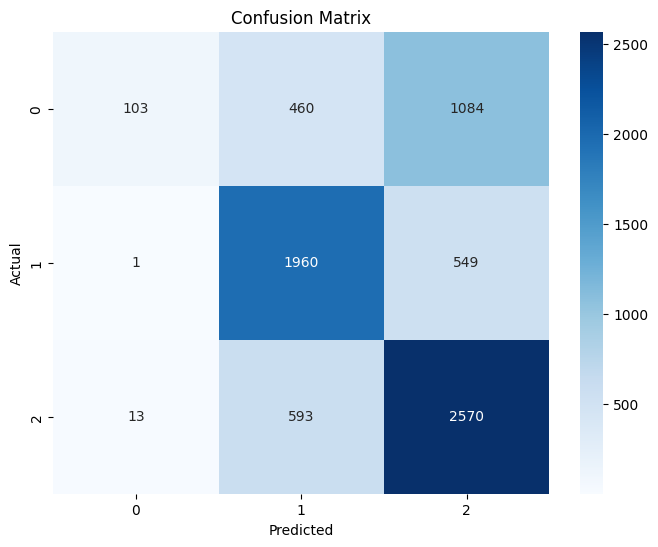

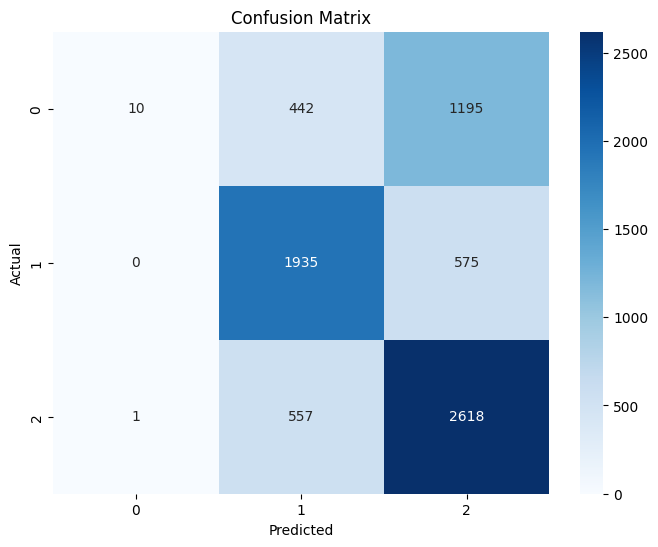

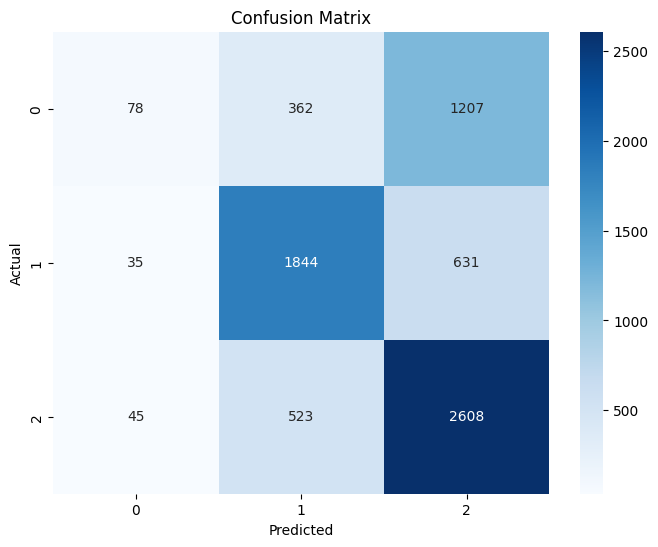

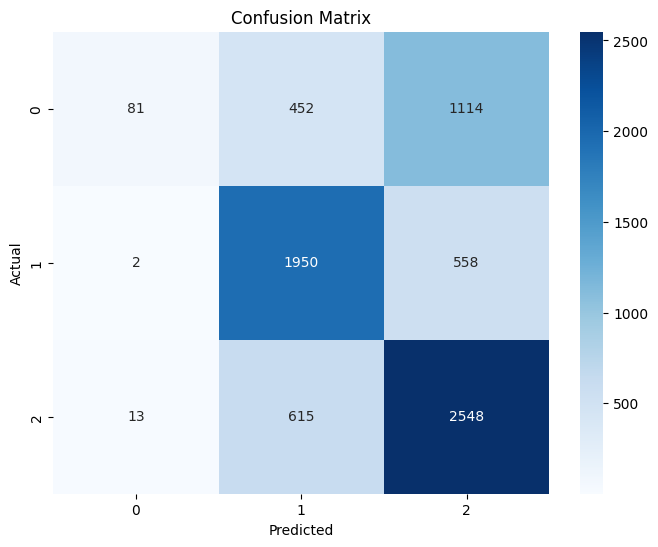

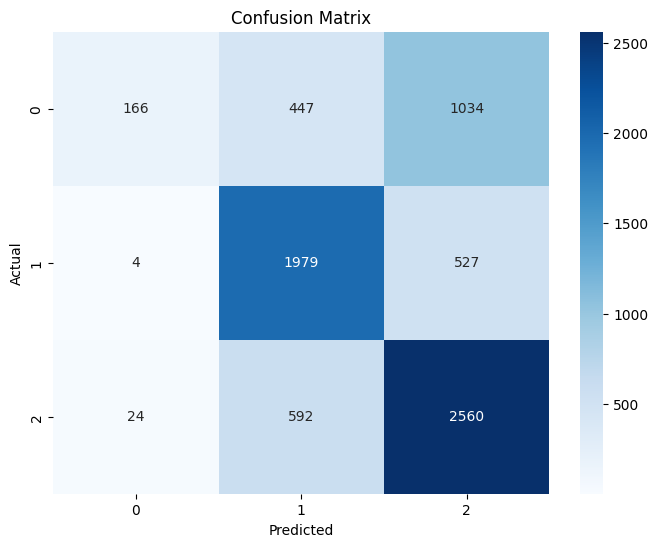

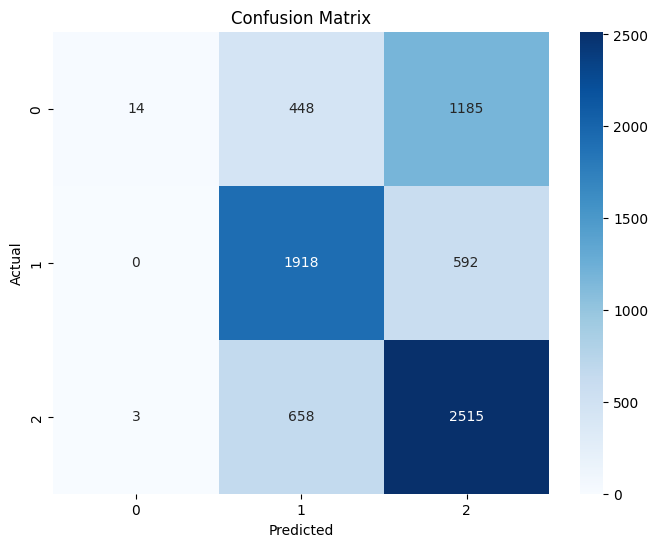

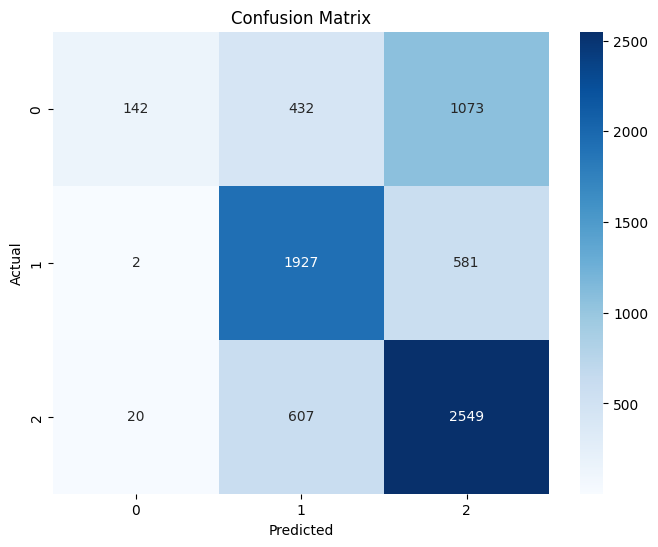

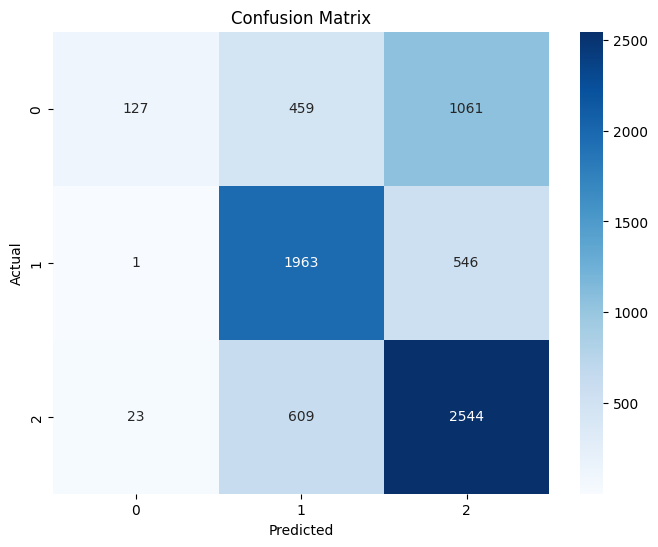

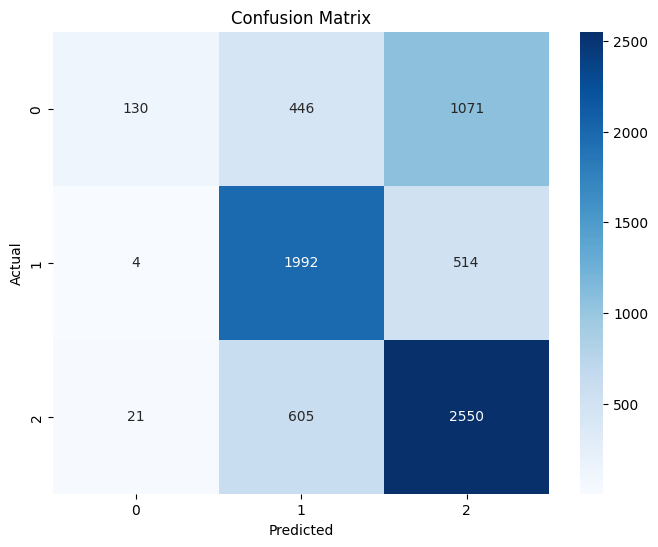

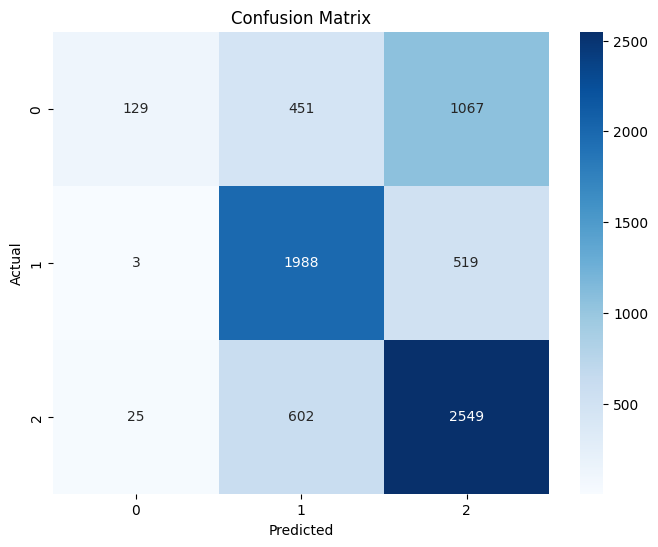

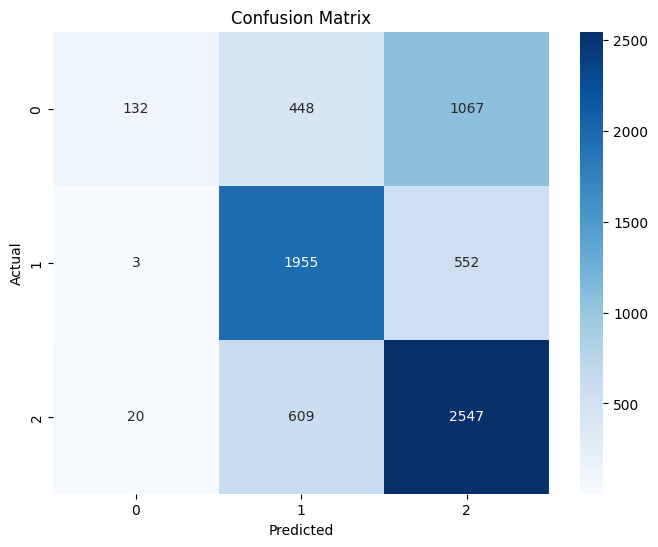

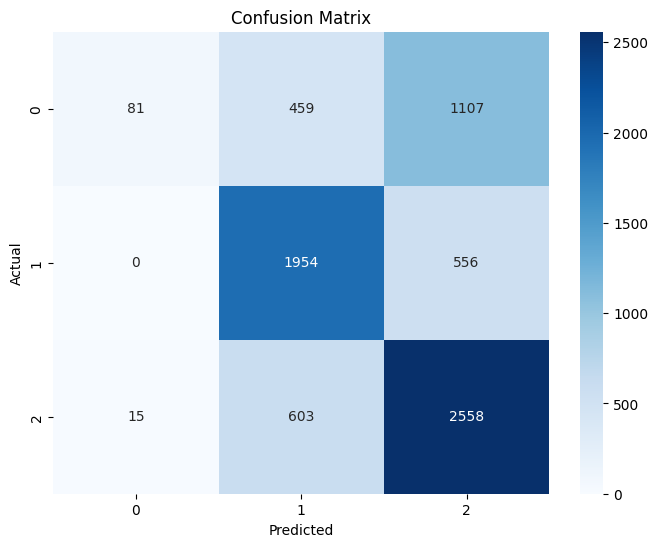

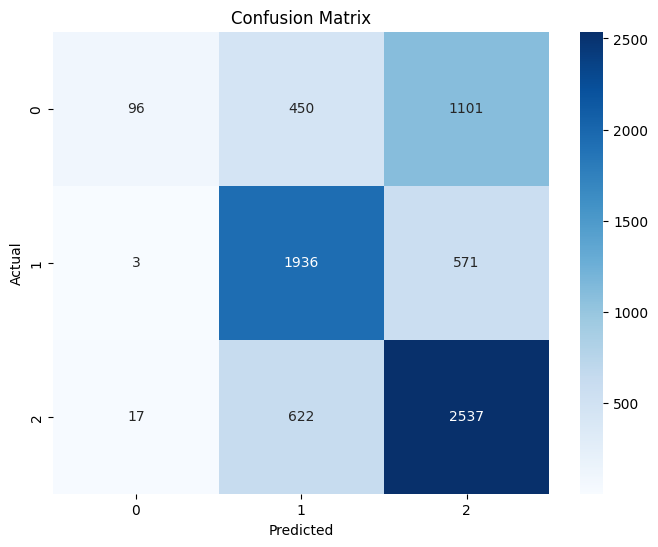

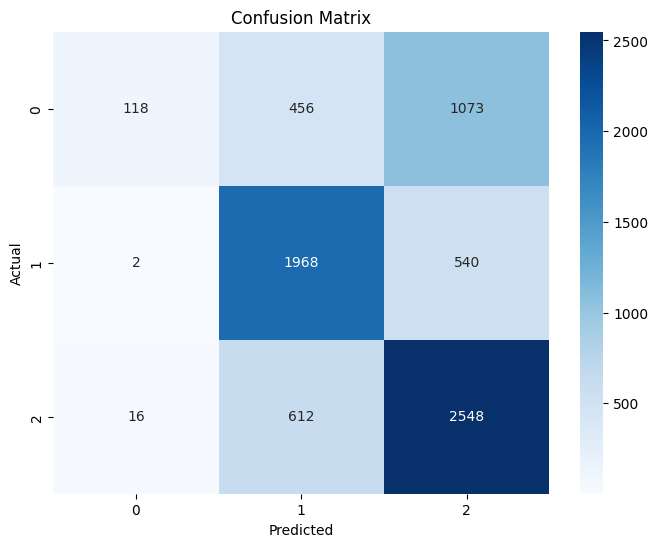

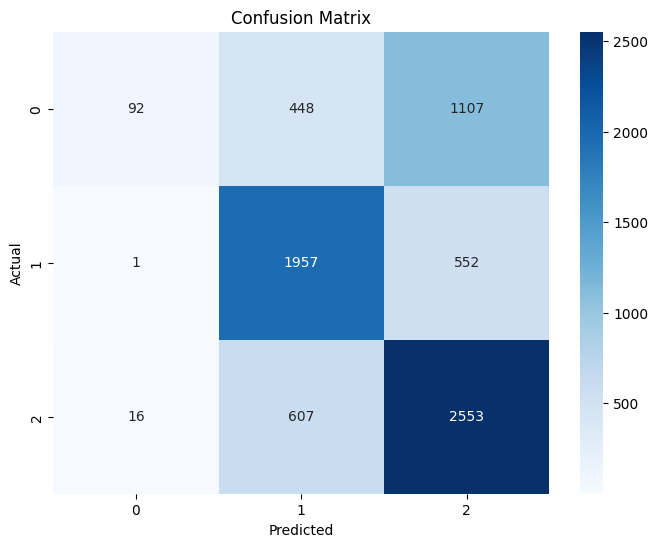

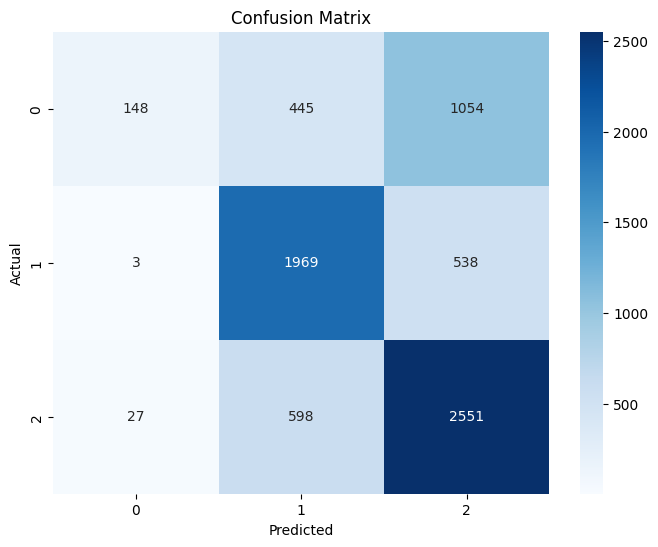

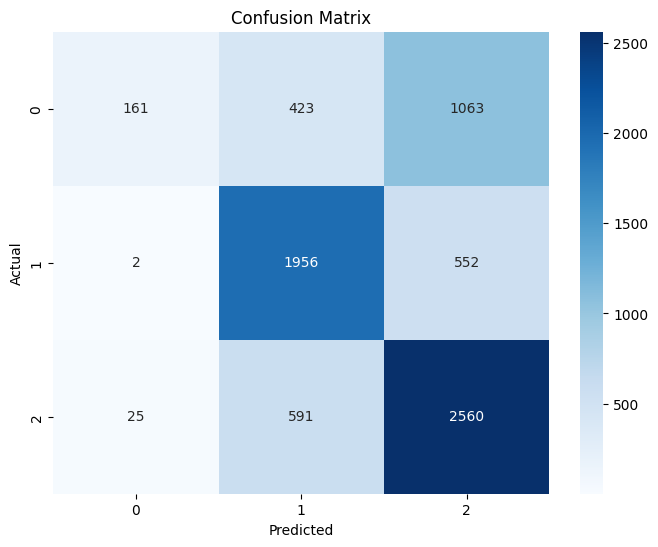

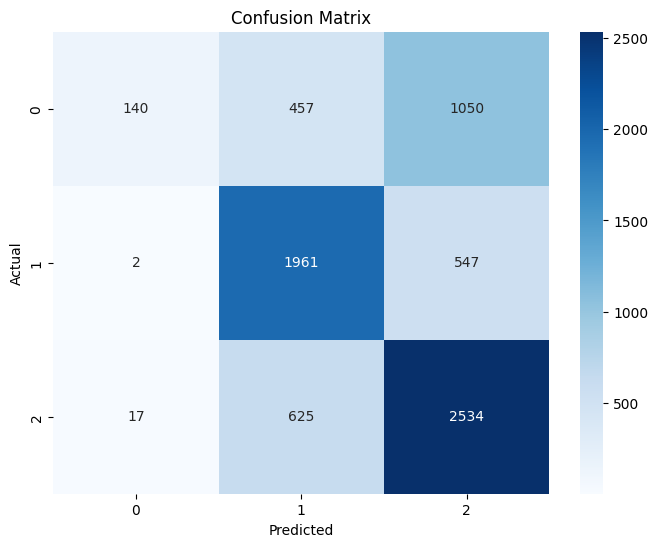

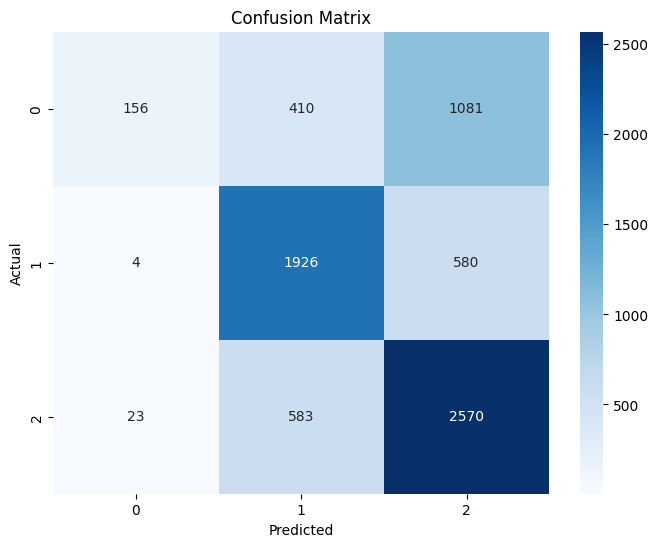

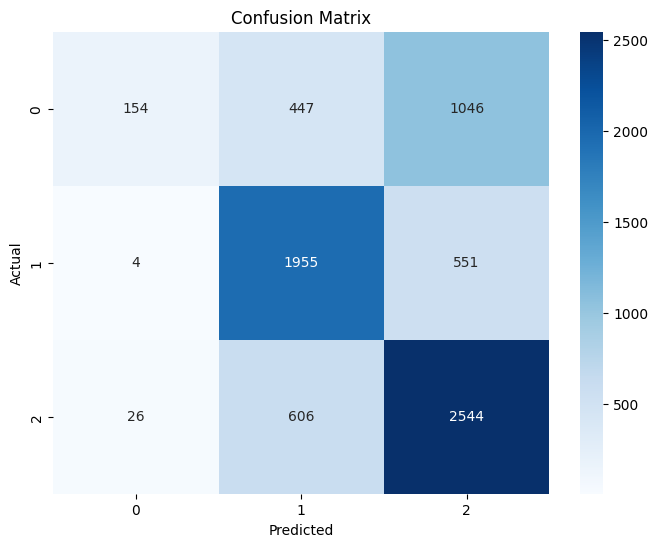

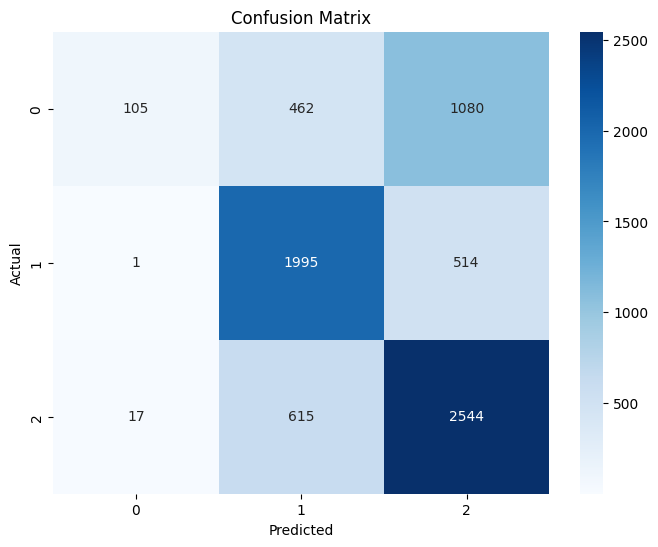

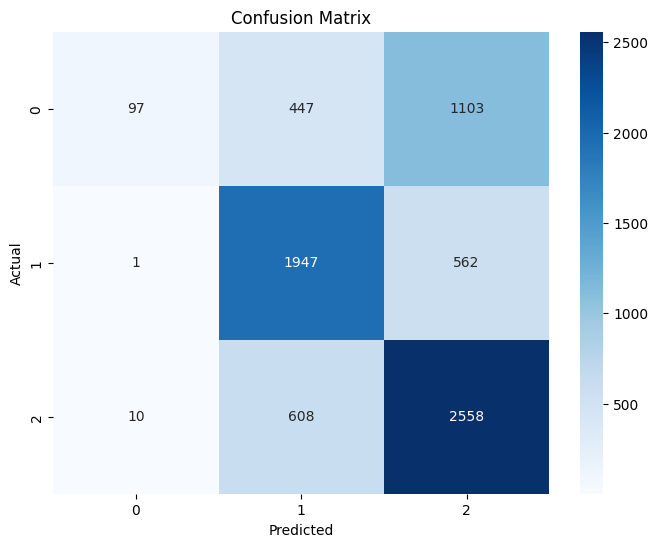

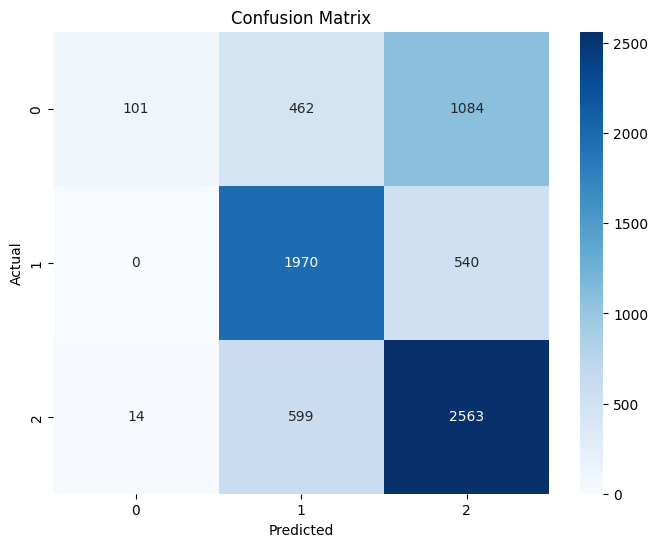

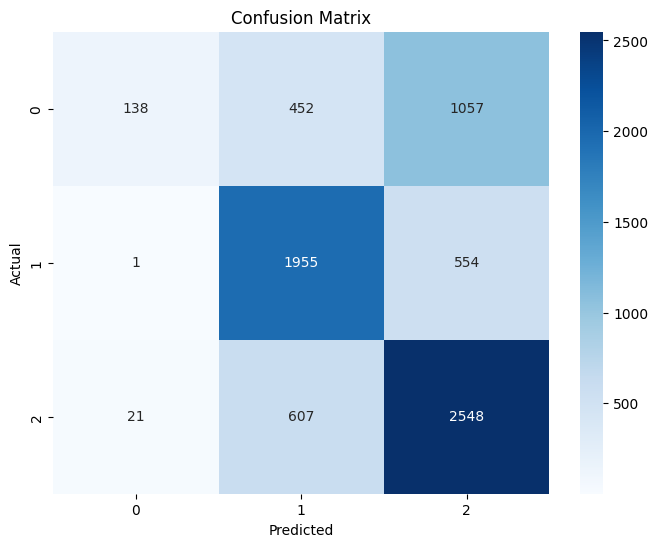

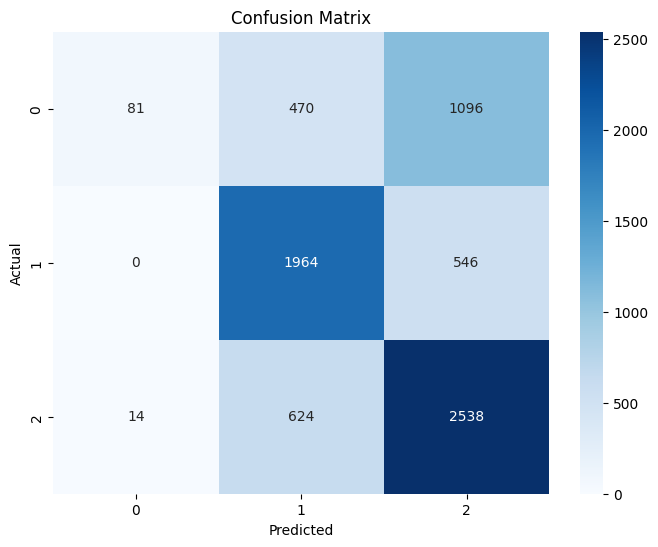

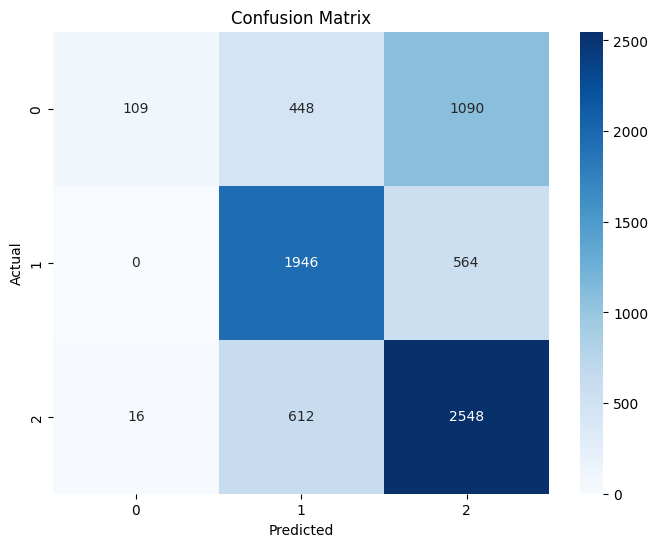

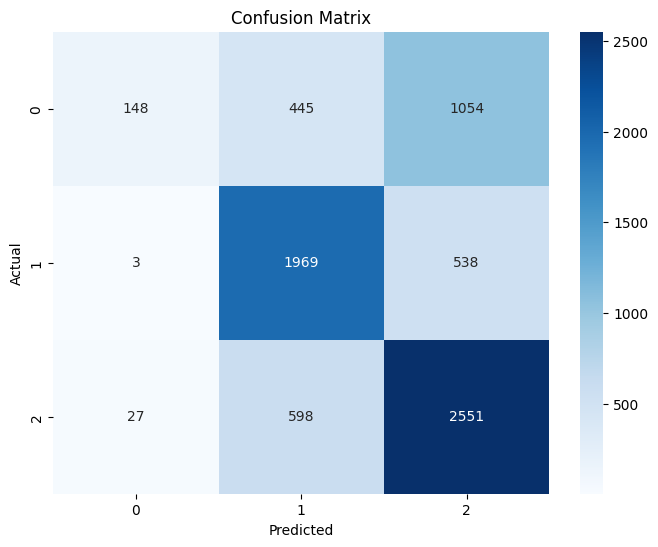

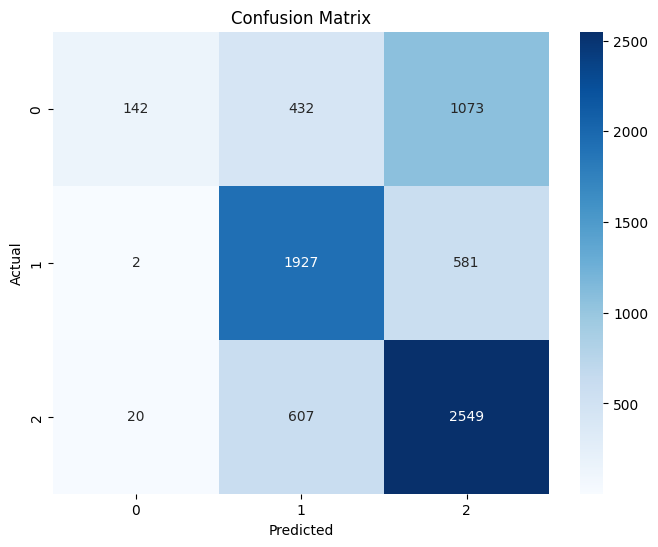

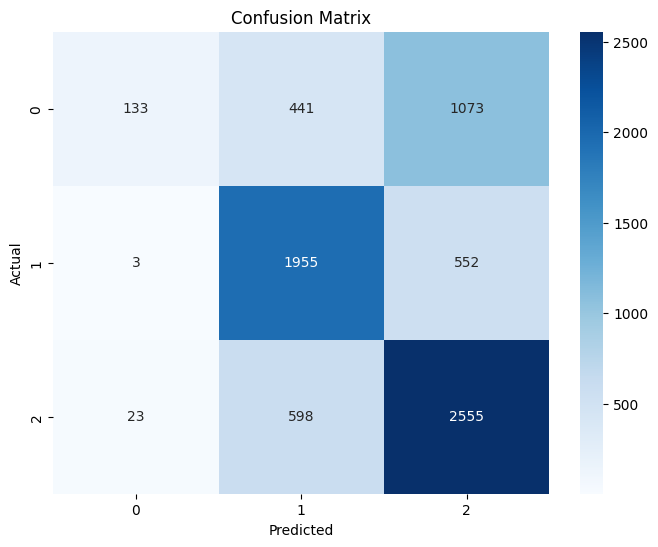

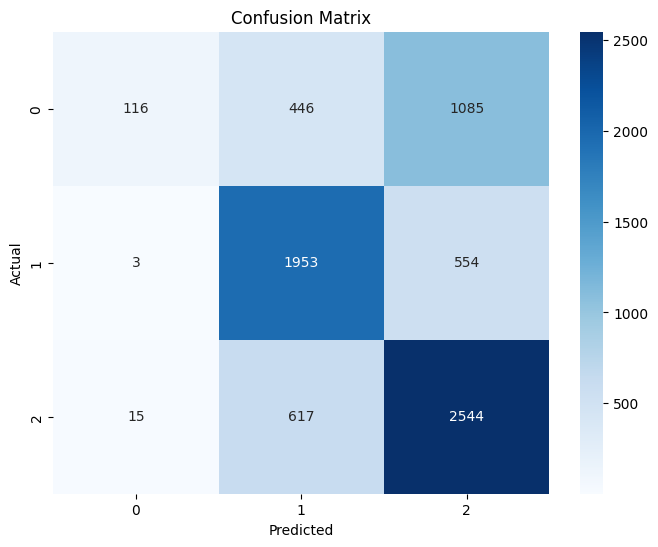

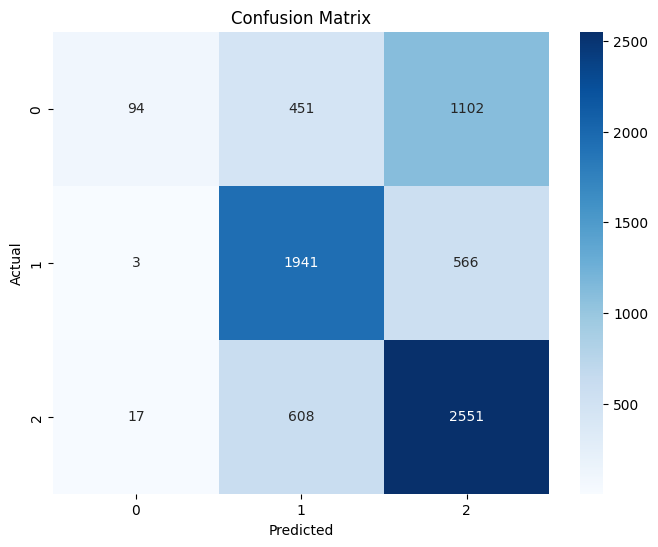

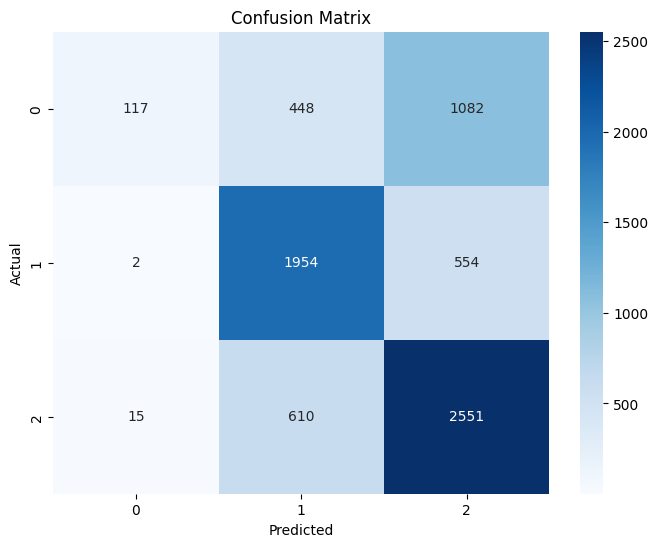

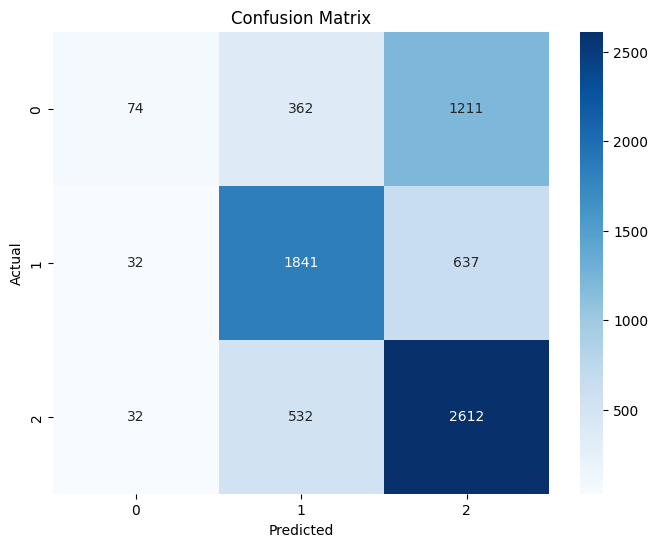

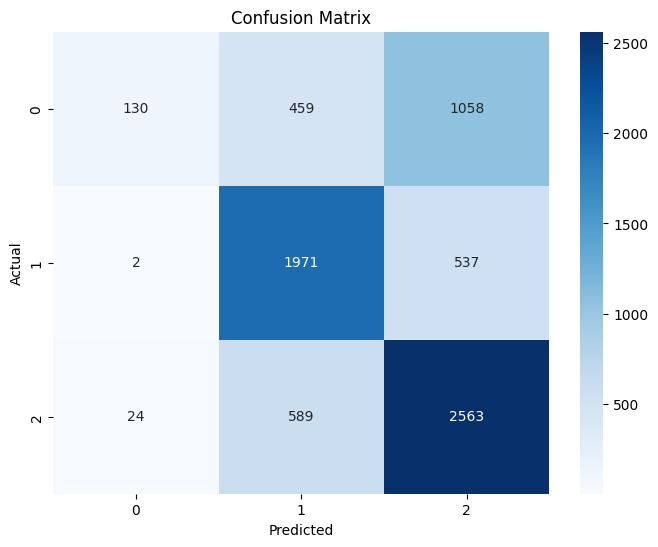

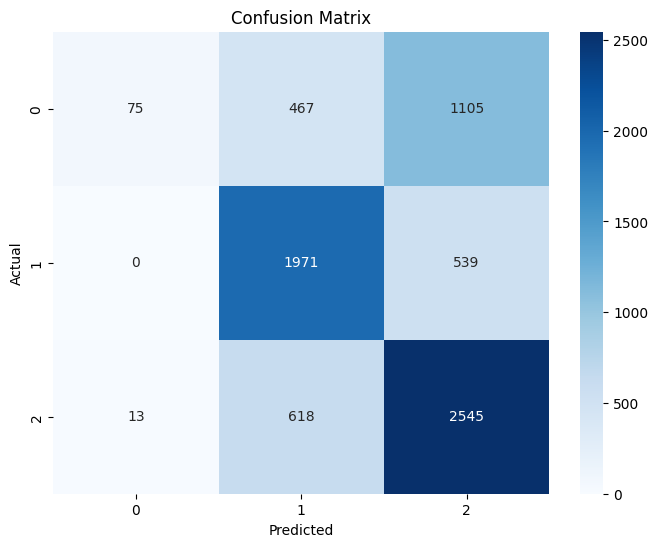

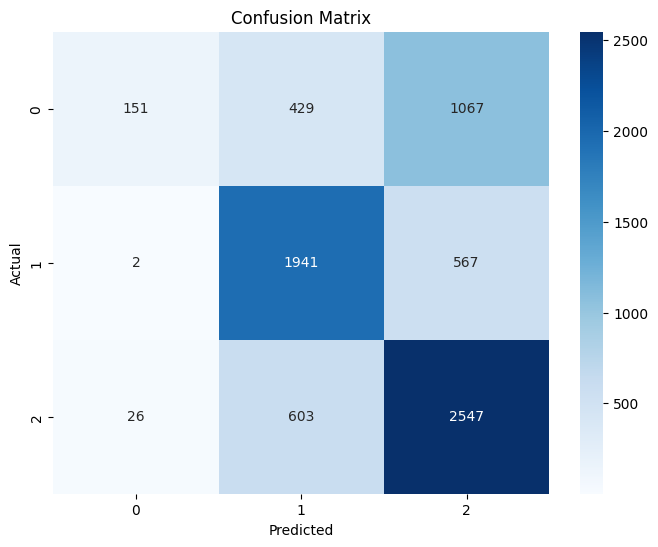

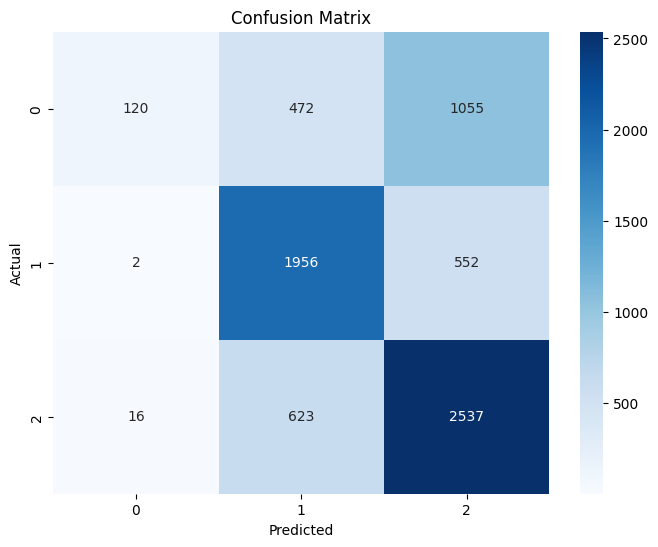

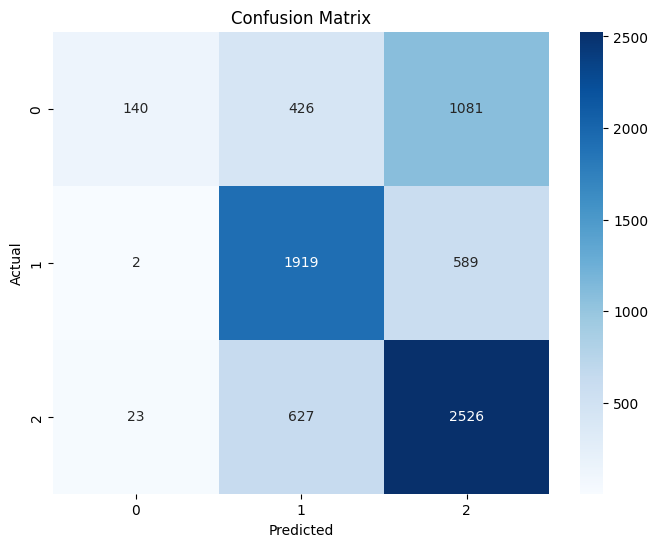

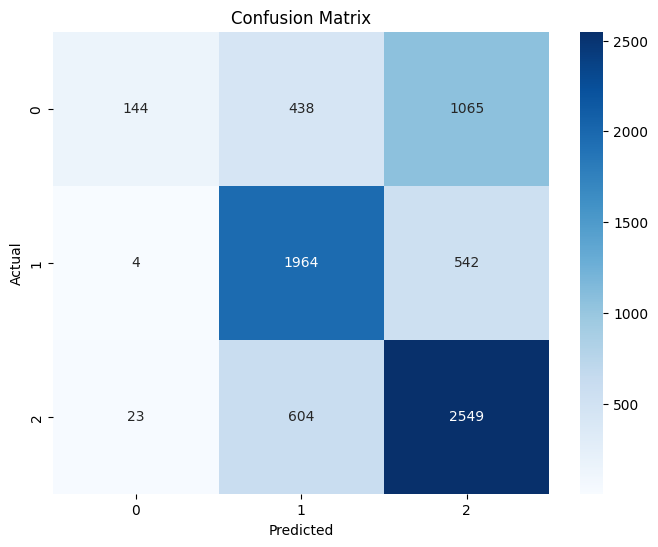

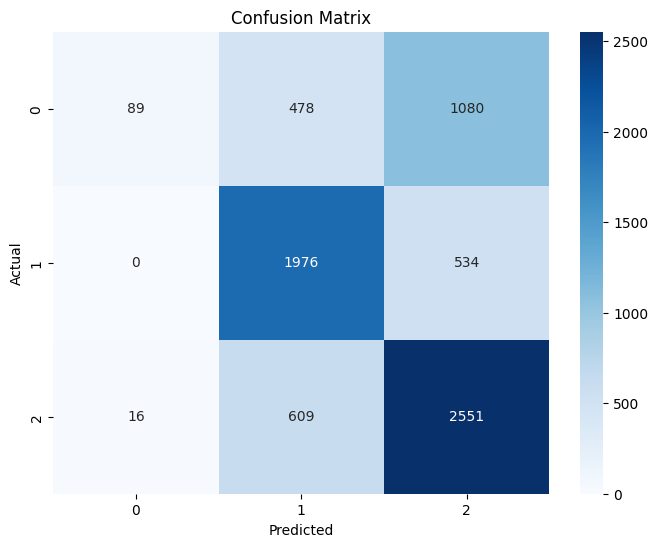

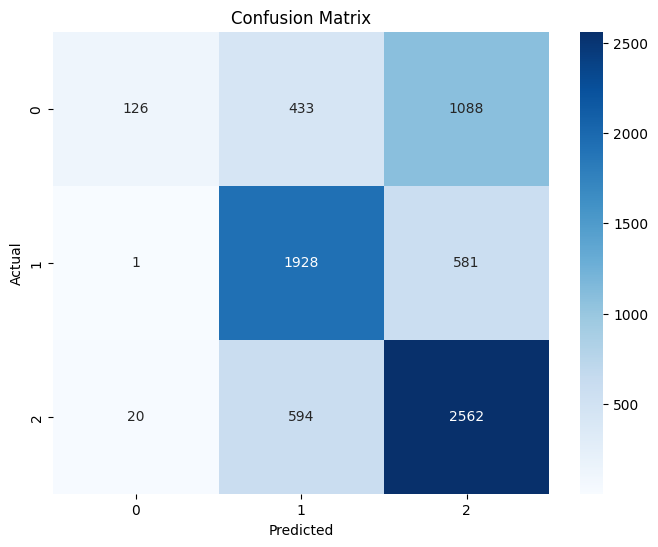

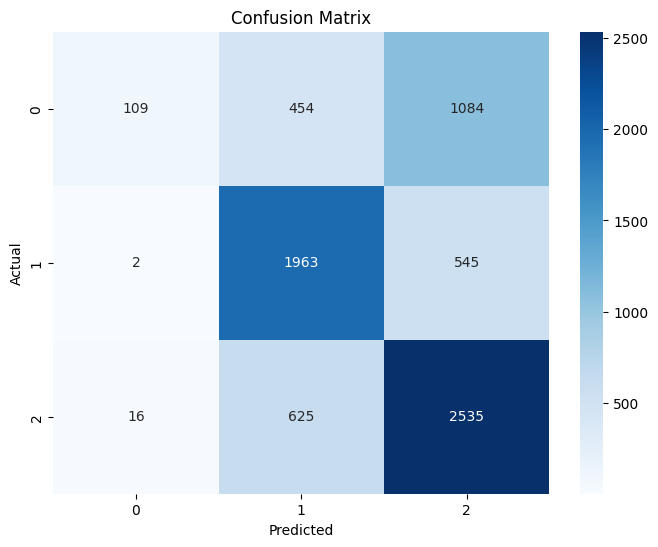

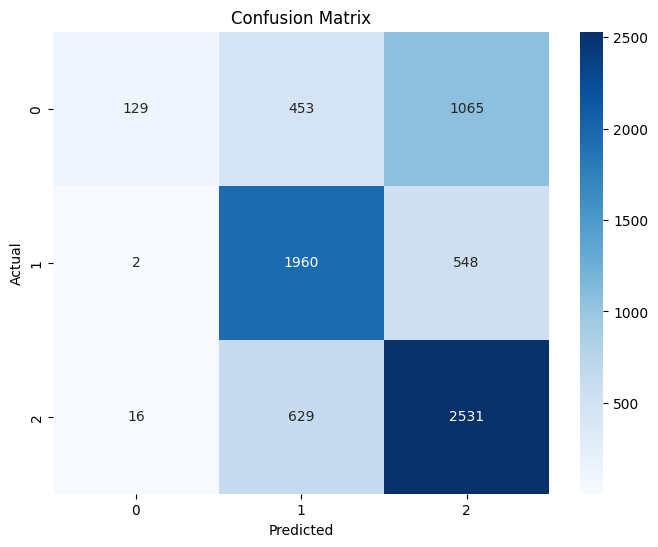

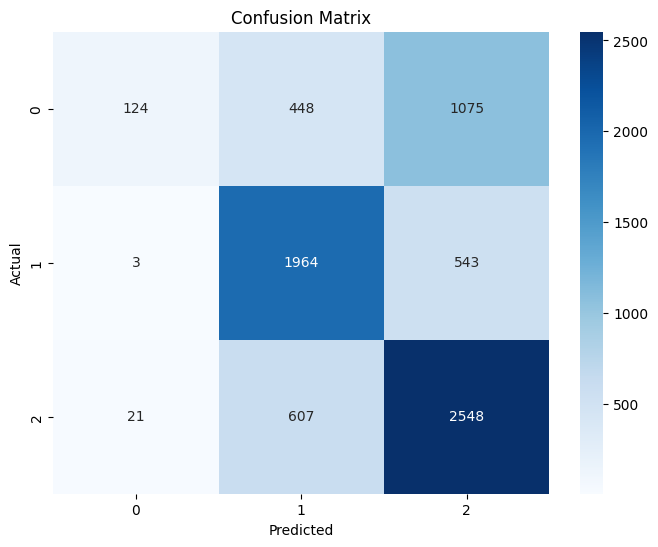

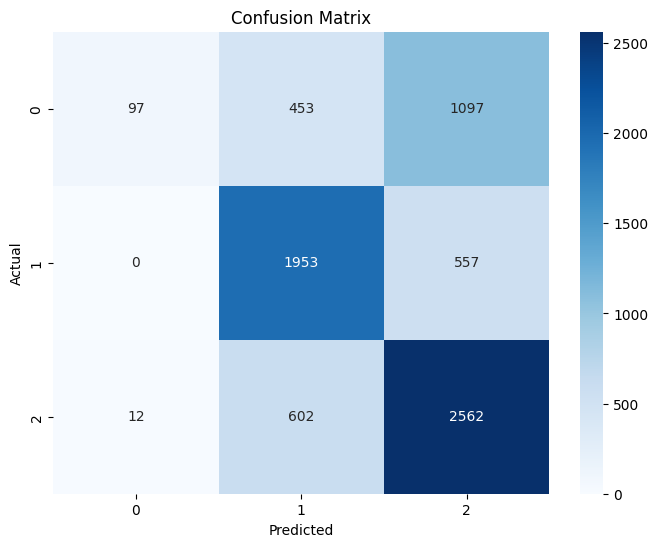

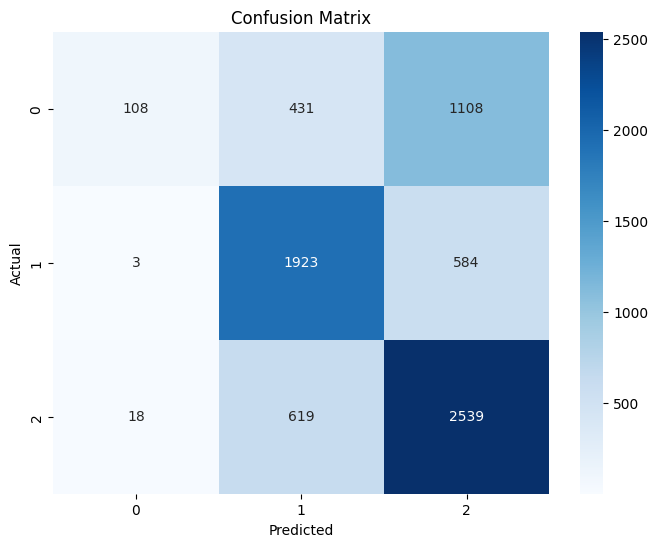

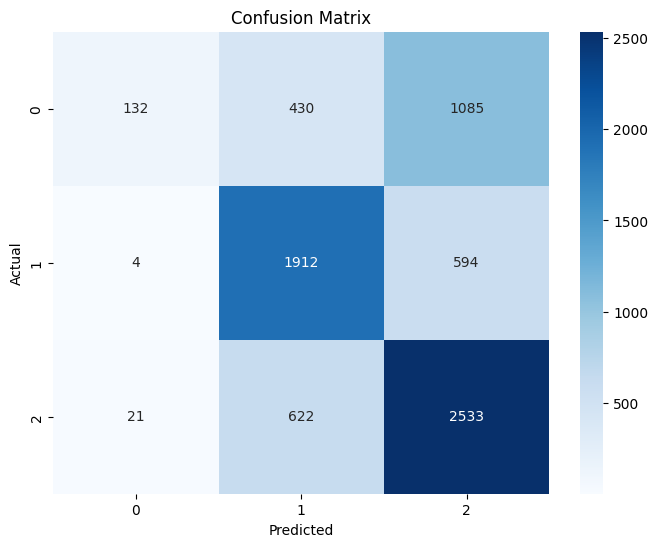

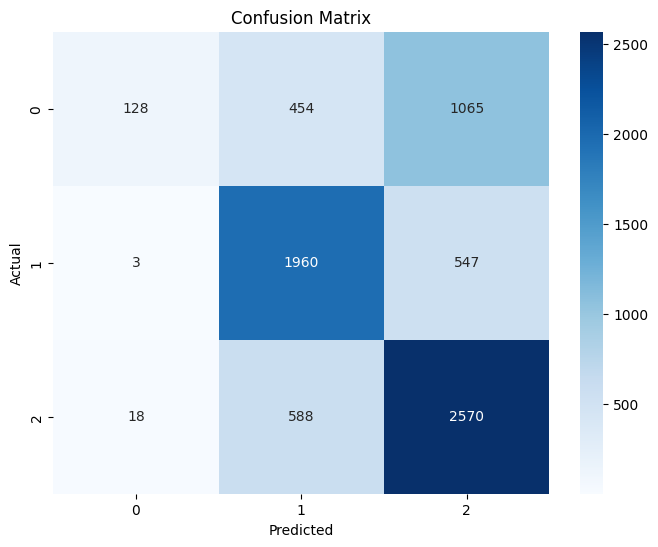

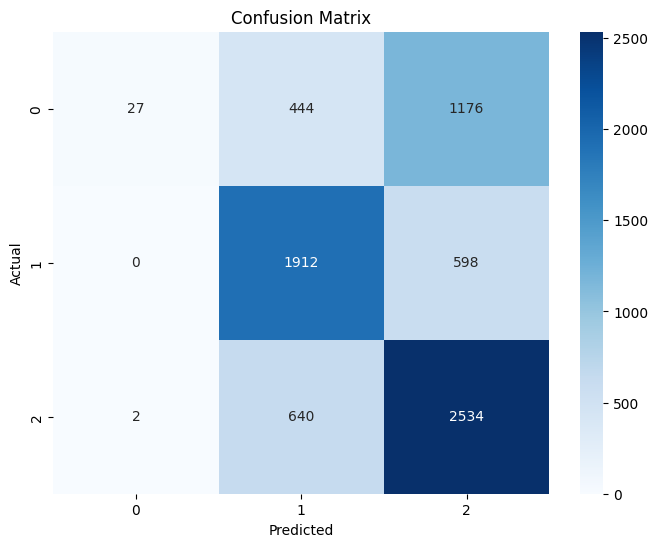

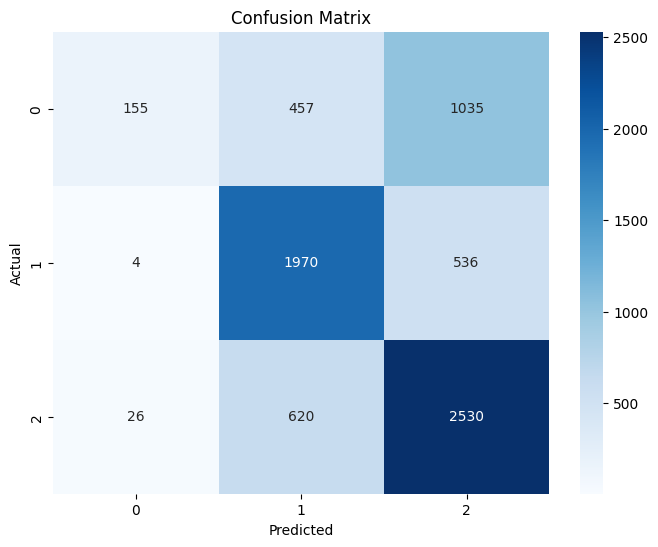

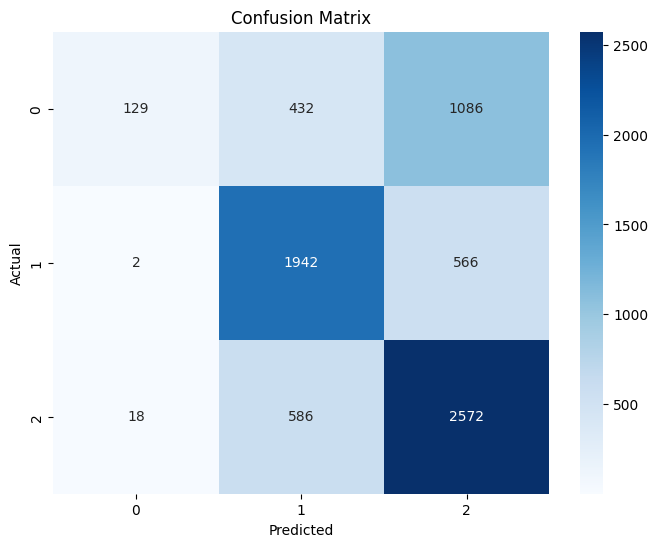

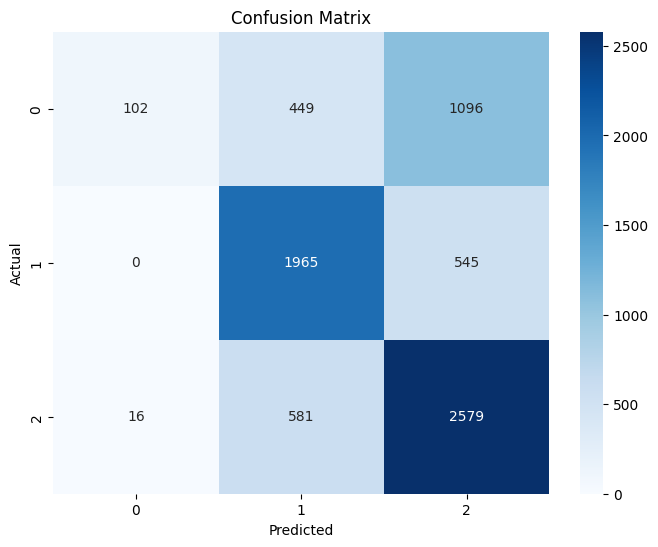

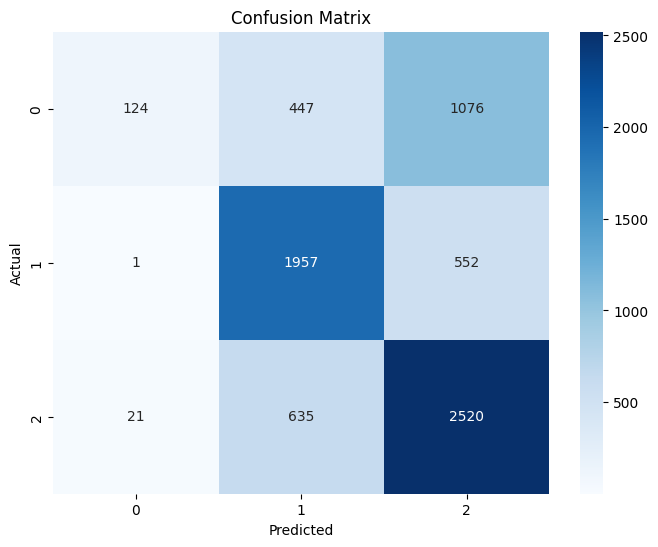

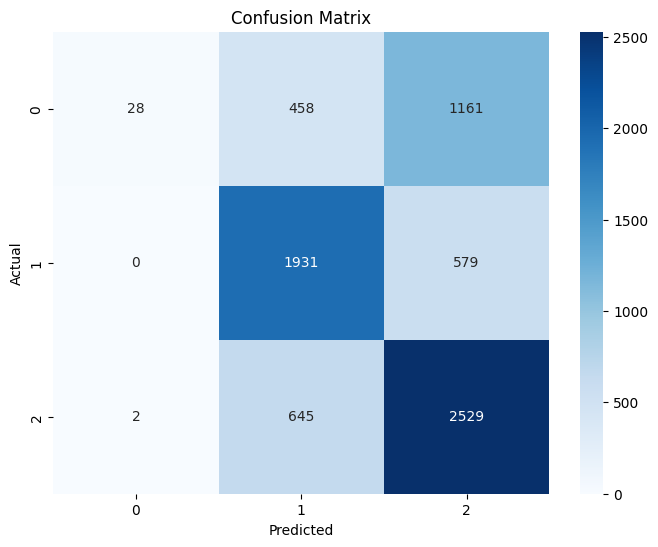

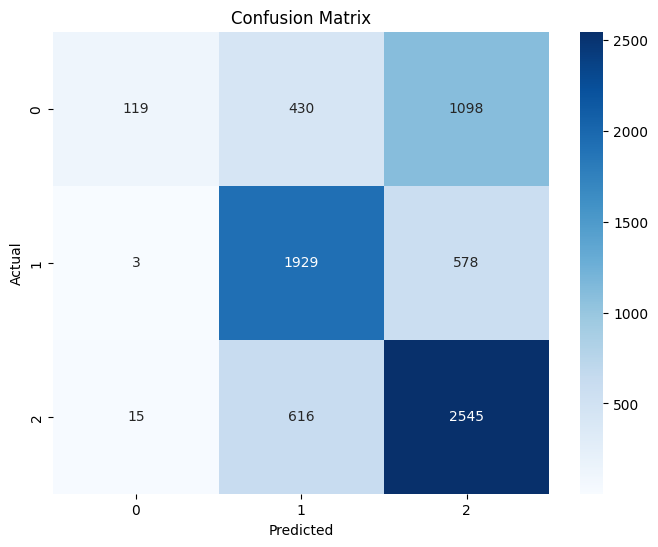

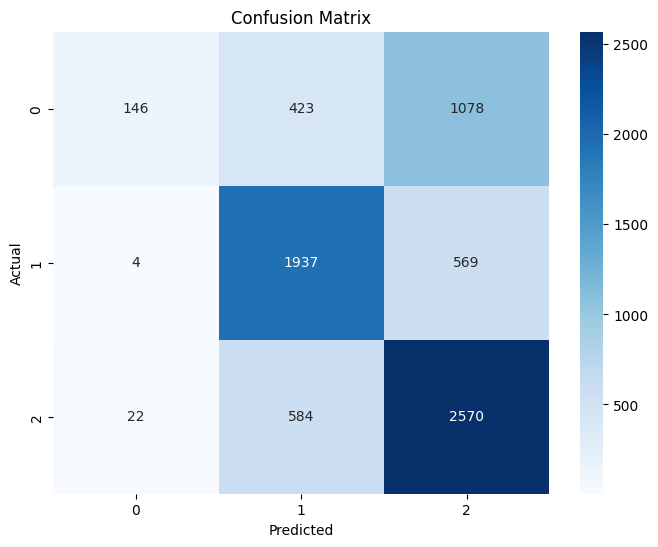

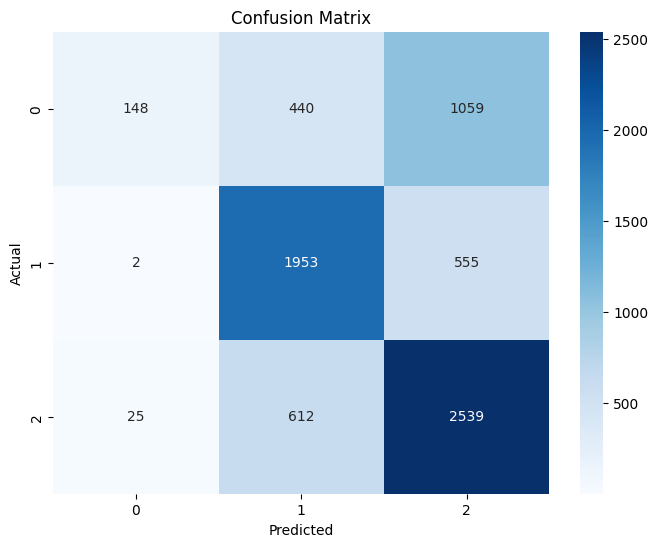

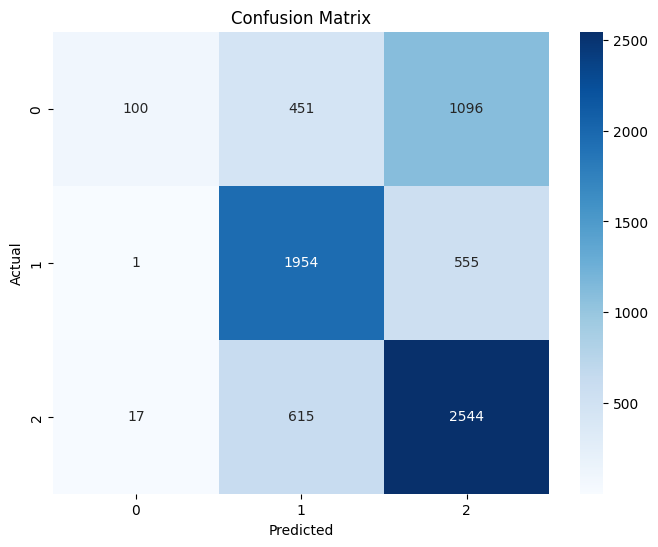

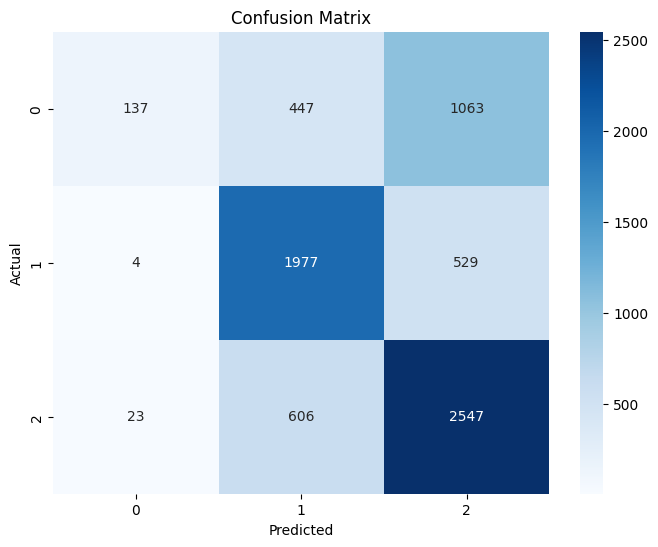

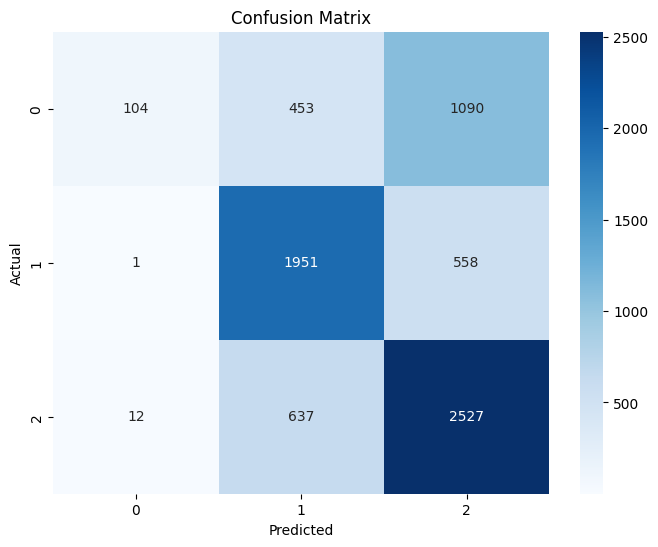

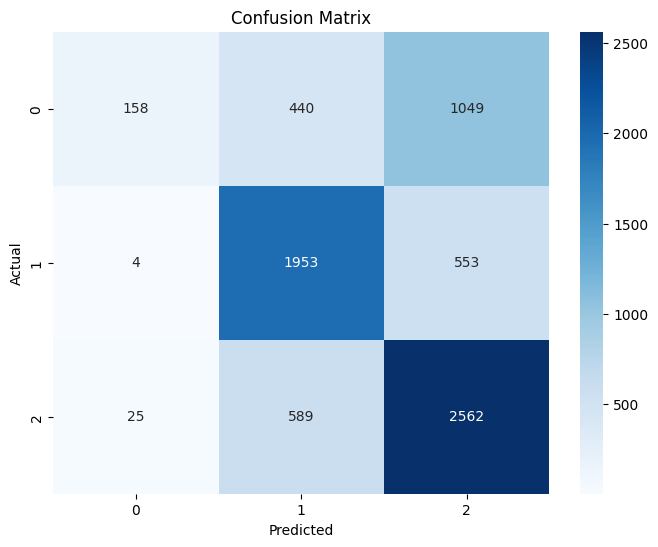

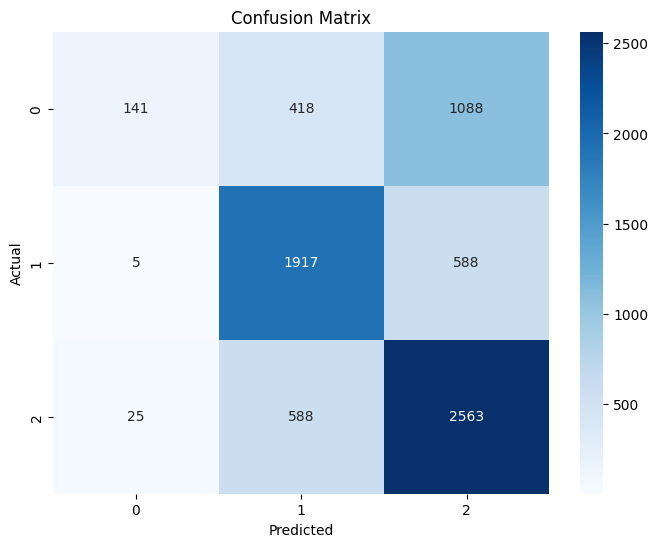

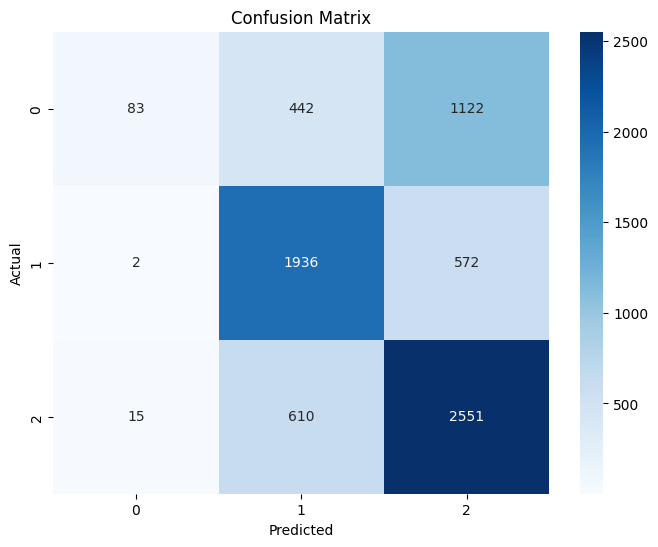

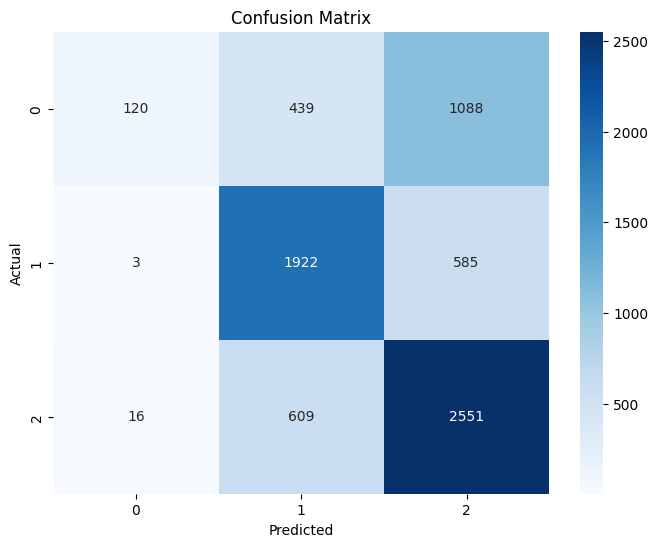

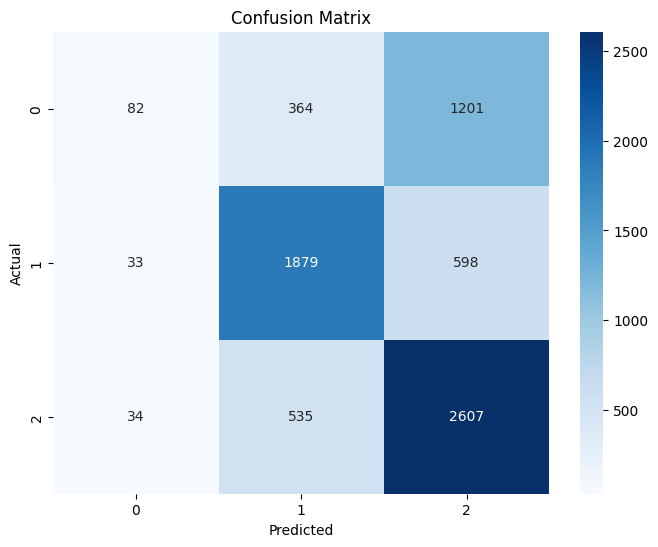

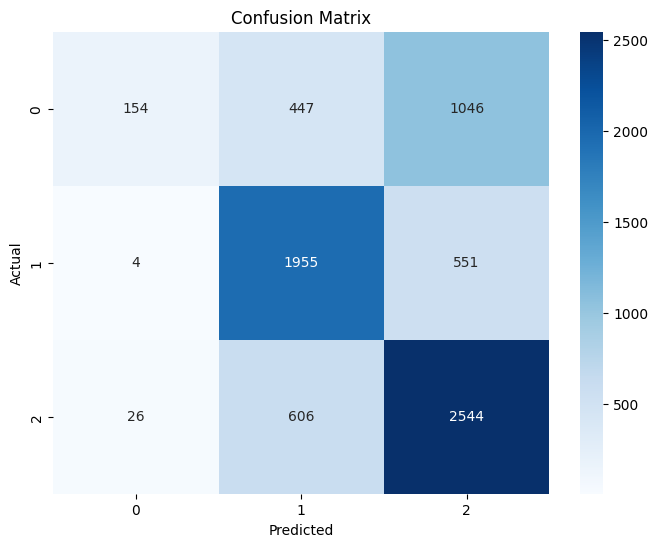

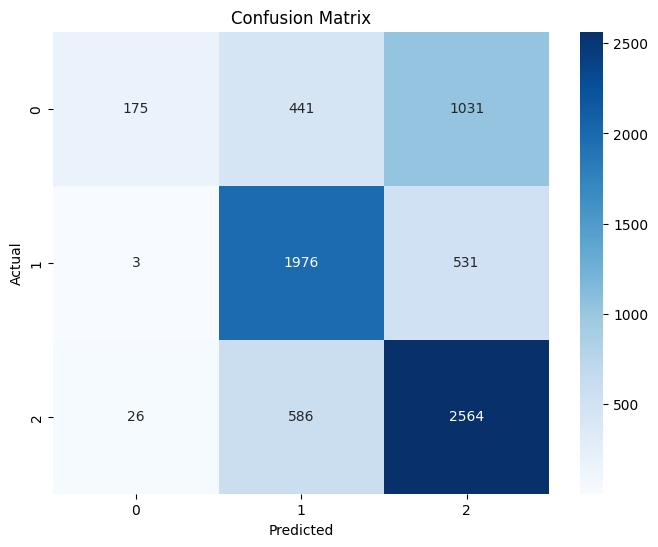

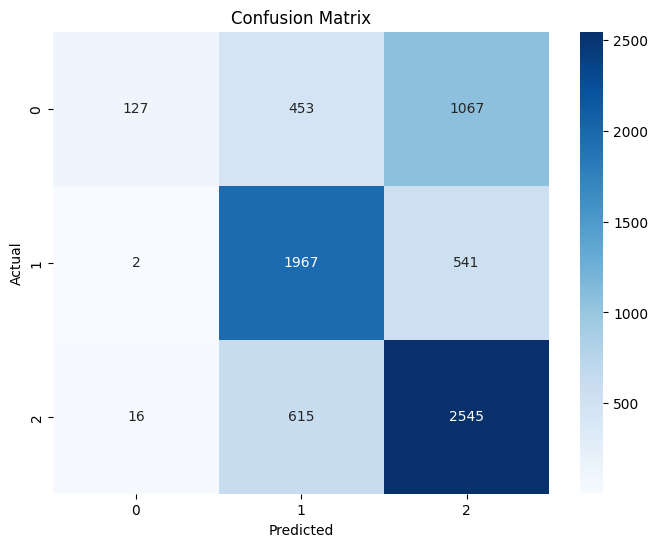

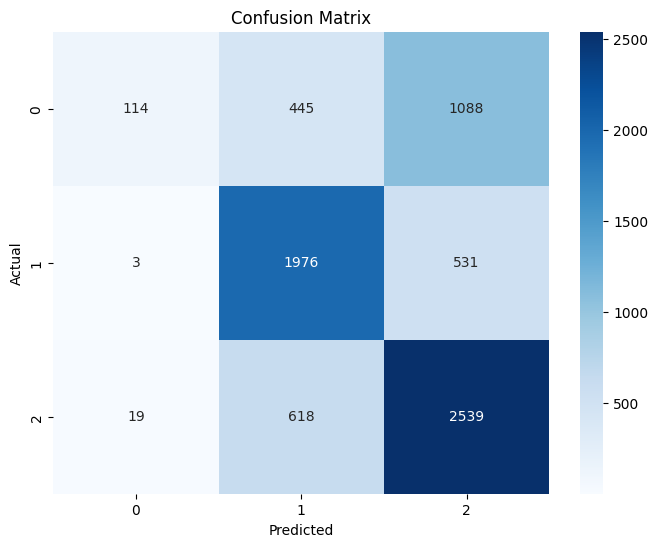

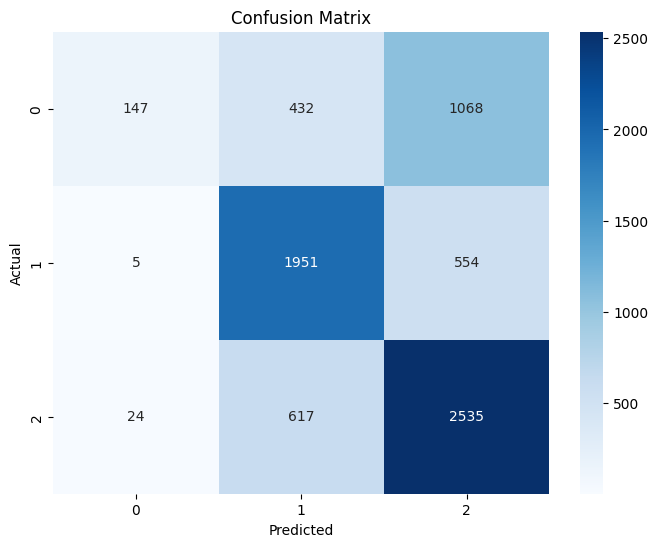

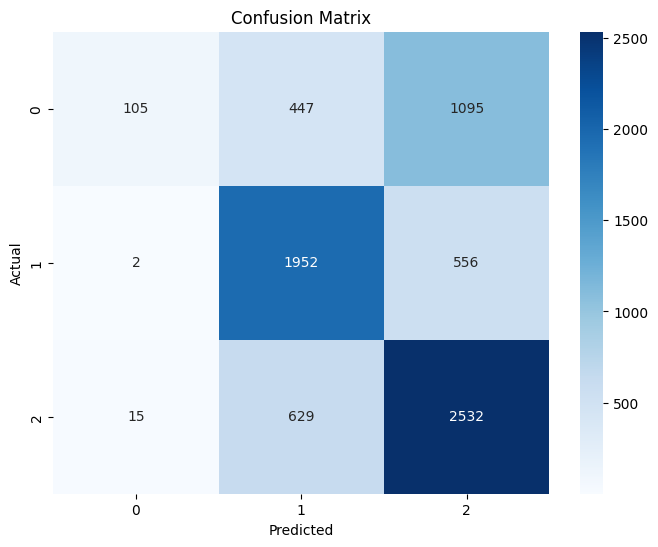

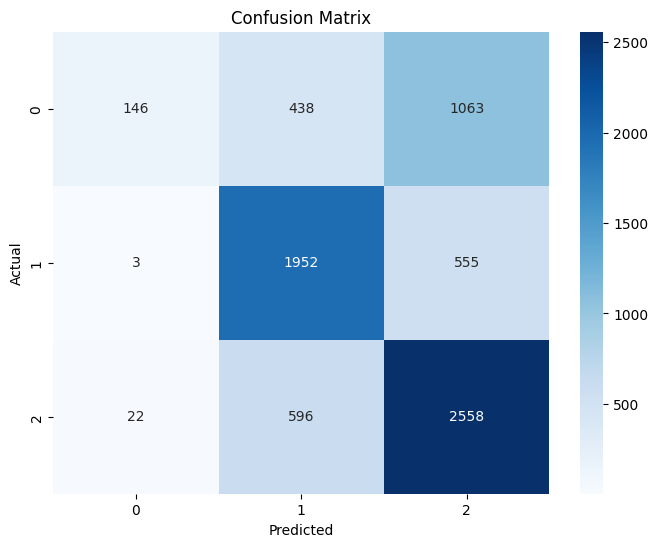

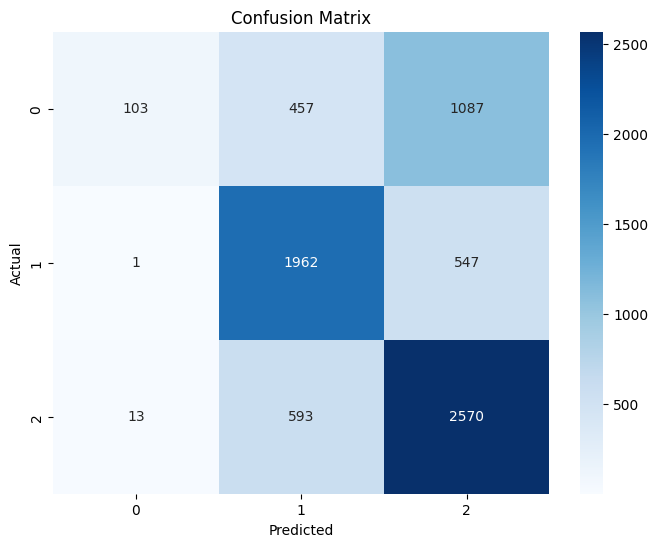

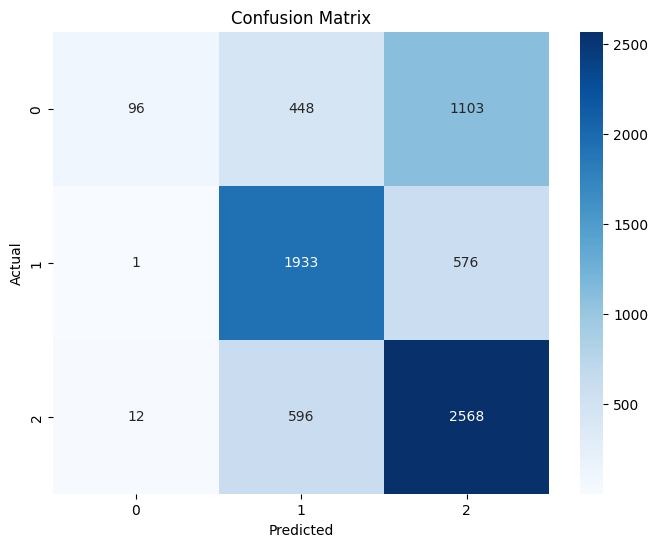

In [ ]:
# Running Optuna
study = optuna.create_study(direction="maximize", study_name='Bow vs TFIDF vs Word2vec')
study.optimize(objective, n_trials=200)

In [ ]:
# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.6429837719896359
Best hyperparameters: {'vectorizer_type': 'tfidf', 'ngram_range': '(1, 2)', 'max_features': 1006}
